# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Loading / Generating data
3. Set `LOAD_DATA_FROM_CSV` to `True` / `False` to load data from csv files / generate data in this notebook.

### Training without optimization

4. Set `OPTIMIZE = False` in section _Constants and flags to set_.
5. Run the entire notebook.

### Training with optimization

4. Set `OPTIMIZE = True` in section _Constants and flags to set_.
5. Run the entire notebook.

### Loading an already trained model

4. Run cells in section _Initialization_.
5. Run cells with definitions in section _Input data and labels_.
6. Run cell with the definition of _Net_ in section _Defining the neural network_.
7. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
8. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

9. Run section _Porting the model to C++_, this requires a model to be loaded.
10. Set the path to the `net.pt` file in the C++ source file.
11. `mkdir build && cd build`,
12. Configure a `CMakeLists.txt` file as is done [here](https://pytorch.org/cppdocs/installing.html).
13. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
14. Compile and run, e.g. `cmake --build . --config release && ./<executable name>`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [42]:
%%script echo skipping

!jupyter nbconvert GRMHD_ML.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [43]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_GRMHD/1e5_runs/adjusted_layers"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [44]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#%%script echo skipping

!pip install optuna optuna[visualization] tensorboard tensorboardX plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the **libraries**,

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx
import pandas as pd
import json
import pickle

### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023) in the case the model is being trained without optimization.

In [47]:

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_TRIALS = 300 # Number of trials for hyperparameter optimization # NOTE: Set this properly.
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values. # NOTE: Set this properly.
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.
LOAD_DATA_FROM_CSV = False  # If not true we generate the data in this file and save to {x_train,y_train,x_test,y_test}.csv, otherwise we load the data from files of the same name. # NOTE: Set this before properly.
STUDY_NAME='1e5_run4_adjusted_layers'

csv_filenames = { # File names to load input data and labels from if LOAD_DATA_FROM_CSV is True.
    "x_train": "x_train.csv",
    "x_val": "x_val.csv",
    "x_test": "x_test.csv",
    "y_train": "y_train.csv",
    "y_val": "y_val.csv",
    "y_test": "y_test.csv",
}

# Values to use for hyperparameters if OPTIMIZE is False; set these to the best parameters found by Optuna.
# NOTE: TODO: Currently (Sat May 27 05:16:57 PM CEST 2023) there are still subparameters to be set in create_model function.
N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "LeakyReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 500 # NOTE: Set this properly.
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"
DROPOUT_RATE_NO_OPT = 0.2

N_INPUTS = 14  # Number of input features.
N_OUTPUTS = 1  # Number of outputs.
Gamma = 5/3  # Adiabatic index

n_samples = 1e5 # NOTE: Set this properly.
train_frac = 0.7  # 70% of data for training
val_frac = 0.15  # 15% of data for validation, rest for testing

rho_interval = (0, 2) 
epsilon_interval = (1e-2, 2000)  # Will be sampled in log space
vx_interval = (0, 0.999)  
vy_interval = (0, 0.999)  
vz_interval = (0, 0.999)  
Bx_interval = (-10, 10)  
By_interval = (-10, 10)  
Bz_interval = (-10, 10)  
gxx_interval = (0.9, 1.1)
gxy_interval = (0, 0.1)
gxz_interval = (0, 0.1)
gyy_interval = (0.9, 1.1)
gyz_interval = (0, 0.1)
gzz_interval = (0.9, 1.1)

np.random.seed(91) # Comment for true random data.


## Input data and labels

We either generate the data or load the data. First the definitions for generating the data come below.

In [48]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    print('rho.shape: ', rho.shape)
    print('epsilon.shape: ', epsilon.shape)
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (Gamma - 1) * rho * epsilon

def sample_primitive_variables_and_metric():
    rho = np.random.uniform(*rho_interval)  
    epsilon = np.random.uniform(*np.log10(epsilon_interval))
    vx = np.random.uniform(*vx_interval)  
    vy = np.random.uniform(*vy_interval)  
    vz = np.random.uniform(*vz_interval)  
    Bx = np.random.uniform(*Bx_interval)  
    By = np.random.uniform(*By_interval)  
    Bz = np.random.uniform(*Bz_interval)  
    gxx = np.random.uniform(*gxx_interval)
    gxy = np.random.uniform(*gxy_interval)
    gxz = np.random.uniform(*gxz_interval)
    gyy = np.random.uniform(*gyy_interval)
    gyz = np.random.uniform(*gyz_interval)
    gzz = np.random.uniform(*gzz_interval)

    return rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz

def check_sample(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    wtemp_expr = 1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 + 2 * gxy * vx * vy + 2 * gxz * vx * vz + 2 * gyz * vy * vz)
    sdet_expr = gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2
    if vx**2 + vy**2 + vz**2 >= 1 or wtemp_expr < 0 or sdet_expr < 0:
        # print(f"Sample failed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return False
    else:
        # print(f"Sample passed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return True

def generate_samples(n_samples):
    samples = []
    while len(samples) < n_samples:
        sample = sample_primitive_variables_and_metric()
        if check_sample(*sample):
            samples.append(sample)
        # print(f"Number of valid samples: {len(samples)}")
    return zip(*samples)
def sdet(gxx, gxy, gxz, gyy, gyz, gzz):
    # Determinant of the three metric.
    return (gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2) ** 0.5

# Defining a function that computes conserved variables from primitive variables and the metric
# We follow the source code of GRaM-X: A new GPU-accelerated dynamical spacetime GRMHD code for Exascale
# computing with the Einstein Toolkit of Shankar et al.
def compute_conserved_variables(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    pres = eos_analytic(rho, epsilon)
    wtemp = 1 / (1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 +
        2 * gxy * vx * vy + 2 * gxz * vx * vz +
        2 * gyz * vy * vz))**0.5

    vlowx = gxx * vx + gxy * vy + gxz * vz
    vlowy = gxy * vx + gyy * vy + gyz * vz
    vlowz = gxz * vx + gyz * vy + gzz * vz

    Bxlow = gxx * Bx + gxy * By + gxz * Bz
    Bylow = gxy * Bx + gyy * By + gyz * Bz
    Bzlow = gxz * Bx + gyz * By + gzz * Bz

    B2 = Bxlow * Bx + Bylow * By + Bzlow * Bz

    Bdotv = Bxlow * vx + Bylow * vy + Bzlow * vz
    Bdotv2 = Bdotv * Bdotv
    wtemp2 = wtemp * wtemp
    b2 = B2 / wtemp2 + Bdotv2
    ab0 = wtemp * Bdotv

    blowx = (gxx * Bx + gxy * By + gxz * Bz) / wtemp + wtemp * Bdotv * vlowx
    blowy = (gxy * Bx + gyy * By + gyz * Bz) / wtemp + wtemp * Bdotv * vlowy
    blowz = (gxz * Bx + gyz * By + gzz * Bz) / wtemp + wtemp * Bdotv * vlowz

    hrhow2 = (rho * (1 + epsilon) + pres + b2) * (wtemp) * (wtemp)

    D = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * rho * (wtemp)
    Sx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowx - ab0 * blowx)
    Sy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowy - ab0 * blowy)
    Sz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowz - ab0 * blowz)
    tau = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 - pres - b2 / 2 - ab0 * ab0) - D
    Bconsx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bx
    Bconsy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * By
    Bconsz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bz

    return D, Sx, Sy, Sz, tau, Bconsx, Bconsy, Bconsz

def generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)
    Bx = torch.tensor(np.array(Bx), dtype=torch.float32).to(device)
    By = torch.tensor(np.array(By), dtype=torch.float32).to(device)
    Bz = torch.tensor(np.array(Bz), dtype=torch.float32).to(device)
    gxx = torch.tensor(np.array(gxx), dtype=torch.float32).to(device)
    gxy = torch.tensor(np.array(gxy), dtype=torch.float32).to(device)
    gxz = torch.tensor(np.array(gxz), dtype=torch.float32).to(device)
    gyy = torch.tensor(np.array(gyy), dtype=torch.float32).to(device)
    gyz = torch.tensor(np.array(gyz), dtype=torch.float32).to(device)
    gzz = torch.tensor(np.array(gzz), dtype=torch.float32).to(device)

    D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz = compute_conserved_variables(
        rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz
    ) 

    # Add gxx, gxy, gxz, gyy, gyz, gzz to the tensor
    x = torch.stack([D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz, gxx, gxy, gxz, gyy, gyz, gzz], axis=1)
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
# We use the definitions as given in Recovery schemes for primitive variables in
# general-relativistic magnetohydrodynamics of Siegel et al.
def generate_labels(rho, epsilon, vx, vy, vz):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)

    # Computing the required quantities
    pres = eos_analytic(rho, epsilon)
    h = 1 + epsilon + pres / rho
    W = 1 / torch.sqrt(1 - (vx * vx + vy * vy + vz * vz))

    # Returning the output data tensor
    return h * W

### Generating or loading input data and labels

In [49]:
%config InteractiveShell.ast_node_interactivity = "all"

In [50]:
if LOAD_DATA_FROM_CSV:
    # Load the data from CSV files
    x_train = pd.read_csv(csv_filenames["x_train"]).values
    y_train = pd.read_csv(csv_filenames["y_train"]).values.squeeze()  # reshape to 1D
    x_val = pd.read_csv(csv_filenames["x_val"]).values
    y_val = pd.read_csv(csv_filenames["y_val"]).values.squeeze()  # reshape to 1D
    x_test = pd.read_csv(csv_filenames["x_test"]).values
    y_test = pd.read_csv(csv_filenames["y_test"]).values.squeeze()  # reshape to 1D

    # Convert numpy arrays to tensors
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_val = torch.from_numpy(x_val).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # This is an alternative to having if clauses around the cells that visualize these variables.
    rho = epsilon = vx = vy = vz = Bx = By = Bz = gxx = gxy = gxz = gyy = gyz  = gzz = None

In [51]:
if not LOAD_DATA_FROM_CSV:
    # Sample primitive variables and metric
    rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz = generate_samples(n_samples)

In [52]:
if not LOAD_DATA_FROM_CSV:
    # Generate data and labels.
    x = generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz)
    y = generate_labels(rho, epsilon, vx, vy, vz)

    # Calculate the number of samples in each set
    n_train_samples = int(n_samples * train_frac)
    n_val_samples = int(n_samples * val_frac)

    # Create the data sets
    x_train = x[:n_train_samples]
    y_train = y[:n_train_samples]
    x_val = x[n_train_samples : n_train_samples + n_val_samples]
    y_val = y[n_train_samples : n_train_samples + n_val_samples]
    x_test = x[n_train_samples + n_val_samples :]
    y_test = y[n_train_samples + n_val_samples :]

    # Save the data to CSV files; tensors need to be converted numpy arrays for saving in CSV.
    pd.DataFrame(x_train.cpu().numpy()).to_csv(csv_filenames["x_train"], index=False)
    save_file(csv_filenames["x_train"])
    pd.DataFrame(y_train.cpu().numpy()).to_csv(csv_filenames["y_train"], index=False)
    save_file(csv_filenames["y_train"])

    pd.DataFrame(x_val.cpu().numpy()).to_csv(csv_filenames["x_val"], index=False)
    save_file(csv_filenames["x_val"])
    pd.DataFrame(y_val.cpu().numpy()).to_csv(csv_filenames["y_val"], index=False)
    save_file(csv_filenames["y_val"])

    pd.DataFrame(x_test.cpu().numpy()).to_csv(csv_filenames["x_test"], index=False)
    save_file(csv_filenames["x_test"])
    pd.DataFrame(y_test.cpu().numpy()).to_csv(csv_filenames["y_test"], index=False)
    save_file(csv_filenames["y_test"])

rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])
rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])


In [53]:

x_train.shape
y_train.shape
x_val.shape
y_val.shape
x_test.shape
y_test.shape
x_train
y_train
x_val
y_val
x_test
y_test

torch.Size([70000, 14])

torch.Size([70000])

torch.Size([15000, 14])

torch.Size([15000])

torch.Size([15000, 14])

torch.Size([15000])

tensor([[ 4.4684e-01,  1.5065e+00, -2.3501e+00,  ...,  9.1522e-01,
          3.4261e-02,  9.6139e-01],
        [ 1.7326e+00,  1.8291e+01, -2.5263e+00,  ...,  9.3787e-01,
          4.6801e-02,  1.0303e+00],
        [ 8.1560e-02, -1.3190e+00,  8.3835e-01,  ...,  9.2153e-01,
          4.8176e-02,  1.0497e+00],
        ...,
        [ 1.9611e+00, -8.7116e+00,  3.8659e+01,  ...,  9.8604e-01,
          8.9338e-02,  9.2787e-01],
        [ 1.5218e+00,  5.5179e+00,  4.4414e-01,  ...,  9.3965e-01,
          7.8723e-02,  1.0533e+00],
        [ 1.5397e+00,  9.7826e+00,  6.8052e+00,  ...,  9.3768e-01,
          1.1780e-02,  1.0672e+00]], device='cuda:0')

tensor([ 0.6442,  7.1512, -4.7510,  ...,  5.9678, -0.3853,  0.9425],
       device='cuda:0')

tensor([[ 3.7612e+00,  7.3917e+01,  2.3497e+01,  ...,  1.0621e+00,
          4.4504e-02,  1.0551e+00],
        [ 8.2474e-01,  2.4085e+01,  1.7873e+00,  ...,  9.7482e-01,
          4.0641e-03,  9.3812e-01],
        [ 7.6580e-01,  1.0988e+01,  3.7218e+01,  ...,  1.0084e+00,
          5.0477e-02,  1.0228e+00],
        ...,
        [ 2.4254e+00,  2.0606e+01,  1.3514e+01,  ...,  1.0895e+00,
          2.1703e-02,  9.0106e-01],
        [ 3.6347e+00,  1.6204e+01,  4.2041e+01,  ...,  1.0126e+00,
          6.8391e-02,  1.0750e+00],
        [ 7.0306e-01, -2.7878e+00, -3.9045e-01,  ...,  9.4128e-01,
          3.3790e-02,  1.0452e+00]], device='cuda:0')

tensor([10.0199,  3.6123,  6.4114,  ..., -0.5113,  7.7757,  5.2508],
       device='cuda:0')

tensor([[ 6.7747e-01,  4.7921e+01,  4.6454e+01,  ...,  9.0003e-01,
          3.7725e-02,  1.0061e+00],
        [ 3.6055e-01,  3.7422e+01,  3.1673e+01,  ...,  9.3217e-01,
          1.1468e-03,  1.0156e+00],
        [ 3.3188e+00,  1.2399e+01, -7.1275e+00,  ...,  1.0205e+00,
          2.3871e-02,  1.0499e+00],
        ...,
        [ 3.4012e+00,  5.0824e+01,  2.1991e+01,  ...,  1.0287e+00,
          9.7234e-02,  9.9444e-01],
        [ 2.2704e+00, -1.8069e+01,  3.8630e+01,  ...,  9.8837e-01,
          9.7089e-02,  9.1093e-01],
        [ 7.9651e-01,  1.2632e+01, -5.4843e+00,  ...,  1.0952e+00,
          3.4551e-02,  9.7640e-01]], device='cuda:0')

tensor([-5.7810,  7.7032, -1.9475,  ..., -2.3625,  7.4652,  1.4388],
       device='cuda:0')

In [54]:
torch.isnan(x_train).any()
torch.isnan(x_val).any()
torch.isnan(x_test).any()
torch.isnan(y_train).any()
torch.isnan(y_val).any()
torch.isnan(y_test).any()

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

In [55]:
nan_mask_train = torch.isnan(x_train)     # get a boolean mask indicating NaN values
nan_indices_train = torch.where(nan_mask_train)  # get the indices of the NaN values
nan_indices_train
# len(nan_indices_train)

nan_mask_val = torch.isnan(x_val)     # get a boolean mask indicating NaN values
nan_indices_val = torch.where(nan_mask_val)  # get the indices of the NaN values
nan_indices_val
# len(nan_indices_test)

nan_mask_test = torch.isnan(x_test)     # get a boolean mask indicating NaN values
nan_indices_test = torch.where(nan_mask_test)  # get the indices of the NaN values
nan_indices_test
# len(nan_indices_test)

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

## Visualizing the data

### Visualizing sampled data

In [56]:
%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    rho
    epsilon
    vx
    vy
    vz 
    Bx
    By
    Bz
    gxx
    gxy
    gxz
    gyy
    gyz
    gzz 

skipping


In [57]:
if not LOAD_DATA_FROM_CSV:
    print(len(rho))
    print(len(epsilon))
    print(len(vx))
    print(len(vy))
    print(len(vz))
    print(len(Bx))
    print(len(By))
    print(len(Bz))
    print()
    print(len(gxx))
    print(len(gxy))
    print(len(gxz))
    print(len(gyy))
    print(len(gyz))
    print(len(gzz))

100000
100000
100000
100000
100000
100000
100000
100000

100000
100000
100000
100000
100000
100000


In [58]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [59]:
%%script echo skipping

plt.hist([np.random.uniform(0, 0.999) for _ in range(n_train_samples)], bins=20)

skipping


In [60]:
%%script echo skipping

epsilon

skipping


The reason the sampling is not uniformly distributed in the following plots is due to the resampling and the fact that we certain values of e.g. velocity are more likely to violate the speed of light constraint than others.

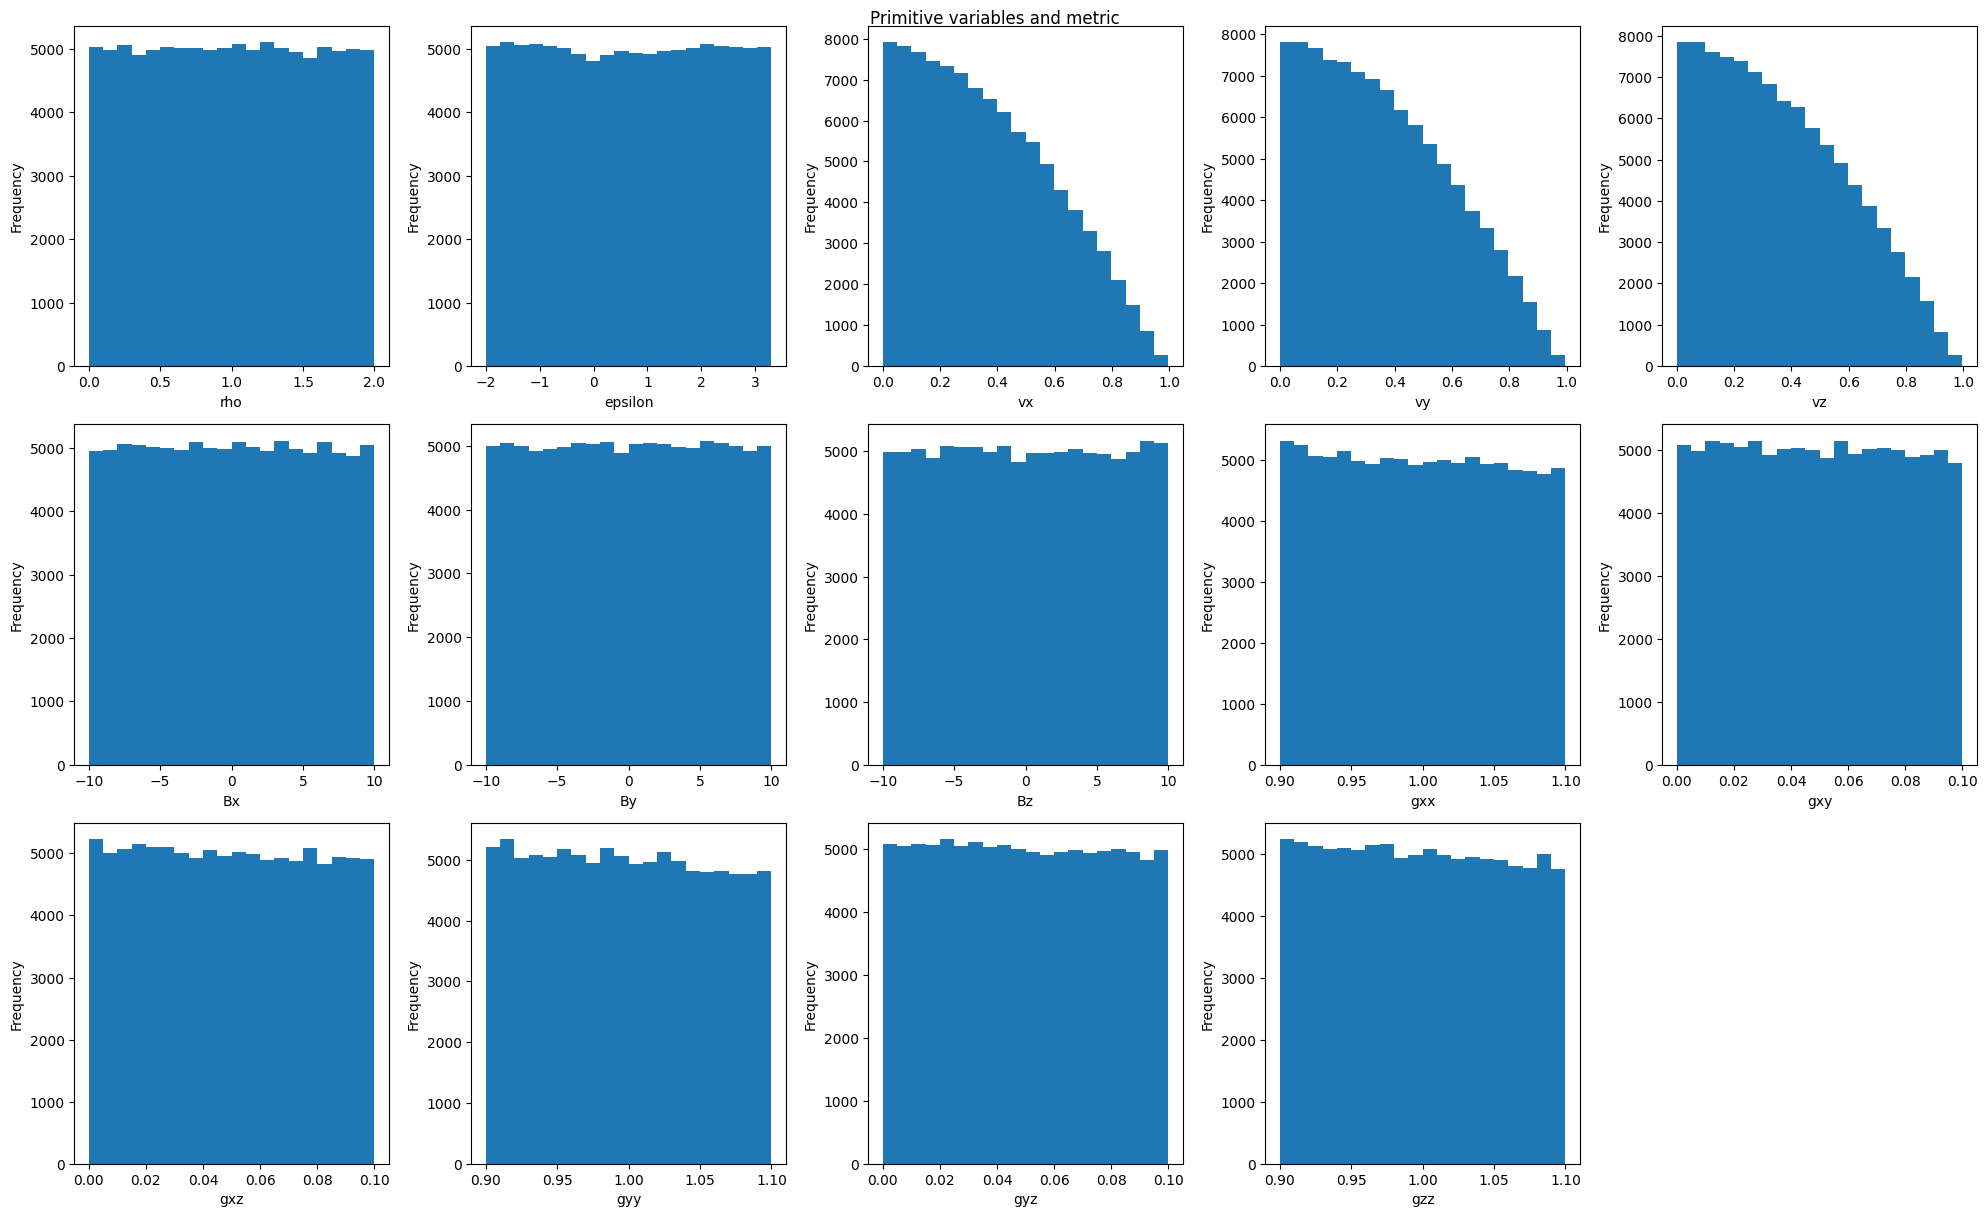

In [61]:
#%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    def plot_histogram(data, xlabel, ylabel, position, bins=20, xlog_scale=False, ylog_scale=False):
        plt.subplot(4, 5, position)
        plt.hist(data, bins=bins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlog_scale: # Setting does not work expected for epsilon.
            plt.xscale("log")
        if ylog_scale: # Setting does not work expected for epsilon.
            plt.yscale("log")

    # Plotting the histograms of rho, vx, epsilon, b0, b1, b2, and b3
    bins = 20
    plt.figure(figsize=(20, 16))

    plot_histogram(rho, "rho", "Frequency", 1, bins=bins)
    plot_histogram(epsilon, "epsilon", "Frequency", 2, bins=bins)
    plot_histogram(vx, "vx", "Frequency", 3, bins=bins)
    plot_histogram(vy, "vy", "Frequency", 4, bins=bins)
    plot_histogram(vz, "vz", "Frequency", 5, bins=bins)
    plot_histogram(Bx, "Bx", "Frequency", 6, bins=bins)
    plot_histogram(By, "By", "Frequency", 7, bins=bins)
    plot_histogram(Bz, "Bz", "Frequency", 8, bins=bins)

    # Plot these
    plot_histogram(gxx, "gxx", "Frequency", 9, bins=bins)
    plot_histogram(gxy, "gxy", "Frequency", 10, bins=bins)
    plot_histogram(gxz, "gxz", "Frequency", 11, bins=bins)
    plot_histogram(gyy, "gyy", "Frequency", 12, bins=bins)
    plot_histogram(gyz, "gyz", "Frequency", 13, bins=bins)
    plot_histogram(gzz, "gzz", "Frequency", 14, bins=bins)


    plt.suptitle("Primitive variables and metric")
    plt.tight_layout()
    plt.show()


In [62]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

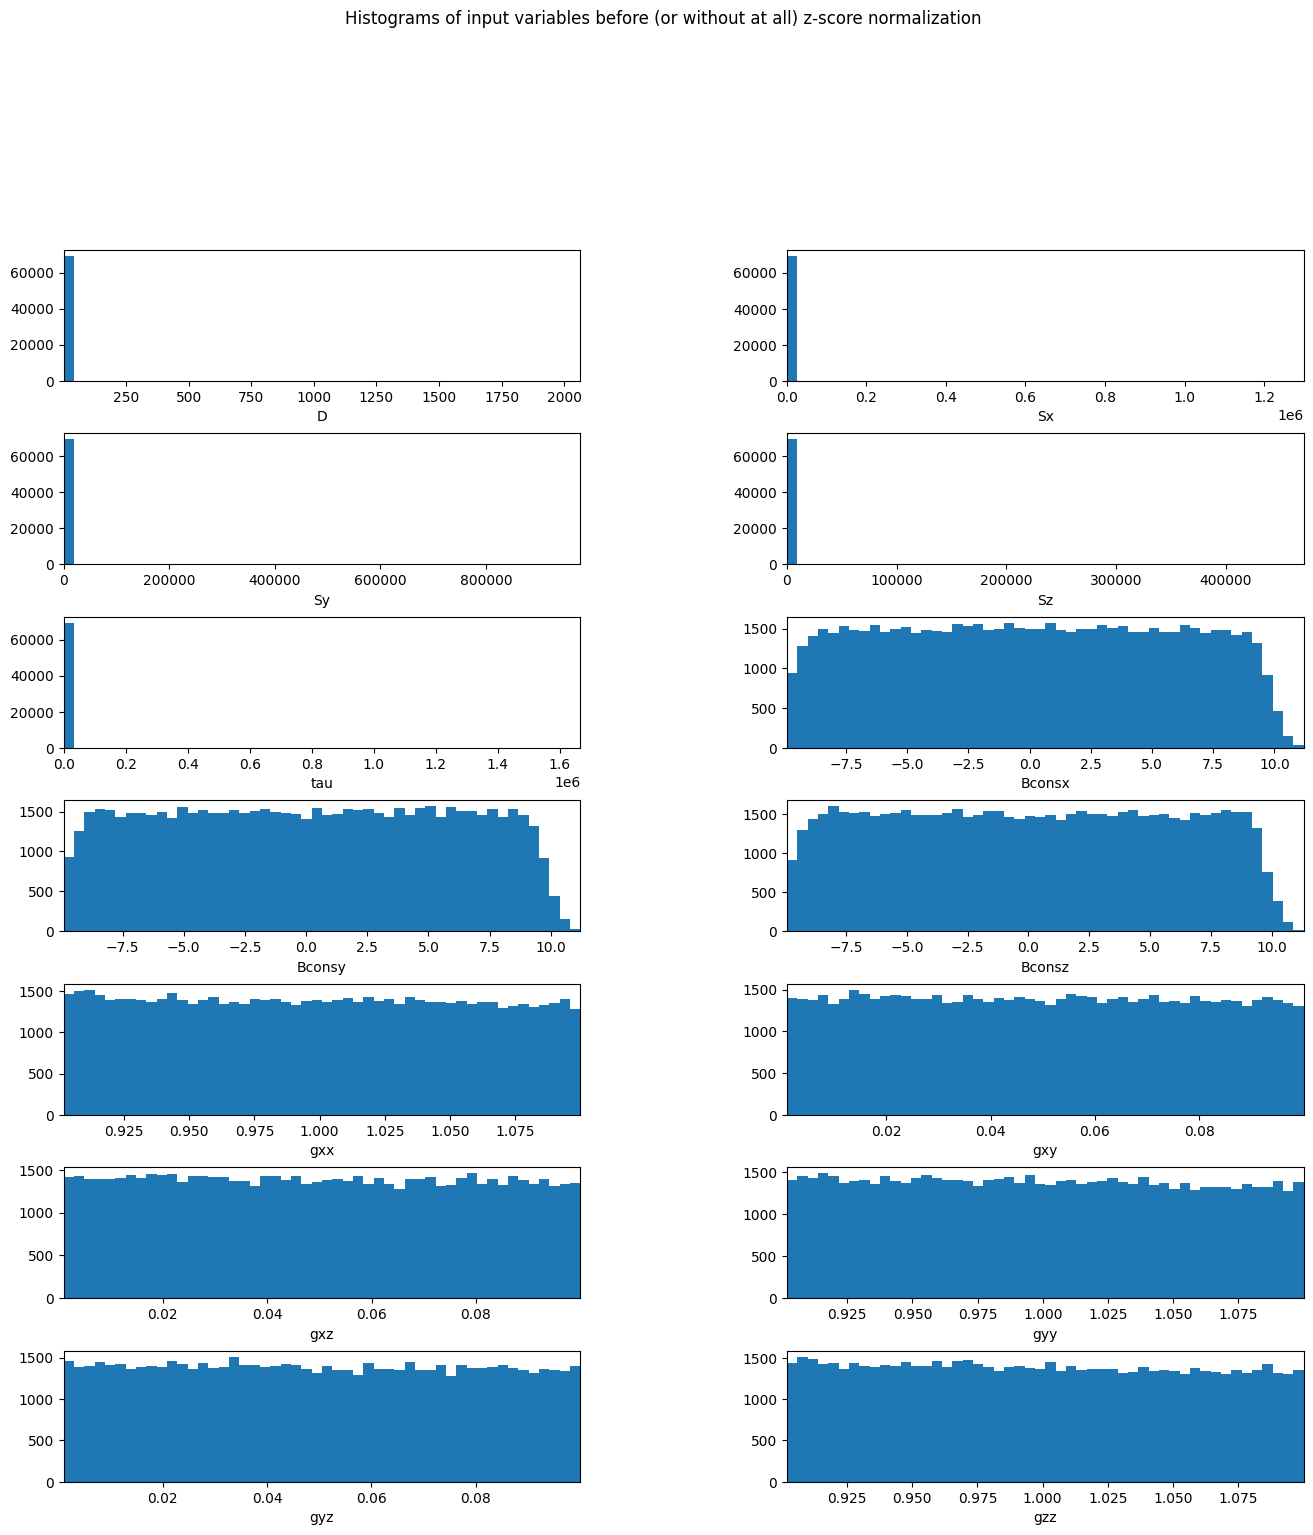

In [63]:
#%%script echo skipping

# Variable names
variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(16, 16))
plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

for i in range(N_INPUTS):
    plt.subplot(7, 2, i+1)
    data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
    lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
    # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

    plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
    plt.xlabel(variable_names[i])
    plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Same plotting but for the test data. Adjust the percentile range as needed to zoom in.
# plt.figure(figsize=(16, 16))
# plt.suptitle('Histograms of input variables before (or without at all) z-score normalization (test data)', y=1.03)

# for i in range(14):
#     plt.subplot(7, 2, i+1)
#     data = x_test[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
#     #lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
#     lower_bound, upper_bound = np.percentile(data, [1, 99]) # Use this to zoom in.

#     plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
#     plt.xlabel(variable_names[i])
#     plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# plt.show()



### Data normalization

In [64]:
# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[ 2.3410e-05,  2.0643e+03,  2.3150e+00,  1.6678e+00,  8.7773e+00],
        [-1.8313e+04,  1.2995e+06,  6.0919e+01,  2.2053e+01,  4.9588e+03],
        [-7.7549e+04,  9.7829e+05,  5.3607e+01,  2.1977e+01,  3.7541e+03],
        [-3.0909e+04,  4.7100e+05,  5.0692e+01,  2.1806e+01,  2.0724e+03],
        [-7.9737e+04,  1.6657e+06,  1.2245e+02,  6.9601e+01,  6.4414e+03],
        [-1.1142e+01,  1.1190e+01, -1.0575e-02, -1.9842e-02,  5.7128e+00],
        [-1.1206e+01,  1.1203e+01,  1.2412e-02,  3.3881e-02,  5.7297e+00],
        [-1.1253e+01,  1.1306e+01, -2.6358e-06, -1.9080e-02,  5.7518e+00],
        [ 9.0000e-01,  1.1000e+00,  9.9869e-01,  9.9857e-01,  5.7853e-02],
        [ 3.5108e-07,  9.9999e-02,  4.9659e-02,  4.9512e-02,  2.8827e-02],
        [ 4.2349e-07,  1.0000e-01,  4.9567e-02,  4.9349e-02,  2.8875e-02],
        [ 9.0000e-01,  1.1000e+00,  9.9863e-01,  9.9790e-01,  5.7659e-02],
        [ 7.5907e-07,  9.9998e-02

Perform z-score normalization

In [65]:
%config InteractiveShell.ast_node_interactivity = "all"

In [66]:
if ZSCORE_NORMALIZATION:
    
    # TODO: Add magnetic field variables to the normalization if I decide to use the old code that is commented out here.
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [67]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [68]:
if not LOAD_DATA_FROM_CSV:
    if ZSCORE_NORMALIZATION:
        # Variable names
        variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

        # Plotting histograms of the input variables before z-score normalization
        plt.figure(figsize=(16, 16))
        plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

        for i in range(N_INPUTS):
            plt.subplot(7, 2, i+1)
            data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
            lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
            # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

            plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
            plt.xlabel(variable_names[i])
            plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

In [69]:
if ZSCORE_NORMALIZATION:
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


### Visualizing input data and labels

In [70]:
x_train
y_train
x_val
y_val
x_test
y_test

tensor([-5.7810,  7.7032, -1.9475,  ..., -2.3625,  7.4652,  1.4388],
       device='cuda:0')

Checking if our output is always positive ~~by plotting a histogram of y_train and y_test tensors~~

In [71]:
import torch

# Create a sample tensor
tensor = torch.randn(80000, 14)  # Assuming a tensor of shape [80000, 14]
tensor


# Check if any element is negative
any_negative = torch.any(tensor < 0)

# Print the result
print(any_negative)


tensor(True)


In [72]:
y_train.shape
any_negative = torch.any(y_train < 0)
any_negative

y_test.shape
any_negative = torch.any(y_test < 0)
any_negative

x_train.shape
any_negative = torch.any(x_train < 0)
any_negative

tensor(True, device='cuda:0')

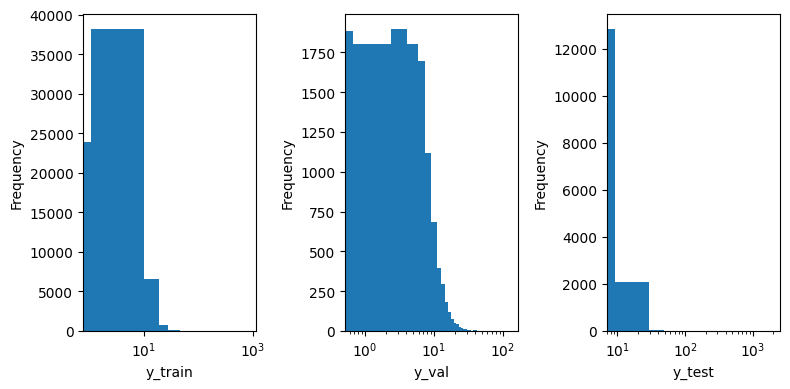

In [73]:
#%%script echo skipping

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train.cpu().numpy(), bins=100) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.xscale("log")
plt.subplot(1, 3, 2)
plt.hist(y_val.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_val")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.subplot(1, 3, 3)
plt.hist(y_test.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.show()


In [74]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [75]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation, dropout_rate):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
            TODO: [ver. Copilot description] dropout_rate (float): The dropout rate to use for all layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        self.layers.append(nn.Linear(N_INPUTS, n_units[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rate))

        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rate))

        self.layers.append(nn.Linear(n_units[-1], N_OUTPUTS))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, N_INPUTS).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, N_OUTPUTS).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == N_INPUTS, f"x must have shape (batch_size, {N_INPUTS})"

        for layer, dropout in zip(self.layers[:-1], self.dropouts):
            x = dropout(self.hidden_activation(layer(x)))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x)) # No dropout at output layer

        return x # Returning the output tensor


In [76]:
%%script echo skipping

[1,2,3]
[1,2,3][:-1]

skipping


In [77]:
for x in [1,2,3][:-1]:
    print(x)



1
2


## Defining the model and search space

In [78]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
            dropout_rate is the dropout rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if OPTIMIZE:
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 4096) for i in range(n_layers)]

        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "PReLU", "Swish", "GELU", "SoftPlus"]
        )
        output_activation_name = trial.suggest_categorical( "output_activation", ["Linear"])

        loss_name = trial.suggest_categorical( "loss", ["MSE", "MAE", "Huber", "Quantile"]) 

        optimizer_name = trial.suggest_categorical( "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] )

        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

        batch_size_list = [32, 64, 128, 256, 512, 1024, 2048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        
        n_epochs = trial.suggest_int("n_epochs", 50, 150)

        # scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "CyclicLR"])
        scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"])

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize thresshold subparameters, as it's mainly for numerical stability.

        dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = 0.01
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = 0.25
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = 1
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize threshold subparameter, as it's mainly for numerical stability.

        dropout_rate = DROPOUT_RATE_NO_OPT


    # We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
    output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    elif loss_name == "Quantile":
        def quantile_loss(y_pred, y_true, q=0.5):
            e = y_pred - y_true
            return torch.mean(torch.max(q*e, (q-1)*e))
        loss_fn = quantile_loss
    else:
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation, dropout_rate).to(device)


    if OPTIMIZE:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        elif scheduler_name == "CyclicLR":
            base_lr = trial.suggest_loguniform("base_lr", 1e-6, 1e-2)
            max_lr = trial.suggest_loguniform("max_lr", 1e-4, 1)
            step_size_up = trial.suggest_int("step_size_up", 200, 2000)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        elif scheduler_name == "CyclicLR":
            # TODO: Change these appropriately.
            base_lr = 1e-6
            max_lr = 1e-4
            step_size_up = 200
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr, dropout_rate




 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [79]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [80]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, test_loader, trial=None):
    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = []
    val_metrics = []
    test_metrics = []


    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        if val_loader is not None:
            net.eval()
            val_loss = 0.0
            val_l1_norm = 0.0
            val_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    val_loss += loss.item() * x_batch.size(0)
                    val_l1_norm += l1_norm.item() * x_batch.size(0)
                    val_linf_norm += linf_norm.item() * x_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_l1_norm /= len(val_loader.dataset)
            val_linf_norm /= len(val_loader.dataset)

            val_losses.append(val_loss)
            val_metrics.append(
                {
                    "l1_norm": val_l1_norm,
                    "linf_norm": val_linf_norm,
                }
            )

            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("L1 norm/val", val_l1_norm, epoch)
            writer.add_scalar("Linf norm/val", val_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Val loss: {val_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Val L1 norm: {val_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Val Linf norm: {val_linf_norm:.3f}")


            update_scheduler(scheduler, val_loss)

        if test_loader is not None:
            net.eval()
            test_loss = 0.0
            test_l1_norm = 0.0
            test_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    test_loss += loss.item() * x_batch.size(0)
                    test_l1_norm += l1_norm.item() * x_batch.size(0)
                    test_linf_norm += linf_norm.item() * x_batch.size(0)

            test_loss /= len(test_loader.dataset)
            test_l1_norm /= len(test_loader.dataset)
            test_linf_norm /= len(test_loader.dataset)

            test_losses.append(test_loss)
            test_metrics.append(
                {
                    "l1_norm": test_l1_norm,
                    "linf_norm": test_linf_norm,
                }
            )

            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
            writer.add_scalar("Linf norm/test", test_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Test loss: {test_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Test L1 norm: {test_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Test Linf norm: {test_linf_norm:.3f}")


        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(val_l1_norm, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics


## The objective function and hyperparameter tuning

In [81]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

    # Create separate data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size
    )
    
    _, _, _, _, val_metrics, _ = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, None, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return val_metrics[-1]["l1_norm"]

In [82]:
# Visualize Optuna study while its running, alternative to tensorboard
from IPython import display
def callback(study, trial):
    display.clear_output(wait=True)
    optuna.visualization.plot_optimization_history(study).show()

if OPTIMIZE:
    # Include the path to the SQLite file in your create_study call.
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(), 
                                storage=f'sqlite:///{STUDY_NAME}.db')

    #study.optimize(objective, n_trials=N_TRIALS, callbacks=[callback])
    study.optimize(objective, n_trials=N_TRIALS)

[I 2023-05-31 19:45:18,319] A new study created in RDB with name: no-name-bd6c902d-ab82-426c-8c52-5e8a3f7bb502
<ipython-input-78-46c28bc3cd67>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
<ipython-input-78-46c28bc3cd67>:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
<ipython-input-78-46c28bc3cd67>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-78-46c28bc3cd67>:

Epoch 1/63.. Train loss: 7019.973.. Val loss: 1171.367.. Train L1 norm: 6300.287.. Val L1 norm: 1160.969.. Train Linf norm: 2653934.234.. Val Linf norm: 341778.949
Epoch 2/63.. Train loss: 1197.406.. Val loss: 574.870.. Train L1 norm: 1039.199.. Val L1 norm: 634.628.. Train Linf norm: 484690.768.. Val Linf norm: 179932.540
Epoch 3/63.. Train loss: 778.759.. Val loss: 135.342.. Train L1 norm: 873.882.. Val L1 norm: 126.002.. Train Linf norm: 385098.460.. Val Linf norm: 43322.912
Epoch 4/63.. Train loss: 253.196.. Val loss: 128.497.. Train L1 norm: 202.692.. Val L1 norm: 119.565.. Train Linf norm: 77738.798.. Val Linf norm: 40064.540
Epoch 5/63.. Train loss: 188.155.. Val loss: 15.080.. Train L1 norm: 208.779.. Val L1 norm: 14.693.. Train Linf norm: 94192.261.. Val Linf norm: 5046.333
Epoch 6/63.. Train loss: 25.229.. Val loss: 106.614.. Train L1 norm: 28.193.. Val L1 norm: 105.435.. Train Linf norm: 14233.083.. Val Linf norm: 31234.510
Epoch 7/63.. Train loss: 31.967.. Val loss: 23.021.

[I 2023-05-31 19:52:40,527] Trial 0 finished with value: 3.4047220932006836 and parameters: {'batch_size': 1024, 'beta1': 0.915957374822521, 'beta2': 0.9992070255109873, 'dropout_rate': 0.2755646309340076, 'gamma': 0.3479064622679786, 'hidden_activation': 'PReLU', 'loss': 'MAE', 'lr': 0.0026735812077350245, 'n_epochs': 63, 'n_layers': 5, 'n_units_0': 2043, 'n_units_1': 3280, 'n_units_2': 3575, 'n_units_3': 3676, 'n_units_4': 2924, 'optimizer': 'Adam', 'output_activation': 'Linear', 'prelu_init': 0.28539139316761003, 'scheduler': 'StepLR', 'step_size': 9, 'weight_decay': 0.0045691146429502226}. Best is trial 0 with value: 3.4047220932006836.


Epoch 63/63.. Train loss: 5.142.. Val loss: 4.594.. Train L1 norm: 3.417.. Val L1 norm: 3.405.. Train Linf norm: 1100.801.. Val Linf norm: 942.061


<ipython-input-78-46c28bc3cd67>:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
<ipython-input-78-46c28bc3cd67>:175: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)


Epoch 1/130.. Train loss: 2.492.. Val loss: 2.078.. Train L1 norm: 5.411.. Val L1 norm: 3.659.. Train Linf norm: 1364.851.. Val Linf norm: 685.492
Epoch 2/130.. Train loss: 2.330.. Val loss: 2.257.. Train L1 norm: 5.174.. Val L1 norm: 4.178.. Train Linf norm: 1201.346.. Val Linf norm: 761.771
Epoch 3/130.. Train loss: 2.263.. Val loss: 2.123.. Train L1 norm: 5.112.. Val L1 norm: 4.652.. Train Linf norm: 1107.456.. Val Linf norm: 826.983
Epoch 4/130.. Train loss: 2.358.. Val loss: 2.138.. Train L1 norm: 5.213.. Val L1 norm: 4.270.. Train Linf norm: 1175.746.. Val Linf norm: 747.804
Epoch 5/130.. Train loss: 2.280.. Val loss: 1.970.. Train L1 norm: 5.455.. Val L1 norm: 5.534.. Train Linf norm: 1326.783.. Val Linf norm: 1040.253
Epoch 6/130.. Train loss: 2.045.. Val loss: 2.020.. Train L1 norm: 5.462.. Val L1 norm: 5.449.. Train Linf norm: 1281.796.. Val Linf norm: 1107.388
Epoch 7/130.. Train loss: 2.382.. Val loss: 2.520.. Train L1 norm: 5.361.. Val L1 norm: 1.953.. Train Linf norm: 128

[I 2023-05-31 20:02:47,325] Trial 1 finished with value: 5.283231058120728 and parameters: {'batch_size': 512, 'beta1': 0.9537846559176212, 'beta2': 0.9995752064763457, 'dropout_rate': 0.06652089455764498, 'eta_min': 0.009975522006811007, 'hidden_activation': 'Swish', 'loss': 'Quantile', 'lr': 5.578139014927765e-05, 'n_epochs': 130, 'n_layers': 5, 'n_units_0': 3899, 'n_units_1': 1226, 'n_units_2': 1724, 'n_units_3': 3568, 'n_units_4': 3042, 'optimizer': 'Adam', 'output_activation': 'Linear', 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.19562186454607522, 'weight_decay': 0.0009290205760566169}. Best is trial 0 with value: 3.4047220932006836.


Epoch 130/130.. Train loss: 5.771.. Val loss: 2.130.. Train L1 norm: 9.882.. Val L1 norm: 5.283.. Train Linf norm: 3163.906.. Val Linf norm: 841.986


<ipython-input-78-46c28bc3cd67>:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
<ipython-input-78-46c28bc3cd67>:178: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.5)
<ipython-input-78-46c28bc3cd67>:180: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1/113.. Train loss: 72121.590.. Val loss: 11011.160.. Train L1 norm: 16.353.. Val L1 norm: 9.210.. Train Linf norm: 3618.600.. Val Linf norm: 1694.160
Epoch 2/113.. Train loss: 95371.299.. Val loss: 13857.108.. Train L1 norm: 26.445.. Val L1 norm: 6.338.. Train Linf norm: 6973.726.. Val Linf norm: 1246.455
Epoch 3/113.. Train loss: 3051076.840.. Val loss: 2848.976.. Train L1 norm: 32.723.. Val L1 norm: 6.820.. Train Linf norm: 7061.324.. Val Linf norm: 1409.954
Epoch 4/113.. Train loss: 350585.059.. Val loss: 5194.166.. Train L1 norm: 44.262.. Val L1 norm: 16.339.. Train Linf norm: 11980.403.. Val Linf norm: 3662.904
Epoch 5/113.. Train loss: 1691632.893.. Val loss: 3211130.269.. Train L1 norm: 21.863.. Val L1 norm: 143.422.. Train Linf norm: 5646.964.. Val Linf norm: 26108.797
Epoch 6/113.. Train loss: 1325606.497.. Val loss: 2593015.277.. Train L1 norm: 84.583.. Val L1 norm: 128.200.. Train Linf norm: 22712.056.. Val Linf norm: 23281.555
Epoch 7/113.. Train loss: 51848033.054..

[I 2023-05-31 20:06:10,984] Trial 2 finished with value: 2.506277460225423 and parameters: {'batch_size': 512, 'dropout_rate': 0.07792928145194117, 'factor': 0.432114536054105, 'hidden_activation': 'SoftPlus', 'loss': 'MSE', 'lr': 4.3290223634595435e-05, 'n_epochs': 113, 'n_layers': 2, 'n_units_0': 3280, 'n_units_1': 2530, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'softplus_beta': 0.9131936437772495, 'threshold': 0.0062191478743780365}. Best is trial 2 with value: 2.506277460225423.


Epoch 113/113.. Train loss: 80246.265.. Val loss: 420.617.. Train L1 norm: 9.377.. Val L1 norm: 2.506.. Train Linf norm: 2316.719.. Val Linf norm: 337.396
Epoch 1/80.. Train loss: 5.041.. Val loss: 4.142.. Train L1 norm: 3.841.. Val L1 norm: 3.805.. Train Linf norm: 1462.432.. Val Linf norm: 1111.355
Epoch 2/80.. Train loss: 4.608.. Val loss: 4.245.. Train L1 norm: 3.799.. Val L1 norm: 4.268.. Train Linf norm: 1461.597.. Val Linf norm: 1271.882
Epoch 3/80.. Train loss: 4.934.. Val loss: 4.379.. Train L1 norm: 3.619.. Val L1 norm: 3.946.. Train Linf norm: 1193.549.. Val Linf norm: 1114.306
Epoch 4/80.. Train loss: 5.222.. Val loss: 4.431.. Train L1 norm: 4.276.. Val L1 norm: 4.353.. Train Linf norm: 1885.846.. Val Linf norm: 1305.380
Epoch 5/80.. Train loss: 5.334.. Val loss: 4.455.. Train L1 norm: 4.379.. Val L1 norm: 5.074.. Train Linf norm: 2049.935.. Val Linf norm: 1677.074
Epoch 6/80.. Train loss: 4.850.. Val loss: 4.042.. Train L1 norm: 3.488.. Val L1 norm: 3.791.. Train Linf norm

[I 2023-05-31 20:11:06,288] Trial 3 finished with value: 5.065161105092367 and parameters: {'batch_size': 1024, 'beta1': 0.9662184604085253, 'beta2': 0.999815185118049, 'dropout_rate': 0.2604458714832226, 'factor': 0.23244181492811467, 'hidden_activation': 'PReLU', 'loss': 'Huber', 'lr': 0.00014203054841321186, 'n_epochs': 80, 'n_layers': 5, 'n_units_0': 654, 'n_units_1': 3552, 'n_units_2': 4075, 'n_units_3': 590, 'n_units_4': 2222, 'optimizer': 'Adam', 'output_activation': 'Linear', 'patience': 6, 'prelu_init': 0.16392359996203618, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.00022945242693069972, 'weight_decay': 0.0009836705691925892}. Best is trial 2 with value: 2.506277460225423.


Epoch 80/80.. Train loss: 3.805.. Val loss: 3.899.. Train L1 norm: 4.225.. Val L1 norm: 5.065.. Train Linf norm: 1521.459.. Val Linf norm: 1683.778


<ipython-input-78-46c28bc3cd67>:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)


Epoch 1/55.. Train loss: 3.714.. Val loss: 2.327.. Train L1 norm: 6.163.. Val L1 norm: 4.556.. Train Linf norm: 2770.423.. Val Linf norm: 1447.290
Epoch 2/55.. Train loss: 3.177.. Val loss: 2.395.. Train L1 norm: 4.693.. Val L1 norm: 4.602.. Train Linf norm: 1938.165.. Val Linf norm: 1505.037
Epoch 3/55.. Train loss: 2.628.. Val loss: 2.298.. Train L1 norm: 5.312.. Val L1 norm: 4.231.. Train Linf norm: 2044.149.. Val Linf norm: 1321.238
Epoch 4/55.. Train loss: 2.992.. Val loss: 2.375.. Train L1 norm: 3.951.. Val L1 norm: 4.588.. Train Linf norm: 1674.571.. Val Linf norm: 1491.996
Epoch 5/55.. Train loss: 2.835.. Val loss: 2.370.. Train L1 norm: 3.643.. Val L1 norm: 3.987.. Train Linf norm: 1235.515.. Val Linf norm: 1335.011
Epoch 6/55.. Train loss: 2.673.. Val loss: 2.445.. Train L1 norm: 3.732.. Val L1 norm: 4.636.. Train Linf norm: 1286.202.. Val Linf norm: 1557.471
Epoch 7/55.. Train loss: 2.587.. Val loss: 2.327.. Train L1 norm: 4.613.. Val L1 norm: 4.568.. Train Linf norm: 1514.0

[I 2023-05-31 20:12:37,259] Trial 4 finished with value: 4.105272180684407 and parameters: {'batch_size': 1024, 'dropout_rate': 0.1005022309397478, 'factor': 0.37263624352657165, 'hidden_activation': 'LeakyReLU', 'leakyrelu_slope': 0.2806538074707637, 'loss': 'Quantile', 'lr': 0.00015893158058095388, 'n_epochs': 55, 'n_layers': 3, 'n_units_0': 1648, 'n_units_1': 2397, 'n_units_2': 1106, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.006049632115361098}. Best is trial 2 with value: 2.506277460225423.


Epoch 55/55.. Train loss: 2.417.. Val loss: 2.258.. Train L1 norm: 3.508.. Val L1 norm: 4.105.. Train Linf norm: 1204.239.. Val Linf norm: 1392.283


<ipython-input-78-46c28bc3cd67>:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-78-46c28bc3cd67>:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
/usr/local/lib/python3.10/dist-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)
[I 2023-05-31 20:12:38,800] Trial 5 pruned. 


Epoch 1/147.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan
Epoch 1/53.. Train loss: 4366803.940.. Val loss: 551.827.. Train L1 norm: 11.335.. Val L1 norm: 1.691.. Train Linf norm: 920.644.. Val Linf norm: 67.873
Epoch 2/53.. Train loss: 121178.598.. Val loss: 117756.239.. Train L1 norm: 6.964.. Val L1 norm: 26.067.. Train Linf norm: 433.896.. Val Linf norm: 1763.225
Epoch 3/53.. Train loss: 164367.745.. Val loss: 1460.420.. Train L1 norm: 30.764.. Val L1 norm: 3.312.. Train Linf norm: 2224.194.. Val Linf norm: 213.760
Epoch 4/53.. Train loss: 31471.376.. Val loss: 824.994.. Train L1 norm: 9.182.. Val L1 norm: 3.117.. Train Linf norm: 630.021.. Val Linf norm: 188.878
Epoch 5/53.. Train loss: 53907.125.. Val loss: 6252.044.. Train L1 norm: 12.754.. Val L1 norm: 6.673.. Train Linf norm: 932.100.. Val Linf norm: 416.779
Epoch 6/53.. Train loss: 183565.378.. Val loss: 935.795.. Train L1 norm: 13.506.. Val L1 norm: 4.162.

[I 2023-05-31 20:16:35,058] Trial 6 finished with value: 2.5943556540171304 and parameters: {'batch_size': 128, 'dropout_rate': 0.03863470906716282, 'factor': 0.3373361501195473, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 5.51126169544332e-05, 'n_epochs': 53, 'n_layers': 4, 'n_units_0': 1123, 'n_units_1': 3207, 'n_units_2': 1760, 'n_units_3': 2545, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 10, 'prelu_init': 0.23652895642964072, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0026739265358919784}. Best is trial 2 with value: 2.506277460225423.


Epoch 53/53.. Train loss: 295.618.. Val loss: 184.714.. Train L1 norm: 2.318.. Val L1 norm: 2.594.. Train Linf norm: 128.720.. Val Linf norm: 142.380


[I 2023-05-31 20:16:47,293] Trial 7 pruned. 


Epoch 1/95.. Train loss: 1825031.521.. Val loss: 2.129.. Train L1 norm: 1908230.021.. Val L1 norm: 5.335.. Train Linf norm: 25242886.855.. Val Linf norm: 199.446


[I 2023-05-31 20:16:54,598] Trial 8 pruned. 


Epoch 1/114.. Train loss: 2510.004.. Val loss: 9798.239.. Train L1 norm: 2748.740.. Val L1 norm: 13350.945.. Train Linf norm: 125908.954.. Val Linf norm: 507661.864


[I 2023-05-31 20:16:59,653] Trial 9 pruned. 


Epoch 1/131.. Train loss: 118724.850.. Val loss: 2.173.. Train L1 norm: 173983.085.. Val L1 norm: 6.170.. Train Linf norm: 5873713.717.. Val Linf norm: 418.510


[I 2023-05-31 20:17:01,040] Trial 10 pruned. 


Epoch 1/101.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan
Epoch 1/79.. Train loss: 8648.659.. Val loss: 62.290.. Train L1 norm: 2.626.. Val L1 norm: 1.583.. Train Linf norm: 301.908.. Val Linf norm: 108.941
Epoch 2/79.. Train loss: 3473.168.. Val loss: 368.150.. Train L1 norm: 2.227.. Val L1 norm: 1.979.. Train Linf norm: 230.065.. Val Linf norm: 149.885
Epoch 3/79.. Train loss: 522.870.. Val loss: 779.210.. Train L1 norm: 1.870.. Val L1 norm: 2.359.. Train Linf norm: 137.002.. Val Linf norm: 193.136
Epoch 4/79.. Train loss: 2858.037.. Val loss: 776.659.. Train L1 norm: 2.521.. Val L1 norm: 2.545.. Train Linf norm: 255.066.. Val Linf norm: 225.240
Epoch 5/79.. Train loss: 6919.135.. Val loss: 130.589.. Train L1 norm: 2.644.. Val L1 norm: 1.773.. Train Linf norm: 299.758.. Val Linf norm: 131.689
Epoch 6/79.. Train loss: 13180.815.. Val loss: 512.670.. Train L1 norm: 2.250.. Val L1 norm: 2.199.. Train Linf norm: 227.

[I 2023-05-31 20:18:47,531] Trial 11 finished with value: 2.0590715547561644 and parameters: {'batch_size': 256, 'dropout_rate': 0.17820550892241122, 'factor': 0.4915637882243016, 'hidden_activation': 'GELU', 'loss': 'MSE', 'lr': 1.2225668335335446e-05, 'n_epochs': 79, 'n_layers': 3, 'n_units_0': 53, 'n_units_1': 3814, 'n_units_2': 105, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.007578983793380275}. Best is trial 11 with value: 2.0590715547561644.


Epoch 79/79.. Train loss: 530.931.. Val loss: 107.745.. Train L1 norm: 2.440.. Val L1 norm: 2.059.. Train Linf norm: 214.538.. Val Linf norm: 175.676
Epoch 1/81.. Train loss: 528.339.. Val loss: 813.787.. Train L1 norm: 2.767.. Val L1 norm: 3.036.. Train Linf norm: 276.441.. Val Linf norm: 282.692
Epoch 2/81.. Train loss: 1556.586.. Val loss: 1933.271.. Train L1 norm: 3.102.. Val L1 norm: 3.479.. Train Linf norm: 344.979.. Val Linf norm: 338.057
Epoch 3/81.. Train loss: 30610.306.. Val loss: 205.607.. Train L1 norm: 4.091.. Val L1 norm: 2.396.. Train Linf norm: 572.418.. Val Linf norm: 217.264
Epoch 4/81.. Train loss: 5506.119.. Val loss: 1865.435.. Train L1 norm: 3.492.. Val L1 norm: 3.195.. Train Linf norm: 405.824.. Val Linf norm: 292.480
Epoch 5/81.. Train loss: 5643.414.. Val loss: 117.690.. Train L1 norm: 3.985.. Val L1 norm: 2.355.. Train Linf norm: 485.548.. Val Linf norm: 251.212
Epoch 6/81.. Train loss: 31398.417.. Val loss: 2128.983.. Train L1 norm: 3.300.. Val L1 norm: 3.33

[I 2023-05-31 20:20:47,801] Trial 12 finished with value: 3.008817447153727 and parameters: {'batch_size': 256, 'dropout_rate': 0.1956995341828137, 'factor': 0.44199358215336737, 'hidden_activation': 'GELU', 'loss': 'MSE', 'lr': 1.4856419030347067e-05, 'n_epochs': 81, 'n_layers': 3, 'n_units_0': 422, 'n_units_1': 4020, 'n_units_2': 223, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.009296070856806076}. Best is trial 11 with value: 2.0590715547561644.


Epoch 81/81.. Train loss: 3491.090.. Val loss: 1945.298.. Train L1 norm: 4.097.. Val L1 norm: 3.009.. Train Linf norm: 552.308.. Val Linf norm: 250.531
Epoch 1/75.. Train loss: 5299.950.. Val loss: 526.400.. Train L1 norm: 2.786.. Val L1 norm: 2.136.. Train Linf norm: 300.945.. Val Linf norm: 169.879
Epoch 2/75.. Train loss: 3193.859.. Val loss: 280.350.. Train L1 norm: 2.847.. Val L1 norm: 2.315.. Train Linf norm: 266.117.. Val Linf norm: 199.217
Epoch 3/75.. Train loss: 1039.611.. Val loss: 1206.213.. Train L1 norm: 3.231.. Val L1 norm: 4.341.. Train Linf norm: 347.661.. Val Linf norm: 522.948
Epoch 4/75.. Train loss: 24089.433.. Val loss: 506.159.. Train L1 norm: 3.924.. Val L1 norm: 2.101.. Train Linf norm: 518.786.. Val Linf norm: 161.432
Epoch 5/75.. Train loss: 5367.362.. Val loss: 85.744.. Train L1 norm: 3.495.. Val L1 norm: 2.740.. Train Linf norm: 409.197.. Val Linf norm: 298.889
Epoch 6/75.. Train loss: 3403.179.. Val loss: 91.929.. Train L1 norm: 4.213.. Val L1 norm: 2.091.

[I 2023-05-31 20:22:28,440] Trial 13 finished with value: 2.9948853879292807 and parameters: {'batch_size': 256, 'dropout_rate': 0.1344846659222329, 'factor': 0.4753332098792783, 'hidden_activation': 'SoftPlus', 'loss': 'MSE', 'lr': 1.7208876617921026e-05, 'n_epochs': 75, 'n_layers': 3, 'n_units_0': 22, 'n_units_1': 4093, 'n_units_2': 127, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'softplus_beta': 1.3132921074972619, 'threshold': 0.004319596555418402}. Best is trial 11 with value: 2.0590715547561644.


Epoch 75/75.. Train loss: 20605.395.. Val loss: 125.459.. Train L1 norm: 3.888.. Val L1 norm: 2.995.. Train Linf norm: 456.182.. Val Linf norm: 319.467
Epoch 1/102.. Train loss: 6.624.. Val loss: 5.730.. Train L1 norm: 6.127.. Val L1 norm: 2.710.. Train Linf norm: 136.870.. Val Linf norm: 47.740
Epoch 2/102.. Train loss: 6.596.. Val loss: 4.877.. Train L1 norm: 5.645.. Val L1 norm: 5.168.. Train Linf norm: 121.323.. Val Linf norm: 114.284
Epoch 3/102.. Train loss: 7.938.. Val loss: 4.578.. Train L1 norm: 7.621.. Val L1 norm: 4.490.. Train Linf norm: 181.822.. Val Linf norm: 96.457
Epoch 4/102.. Train loss: 7.854.. Val loss: 4.650.. Train L1 norm: 6.985.. Val L1 norm: 5.235.. Train Linf norm: 159.460.. Val Linf norm: 114.289
Epoch 5/102.. Train loss: 8.266.. Val loss: 4.995.. Train L1 norm: 7.166.. Val L1 norm: 5.208.. Train Linf norm: 158.242.. Val Linf norm: 113.401
Epoch 6/102.. Train loss: 8.272.. Val loss: 4.557.. Train L1 norm: 7.567.. Val L1 norm: 5.038.. Train Linf norm: 171.290

[I 2023-05-31 20:23:27,240] Trial 14 pruned. 


Epoch 8/102.. Train loss: 9.161.. Val loss: 6.212.. Train L1 norm: 7.424.. Val L1 norm: 4.998.. Train Linf norm: 164.736.. Val Linf norm: 103.702
Epoch 1/119.. Train loss: 5.253.. Val loss: 6.834.. Train L1 norm: 4.417.. Val L1 norm: 3.613.. Train Linf norm: 913.111.. Val Linf norm: 549.882
Epoch 2/119.. Train loss: 4.367.. Val loss: 8.605.. Train L1 norm: 4.024.. Val L1 norm: 4.199.. Train Linf norm: 893.235.. Val Linf norm: 617.350
Epoch 3/119.. Train loss: 4.994.. Val loss: 4.285.. Train L1 norm: 4.640.. Val L1 norm: 4.536.. Train Linf norm: 1130.312.. Val Linf norm: 947.860
Epoch 4/119.. Train loss: 4.380.. Val loss: 4.213.. Train L1 norm: 3.846.. Val L1 norm: 4.498.. Train Linf norm: 654.062.. Val Linf norm: 926.407
Epoch 5/119.. Train loss: 5.015.. Val loss: 4.963.. Train L1 norm: 4.543.. Val L1 norm: 4.566.. Train Linf norm: 1048.634.. Val Linf norm: 857.812
Epoch 6/119.. Train loss: 5.084.. Val loss: 11.204.. Train L1 norm: 4.875.. Val L1 norm: 6.637.. Train Linf norm: 1136.248

[I 2023-05-31 20:23:43,591] Trial 15 pruned. 


Epoch 7/119.. Train loss: 8.841.. Val loss: 5.289.. Train L1 norm: 4.968.. Val L1 norm: 4.158.. Train Linf norm: 1143.316.. Val Linf norm: 741.124


[I 2023-05-31 20:23:47,406] Trial 16 pruned. 


Epoch 1/90.. Train loss: 10845.551.. Val loss: 279.709.. Train L1 norm: 5.460.. Val L1 norm: 4.308.. Train Linf norm: 673.807.. Val Linf norm: 491.957
Epoch 1/114.. Train loss: 25739.673.. Val loss: 1774.779.. Train L1 norm: 11.146.. Val L1 norm: 1.990.. Train Linf norm: 10406.440.. Val Linf norm: 621.404
Epoch 2/114.. Train loss: 824.655.. Val loss: 90.478.. Train L1 norm: 2.227.. Val L1 norm: 2.312.. Train Linf norm: 893.351.. Val Linf norm: 885.557
Epoch 3/114.. Train loss: 192.496.. Val loss: 210.210.. Train L1 norm: 2.581.. Val L1 norm: 2.152.. Train Linf norm: 1520.981.. Val Linf norm: 738.326
Epoch 4/114.. Train loss: 92.899.. Val loss: 91.618.. Train L1 norm: 2.468.. Val L1 norm: 2.853.. Train Linf norm: 1194.159.. Val Linf norm: 1180.586
Epoch 5/114.. Train loss: 94.975.. Val loss: 186.016.. Train L1 norm: 2.889.. Val L1 norm: 3.060.. Train Linf norm: 1266.283.. Val Linf norm: 1308.087
Epoch 6/114.. Train loss: 352.162.. Val loss: 1209.850.. Train L1 norm: 3.286.. Val L1 norm:

[I 2023-05-31 20:25:46,521] Trial 17 finished with value: 4.538106453450521 and parameters: {'batch_size': 2048, 'dropout_rate': 0.1570078483725137, 'factor': 0.4244605775476242, 'hidden_activation': 'ELU', 'loss': 'MSE', 'lr': 0.00035163614269364705, 'n_epochs': 114, 'n_layers': 2, 'n_units_0': 2236, 'n_units_1': 52, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0008104155673858112}. Best is trial 11 with value: 2.0590715547561644.


Epoch 114/114.. Train loss: 43.458.. Val loss: 26.753.. Train L1 norm: 5.224.. Val L1 norm: 4.538.. Train Linf norm: 4366.359.. Val Linf norm: 2285.129


[I 2023-05-31 20:26:03,683] Trial 18 pruned. 


Epoch 1/69.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 20:26:05,702] Trial 19 pruned. 


Epoch 1/150.. Train loss: 5.499.. Val loss: 4.207.. Train L1 norm: 4.103.. Val L1 norm: 3.627.. Train Linf norm: 857.582.. Val Linf norm: 677.974
Epoch 1/88.. Train loss: 6.230.. Val loss: 4.855.. Train L1 norm: 5.471.. Val L1 norm: 1.939.. Train Linf norm: 764.264.. Val Linf norm: 184.792
Epoch 2/88.. Train loss: 5.992.. Val loss: 4.870.. Train L1 norm: 4.435.. Val L1 norm: 2.983.. Train Linf norm: 581.729.. Val Linf norm: 352.897
Epoch 3/88.. Train loss: 5.117.. Val loss: 4.806.. Train L1 norm: 4.387.. Val L1 norm: 2.199.. Train Linf norm: 555.394.. Val Linf norm: 235.256
Epoch 4/88.. Train loss: 5.000.. Val loss: 4.529.. Train L1 norm: 4.335.. Val L1 norm: 3.415.. Train Linf norm: 555.138.. Val Linf norm: 418.394
Epoch 5/88.. Train loss: 5.226.. Val loss: 4.488.. Train L1 norm: 4.093.. Val L1 norm: 3.730.. Train Linf norm: 485.211.. Val Linf norm: 471.442
Epoch 6/88.. Train loss: 5.063.. Val loss: 4.512.. Train L1 norm: 4.359.. Val L1 norm: 2.927.. Train Linf norm: 555.968.. Val Lin

[I 2023-05-31 20:29:24,846] Trial 20 finished with value: 2.929160485458374 and parameters: {'batch_size': 256, 'dropout_rate': 0.49582601207214405, 'factor': 0.4197119642952487, 'hidden_activation': 'GELU', 'loss': 'MAE', 'lr': 0.00010550871698817668, 'n_epochs': 88, 'n_layers': 3, 'n_units_0': 3444, 'n_units_1': 2073, 'n_units_2': 578, 'optimizer': 'RMSprop', 'output_activation': 'Linear', 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0043359257221005695}. Best is trial 11 with value: 2.0590715547561644.


Epoch 88/88.. Train loss: 3.023.. Val loss: 2.441.. Train L1 norm: 3.277.. Val L1 norm: 2.929.. Train Linf norm: 398.719.. Val Linf norm: 390.619


[I 2023-05-31 20:29:29,885] Trial 21 pruned. 


Epoch 1/51.. Train loss: 17689.351.. Val loss: 27306.430.. Train L1 norm: 10.413.. Val L1 norm: 11.825.. Train Linf norm: 762.817.. Val Linf norm: 781.593


[I 2023-05-31 20:29:33,438] Trial 22 pruned. 


Epoch 1/62.. Train loss: 148330.918.. Val loss: 606.942.. Train L1 norm: 7.439.. Val L1 norm: 3.918.. Train Linf norm: 581.149.. Val Linf norm: 251.392


[I 2023-05-31 20:29:38,347] Trial 23 pruned. 


Epoch 1/106.. Train loss: 6759.504.. Val loss: 172.016.. Train L1 norm: 4.566.. Val L1 norm: 3.982.. Train Linf norm: 317.427.. Val Linf norm: 270.415


[I 2023-05-31 20:29:39,776] Trial 24 pruned. 


Epoch 1/70.. Train loss: 2187.336.. Val loss: 3831.685.. Train L1 norm: 4.294.. Val L1 norm: 3.770.. Train Linf norm: 986.611.. Val Linf norm: 568.760


[I 2023-05-31 20:29:41,936] Trial 25 pruned. 


Epoch 1/125.. Train loss: 2084956.005.. Val loss: 4997.576.. Train L1 norm: 28.627.. Val L1 norm: 5.502.. Train Linf norm: 2427.463.. Val Linf norm: 382.051


[I 2023-05-31 20:29:46,281] Trial 26 pruned. 


Epoch 1/62.. Train loss: 795.637.. Val loss: 145.205.. Train L1 norm: 4.033.. Val L1 norm: 3.738.. Train Linf norm: 488.349.. Val Linf norm: 437.244
Epoch 1/85.. Train loss: 3327.973.. Val loss: 118.595.. Train L1 norm: 2.283.. Val L1 norm: 1.702.. Train Linf norm: 72.083.. Val Linf norm: 41.435
Epoch 2/85.. Train loss: 1572.147.. Val loss: 72.385.. Train L1 norm: 1.649.. Val L1 norm: 1.520.. Train Linf norm: 37.854.. Val Linf norm: 31.846
Epoch 3/85.. Train loss: 641.570.. Val loss: 59.208.. Train L1 norm: 1.423.. Val L1 norm: 1.450.. Train Linf norm: 26.202.. Val Linf norm: 28.087
Epoch 4/85.. Train loss: 246.088.. Val loss: 53.675.. Train L1 norm: 1.480.. Val L1 norm: 1.428.. Train Linf norm: 29.540.. Val Linf norm: 26.809
Epoch 5/85.. Train loss: 529.143.. Val loss: 51.374.. Train L1 norm: 1.450.. Val L1 norm: 1.391.. Train Linf norm: 28.018.. Val Linf norm: 24.678
Epoch 6/85.. Train loss: 67.712.. Val loss: 51.404.. Train L1 norm: 1.352.. Val L1 norm: 1.445.. Train Linf norm: 21.5

[I 2023-05-31 20:43:24,738] Trial 27 finished with value: 1.6700568153381348 and parameters: {'batch_size': 64, 'dropout_rate': 0.04832452419708018, 'factor': 0.39745463427193545, 'hidden_activation': 'ReLU', 'loss': 'MSE', 'lr': 3.150798331425811e-05, 'n_epochs': 85, 'n_layers': 6, 'n_units_0': 2082, 'n_units_1': 3425, 'n_units_2': 1327, 'n_units_3': 4002, 'n_units_4': 42, 'n_units_5': 228, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0016919037528007575}. Best is trial 27 with value: 1.6700568153381348.


Epoch 85/85.. Train loss: 73.155.. Val loss: 51.457.. Train L1 norm: 1.605.. Val L1 norm: 1.670.. Train Linf norm: 35.629.. Val Linf norm: 40.064


[I 2023-05-31 20:43:33,148] Trial 28 pruned. 


Epoch 1/85.. Train loss: 5.790.. Val loss: 4.572.. Train L1 norm: 3.735.. Val L1 norm: 4.042.. Train Linf norm: 144.010.. Val Linf norm: 154.880


[I 2023-05-31 20:43:41,314] Trial 29 pruned. 


Epoch 1/109.. Train loss: 4.812.. Val loss: 4.188.. Train L1 norm: 3.596.. Val L1 norm: 2.685.. Train Linf norm: 137.502.. Val Linf norm: 90.010


[I 2023-05-31 20:43:54,761] Trial 30 pruned. 


Epoch 1/96.. Train loss: 5.812.. Val loss: 4.817.. Train L1 norm: 4.504.. Val L1 norm: 5.631.. Train Linf norm: 186.348.. Val Linf norm: 227.484
Epoch 1/70.. Train loss: 8407.047.. Val loss: 187.925.. Train L1 norm: 2.140.. Val L1 norm: 2.161.. Train Linf norm: 32.160.. Val Linf norm: 35.096
Epoch 2/70.. Train loss: 3097.742.. Val loss: 444.104.. Train L1 norm: 2.828.. Val L1 norm: 1.935.. Train Linf norm: 50.128.. Val Linf norm: 24.656
Epoch 3/70.. Train loss: 5397.947.. Val loss: 678.805.. Train L1 norm: 1.948.. Val L1 norm: 2.802.. Train Linf norm: 27.093.. Val Linf norm: 51.540
Epoch 4/70.. Train loss: 14102.629.. Val loss: 312.206.. Train L1 norm: 2.907.. Val L1 norm: 1.728.. Train Linf norm: 56.346.. Val Linf norm: 19.617
Epoch 5/70.. Train loss: 8037.880.. Val loss: 241.726.. Train L1 norm: 1.903.. Val L1 norm: 1.984.. Train Linf norm: 26.686.. Val Linf norm: 30.059
Epoch 6/70.. Train loss: 3725.300.. Val loss: 75.572.. Train L1 norm: 1.670.. Val L1 norm: 1.232.. Train Linf norm

[I 2023-05-31 21:18:54,144] Trial 31 finished with value: 1.5382409160614015 and parameters: {'batch_size': 32, 'dropout_rate': 0.05664007726100333, 'factor': 0.3957056990488151, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 6.195081680213395e-05, 'n_epochs': 70, 'n_layers': 5, 'n_units_0': 2007, 'n_units_1': 3381, 'n_units_2': 1641, 'n_units_3': 3925, 'n_units_4': 3965, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'patience': 8, 'prelu_init': 0.19400450648563036, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0016275611250417647}. Best is trial 31 with value: 1.5382409160614015.


Epoch 70/70.. Train loss: 78.735.. Val loss: 50.137.. Train L1 norm: 1.611.. Val L1 norm: 1.538.. Train Linf norm: 19.795.. Val Linf norm: 17.481


[I 2023-05-31 21:19:17,985] Trial 32 pruned. 


Epoch 1/75.. Train loss: 689.763.. Val loss: 46.516.. Train L1 norm: 6.130.. Val L1 norm: 6.001.. Train Linf norm: 137.129.. Val Linf norm: 127.683


[I 2023-05-31 21:19:45,422] Trial 33 pruned. 


Epoch 1/68.. Train loss: 2409.391.. Val loss: 1058.987.. Train L1 norm: 2.063.. Val L1 norm: 2.641.. Train Linf norm: 31.875.. Val Linf norm: 40.902
Epoch 1/78.. Train loss: 1620.995.. Val loss: 71.082.. Train L1 norm: 2.192.. Val L1 norm: 1.168.. Train Linf norm: 588.689.. Val Linf norm: 89.770
Epoch 2/78.. Train loss: 17636.639.. Val loss: 746.137.. Train L1 norm: 1.909.. Val L1 norm: 2.737.. Train Linf norm: 577.575.. Val Linf norm: 714.828
Epoch 3/78.. Train loss: 41793.267.. Val loss: 3826.274.. Train L1 norm: 3.312.. Val L1 norm: 5.075.. Train Linf norm: 1302.106.. Val Linf norm: 1383.743
Epoch 4/78.. Train loss: 7573.949.. Val loss: 244.506.. Train L1 norm: 3.583.. Val L1 norm: 1.717.. Train Linf norm: 1215.969.. Val Linf norm: 337.011
Epoch 5/78.. Train loss: 227162.153.. Val loss: 230.541.. Train L1 norm: 4.910.. Val L1 norm: 1.852.. Train Linf norm: 2422.937.. Val Linf norm: 373.130
Epoch 6/78.. Train loss: 16713.101.. Val loss: 310.591.. Train L1 norm: 1.986.. Val L1 norm: 1

[I 2023-05-31 21:26:40,727] Trial 34 finished with value: 1.384738301150004 and parameters: {'batch_size': 1024, 'beta1': 0.9954617722506798, 'beta2': 0.9990142930344645, 'dropout_rate': 0.10743075668755045, 'factor': 0.400022598164808, 'hidden_activation': 'LeakyReLU', 'leakyrelu_slope': 0.15516788136441562, 'loss': 'MSE', 'lr': 4.413220932305866e-05, 'n_epochs': 78, 'n_layers': 6, 'n_units_0': 1808, 'n_units_1': 3591, 'n_units_2': 2056, 'n_units_3': 3754, 'n_units_4': 1822, 'n_units_5': 1563, 'optimizer': 'Adam', 'output_activation': 'Linear', 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0015924569090548727, 'weight_decay': 0.00021262839850379759}. Best is trial 34 with value: 1.384738301150004.


Epoch 78/78.. Train loss: 71.050.. Val loss: 49.973.. Train L1 norm: 1.441.. Val L1 norm: 1.385.. Train Linf norm: 257.903.. Val Linf norm: 169.433


[I 2023-05-31 21:26:46,933] Trial 35 pruned. 


Epoch 1/78.. Train loss: 100402.596.. Val loss: 5893.840.. Train L1 norm: 3.760.. Val L1 norm: 6.332.. Train Linf norm: 1821.680.. Val Linf norm: 1786.630


[I 2023-05-31 21:26:52,543] Trial 36 pruned. 


Epoch 1/84.. Train loss: 5950.774.. Val loss: 1695.219.. Train L1 norm: 3.034.. Val L1 norm: 3.237.. Train Linf norm: 1209.510.. Val Linf norm: 813.480
Epoch 1/92.. Train loss: 1648.052.. Val loss: 315.340.. Train L1 norm: 1.617.. Val L1 norm: 2.019.. Train Linf norm: 356.699.. Val Linf norm: 435.040
Epoch 2/92.. Train loss: 27439.592.. Val loss: 752.232.. Train L1 norm: 2.466.. Val L1 norm: 2.462.. Train Linf norm: 909.381.. Val Linf norm: 614.931
Epoch 3/92.. Train loss: 478069.508.. Val loss: 180550.543.. Train L1 norm: 12.311.. Val L1 norm: 23.901.. Train Linf norm: 5645.042.. Val Linf norm: 7736.214
Epoch 4/92.. Train loss: 63742477.598.. Val loss: 2694937.738.. Train L1 norm: 125.796.. Val L1 norm: 26.205.. Train Linf norm: 42766.303.. Val Linf norm: 8611.050
Epoch 5/92.. Train loss: 142575871.296.. Val loss: 485556260.231.. Train L1 norm: 396.753.. Val L1 norm: 2007.034.. Train Linf norm: 135791.517.. Val Linf norm: 599562.538
Epoch 6/92.. Train loss: 6155433880.743.. Val loss: 

[I 2023-05-31 21:33:41,681] Trial 37 finished with value: 25724845.845333334 and parameters: {'batch_size': 1024, 'beta1': 0.976889669429037, 'beta2': 0.9992512535295534, 'dropout_rate': 0.03632997318955185, 'eta_min': 0.002139160756334782, 'hidden_activation': 'LeakyReLU', 'leakyrelu_slope': 0.25537844137959687, 'loss': 'MSE', 'lr': 6.530772456852942e-05, 'n_epochs': 92, 'n_layers': 6, 'n_units_0': 1448, 'n_units_1': 3394, 'n_units_2': 1873, 'n_units_3': 3034, 'n_units_4': 2129, 'n_units_5': 1024, 'optimizer': 'Adam', 'output_activation': 'Linear', 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.21752635744459134, 'weight_decay': 0.0005862183197071666}. Best is trial 34 with value: 1.384738301150004.


Epoch 92/92.. Train loss: 2473316982221010432.000.. Val loss: 43459299658349888.000.. Train L1 norm: 35340721.402.. Val L1 norm: 25724845.845.. Train Linf norm: 15658606160.311.. Val Linf norm: 8872307930.999


[I 2023-05-31 21:33:48,572] Trial 38 pruned. 


Epoch 1/61.. Train loss: 4.665.. Val loss: 4.163.. Train L1 norm: 3.069.. Val L1 norm: 3.632.. Train Linf norm: 1227.599.. Val Linf norm: 1063.157


[I 2023-05-31 21:33:56,590] Trial 39 pruned. 


Epoch 1/73.. Train loss: 2.341.. Val loss: 2.299.. Train L1 norm: 3.583.. Val L1 norm: 2.700.. Train Linf norm: 2567.451.. Val Linf norm: 1275.482


[I 2023-05-31 21:34:18,378] Trial 40 pruned. 


Epoch 1/83.. Train loss: 7817.112.. Val loss: 1042.939.. Train L1 norm: 5.071.. Val L1 norm: 6.224.. Train Linf norm: 107.461.. Val Linf norm: 133.628


[I 2023-05-31 21:34:22,861] Trial 41 pruned. 


Epoch 1/97.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 21:34:36,338] Trial 42 pruned. 


Epoch 1/131.. Train loss: 2408.522.. Val loss: 334.053.. Train L1 norm: 5.447.. Val L1 norm: 5.098.. Train Linf norm: 212.331.. Val Linf norm: 191.496


[I 2023-05-31 21:34:41,440] Trial 43 pruned. 


Epoch 1/141.. Train loss: 2.291.. Val loss: 1.953.. Train L1 norm: 4.503.. Val L1 norm: 5.997.. Train Linf norm: 1638.067.. Val Linf norm: 1958.071
Epoch 1/58.. Train loss: 75.496.. Val loss: 66.477.. Train L1 norm: 1.326.. Val L1 norm: 1.181.. Train Linf norm: 62.020.. Val Linf norm: 38.258
Epoch 2/58.. Train loss: 77.655.. Val loss: 59.477.. Train L1 norm: 1.193.. Val L1 norm: 1.202.. Train Linf norm: 39.821.. Val Linf norm: 43.885
Epoch 3/58.. Train loss: 193.972.. Val loss: 50.450.. Train L1 norm: 1.346.. Val L1 norm: 1.416.. Train Linf norm: 71.677.. Val Linf norm: 84.566
Epoch 4/58.. Train loss: 114.023.. Val loss: 52.378.. Train L1 norm: 1.327.. Val L1 norm: 1.277.. Train Linf norm: 66.917.. Val Linf norm: 59.426
Epoch 5/58.. Train loss: 78.719.. Val loss: 50.416.. Train L1 norm: 1.273.. Val L1 norm: 1.352.. Train Linf norm: 54.058.. Val Linf norm: 72.973
Epoch 6/58.. Train loss: 68.231.. Val loss: 50.775.. Train L1 norm: 1.282.. Val L1 norm: 1.332.. Train Linf norm: 55.774.. Va

[I 2023-05-31 21:37:57,511] Trial 44 finished with value: 1.42443726050059 and parameters: {'batch_size': 256, 'dropout_rate': 0.0028032952949976556, 'factor': 0.40365481463857894, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.814249926779269e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 245, 'n_units_1': 2953, 'n_units_2': 1813, 'n_units_3': 3694, 'n_units_4': 22, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'patience': 8, 'prelu_init': 0.17068278959090416, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.001949933144832065}. Best is trial 34 with value: 1.384738301150004.


Epoch 58/58.. Train loss: 66.086.. Val loss: 50.399.. Train L1 norm: 1.367.. Val L1 norm: 1.424.. Train Linf norm: 64.306.. Val Linf norm: 86.668
Epoch 1/59.. Train loss: 1790.803.. Val loss: 54.599.. Train L1 norm: 1.418.. Val L1 norm: 1.176.. Train Linf norm: 78.085.. Val Linf norm: 39.163
Epoch 2/59.. Train loss: 83.991.. Val loss: 53.788.. Train L1 norm: 1.217.. Val L1 norm: 1.213.. Train Linf norm: 47.804.. Val Linf norm: 46.286
Epoch 3/59.. Train loss: 92.727.. Val loss: 54.679.. Train L1 norm: 1.194.. Val L1 norm: 1.166.. Train Linf norm: 42.358.. Val Linf norm: 37.123
Epoch 4/59.. Train loss: 112.422.. Val loss: 54.462.. Train L1 norm: 1.247.. Val L1 norm: 1.230.. Train Linf norm: 53.899.. Val Linf norm: 49.209
Epoch 5/59.. Train loss: 96.246.. Val loss: 53.665.. Train L1 norm: 1.248.. Val L1 norm: 1.186.. Train Linf norm: 54.296.. Val Linf norm: 41.095
Epoch 6/59.. Train loss: 70.474.. Val loss: 54.007.. Train L1 norm: 1.194.. Val L1 norm: 1.173.. Train Linf norm: 42.280.. Val

[I 2023-05-31 21:41:13,142] Trial 45 finished with value: 1.2013252803166707 and parameters: {'batch_size': 256, 'dropout_rate': 0.008614563536615882, 'factor': 0.38881017448264277, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4253152899202526e-05, 'n_epochs': 59, 'n_layers': 5, 'n_units_0': 314, 'n_units_1': 2967, 'n_units_2': 1775, 'n_units_3': 3716, 'n_units_4': 26, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'patience': 8, 'prelu_init': 0.183507460332316, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0024084292891656724}. Best is trial 45 with value: 1.2013252803166707.


Epoch 59/59.. Train loss: 68.322.. Val loss: 52.736.. Train L1 norm: 1.211.. Val L1 norm: 1.201.. Train Linf norm: 45.787.. Val Linf norm: 43.868
Epoch 1/66.. Train loss: 134.047.. Val loss: 56.843.. Train L1 norm: 1.844.. Val L1 norm: 1.616.. Train Linf norm: 159.032.. Val Linf norm: 122.452
Epoch 2/66.. Train loss: 1394.113.. Val loss: 71.474.. Train L1 norm: 1.454.. Val L1 norm: 1.271.. Train Linf norm: 95.696.. Val Linf norm: 54.583
Epoch 3/66.. Train loss: 237.222.. Val loss: 52.399.. Train L1 norm: 1.294.. Val L1 norm: 1.349.. Train Linf norm: 60.742.. Val Linf norm: 74.998
Epoch 4/66.. Train loss: 75.913.. Val loss: 53.042.. Train L1 norm: 1.275.. Val L1 norm: 1.336.. Train Linf norm: 54.904.. Val Linf norm: 72.464
Epoch 5/66.. Train loss: 69.766.. Val loss: 52.338.. Train L1 norm: 1.273.. Val L1 norm: 1.346.. Train Linf norm: 53.570.. Val Linf norm: 74.506
Epoch 6/66.. Train loss: 119.174.. Val loss: 54.807.. Train L1 norm: 1.254.. Val L1 norm: 1.313.. Train Linf norm: 51.071..

[I 2023-05-31 21:45:01,284] Trial 46 finished with value: 1.4158970941543578 and parameters: {'batch_size': 256, 'dropout_rate': 0.0019633784251916267, 'eta_min': 5.758688115855887e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.901810540464127e-05, 'n_epochs': 66, 'n_layers': 5, 'n_units_0': 293, 'n_units_1': 2917, 'n_units_2': 1794, 'n_units_3': 3748, 'n_units_4': 131, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.18401716443302693, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.16629609274380214}. Best is trial 45 with value: 1.2013252803166707.


Epoch 66/66.. Train loss: 67.213.. Val loss: 50.984.. Train L1 norm: 1.326.. Val L1 norm: 1.416.. Train Linf norm: 64.255.. Val Linf norm: 87.284
Epoch 1/59.. Train loss: 130.160.. Val loss: 71.106.. Train L1 norm: 1.622.. Val L1 norm: 1.306.. Train Linf norm: 111.763.. Val Linf norm: 53.179
Epoch 2/59.. Train loss: 1502.522.. Val loss: 165.282.. Train L1 norm: 1.545.. Val L1 norm: 1.765.. Train Linf norm: 110.143.. Val Linf norm: 149.733
Epoch 3/59.. Train loss: 1221.130.. Val loss: 59.045.. Train L1 norm: 1.685.. Val L1 norm: 1.315.. Train Linf norm: 135.325.. Val Linf norm: 68.844
Epoch 4/59.. Train loss: 130.665.. Val loss: 64.271.. Train L1 norm: 1.280.. Val L1 norm: 1.361.. Train Linf norm: 56.714.. Val Linf norm: 79.803
Epoch 5/59.. Train loss: 85.150.. Val loss: 64.413.. Train L1 norm: 1.302.. Val L1 norm: 1.366.. Train Linf norm: 63.369.. Val Linf norm: 80.996
Epoch 6/59.. Train loss: 92.218.. Val loss: 65.807.. Train L1 norm: 1.300.. Val L1 norm: 1.381.. Train Linf norm: 60.4

[I 2023-05-31 21:48:31,071] Trial 47 finished with value: 1.323823908996582 and parameters: {'batch_size': 256, 'dropout_rate': 0.00653579463283567, 'eta_min': 2.688228061371377e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.295864985623944e-05, 'n_epochs': 59, 'n_layers': 5, 'n_units_0': 324, 'n_units_1': 2914, 'n_units_2': 1816, 'n_units_3': 3707, 'n_units_4': 357, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.18340632345101765, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.165033947481186}. Best is trial 45 with value: 1.2013252803166707.


Epoch 59/59.. Train loss: 67.060.. Val loss: 53.227.. Train L1 norm: 1.254.. Val L1 norm: 1.324.. Train Linf norm: 52.413.. Val Linf norm: 72.687
Epoch 1/57.. Train loss: 812.178.. Val loss: 79.191.. Train L1 norm: 1.512.. Val L1 norm: 1.254.. Train Linf norm: 100.316.. Val Linf norm: 41.776
Epoch 2/57.. Train loss: 2284.380.. Val loss: 78.631.. Train L1 norm: 1.408.. Val L1 norm: 1.340.. Train Linf norm: 85.866.. Val Linf norm: 72.657
Epoch 3/57.. Train loss: 175.888.. Val loss: 59.411.. Train L1 norm: 1.192.. Val L1 norm: 1.217.. Train Linf norm: 39.258.. Val Linf norm: 50.033
Epoch 4/57.. Train loss: 98.399.. Val loss: 62.227.. Train L1 norm: 1.220.. Val L1 norm: 1.251.. Train Linf norm: 46.262.. Val Linf norm: 56.621
Epoch 5/57.. Train loss: 83.354.. Val loss: 60.180.. Train L1 norm: 1.204.. Val L1 norm: 1.240.. Train Linf norm: 41.222.. Val Linf norm: 54.592
Epoch 6/57.. Train loss: 83.136.. Val loss: 58.205.. Train L1 norm: 1.181.. Val L1 norm: 1.226.. Train Linf norm: 38.675.. V

[I 2023-05-31 21:52:08,726] Trial 48 finished with value: 1.1798586584091186 and parameters: {'batch_size': 256, 'dropout_rate': 0.006175752683567399, 'eta_min': 4.3999796702528465e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.9260323630093476e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 300, 'n_units_1': 3029, 'n_units_2': 1890, 'n_units_3': 3653, 'n_units_4': 405, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.170010114423297, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.1639499992281916}. Best is trial 48 with value: 1.1798586584091186.


Epoch 57/57.. Train loss: 72.329.. Val loss: 51.920.. Train L1 norm: 1.146.. Val L1 norm: 1.180.. Train Linf norm: 32.490.. Val Linf norm: 42.133


[I 2023-05-31 21:52:12,630] Trial 49 pruned. 


Epoch 1/56.. Train loss: 2.594.. Val loss: 2.322.. Train L1 norm: 2.731.. Val L1 norm: 2.692.. Train Linf norm: 319.632.. Val Linf norm: 299.242
Epoch 1/65.. Train loss: 715.709.. Val loss: 55.251.. Train L1 norm: 1.157.. Val L1 norm: 1.064.. Train Linf norm: 36.963.. Val Linf norm: 15.515
Epoch 2/65.. Train loss: 80.968.. Val loss: 57.210.. Train L1 norm: 1.087.. Val L1 norm: 1.097.. Train Linf norm: 19.719.. Val Linf norm: 18.034
Epoch 3/65.. Train loss: 788.715.. Val loss: 63.381.. Train L1 norm: 1.182.. Val L1 norm: 1.149.. Train Linf norm: 42.995.. Val Linf norm: 36.156
Epoch 4/65.. Train loss: 192.816.. Val loss: 55.050.. Train L1 norm: 1.104.. Val L1 norm: 1.061.. Train Linf norm: 24.293.. Val Linf norm: 16.184
Epoch 5/65.. Train loss: 227.314.. Val loss: 55.588.. Train L1 norm: 1.111.. Val L1 norm: 1.070.. Train Linf norm: 25.597.. Val Linf norm: 14.610
Epoch 6/65.. Train loss: 391.083.. Val loss: 55.234.. Train L1 norm: 1.101.. Val L1 norm: 1.064.. Train Linf norm: 24.153.. Va

[I 2023-05-31 21:55:57,991] Trial 50 finished with value: 1.0613641982396445 and parameters: {'batch_size': 256, 'dropout_rate': 0.020324633339643072, 'eta_min': 2.897592362647869e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4740003987402684e-05, 'n_epochs': 65, 'n_layers': 5, 'n_units_0': 353, 'n_units_1': 1781, 'n_units_2': 2158, 'n_units_3': 3596, 'n_units_4': 440, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1539340105902807, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.1606847130835303}. Best is trial 50 with value: 1.0613641982396445.


Epoch 65/65.. Train loss: 70.833.. Val loss: 53.723.. Train L1 norm: 1.058.. Val L1 norm: 1.061.. Train Linf norm: 14.554.. Val Linf norm: 16.532
Epoch 1/51.. Train loss: 431.817.. Val loss: 117.909.. Train L1 norm: 1.416.. Val L1 norm: 1.270.. Train Linf norm: 88.472.. Val Linf norm: 46.707
Epoch 2/51.. Train loss: 461.905.. Val loss: 52.120.. Train L1 norm: 1.269.. Val L1 norm: 1.170.. Train Linf norm: 50.362.. Val Linf norm: 35.130
Epoch 3/51.. Train loss: 691.005.. Val loss: 71.535.. Train L1 norm: 1.284.. Val L1 norm: 1.099.. Train Linf norm: 65.067.. Val Linf norm: 17.134
Epoch 4/51.. Train loss: 112.527.. Val loss: 74.973.. Train L1 norm: 1.183.. Val L1 norm: 1.116.. Train Linf norm: 38.633.. Val Linf norm: 20.268
Epoch 5/51.. Train loss: 229.304.. Val loss: 61.302.. Train L1 norm: 1.188.. Val L1 norm: 1.080.. Train Linf norm: 39.015.. Val Linf norm: 16.313
Epoch 6/51.. Train loss: 106.306.. Val loss: 58.068.. Train L1 norm: 1.188.. Val L1 norm: 1.084.. Train Linf norm: 41.959..

[I 2023-05-31 21:58:50,340] Trial 51 finished with value: 1.1056066216786702 and parameters: {'batch_size': 256, 'dropout_rate': 0.022904836017443177, 'eta_min': 3.883654271063692e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4588884633760896e-05, 'n_epochs': 51, 'n_layers': 5, 'n_units_0': 316, 'n_units_1': 1463, 'n_units_2': 2221, 'n_units_3': 3624, 'n_units_4': 454, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15575062201903586, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.15795613754897664}. Best is trial 50 with value: 1.0613641982396445.


Epoch 51/51.. Train loss: 68.752.. Val loss: 52.248.. Train L1 norm: 1.187.. Val L1 norm: 1.106.. Train Linf norm: 43.348.. Val Linf norm: 23.453
Epoch 1/50.. Train loss: 721.535.. Val loss: 54.136.. Train L1 norm: 1.441.. Val L1 norm: 1.169.. Train Linf norm: 85.554.. Val Linf norm: 37.495
Epoch 2/50.. Train loss: 163.466.. Val loss: 59.453.. Train L1 norm: 1.179.. Val L1 norm: 1.150.. Train Linf norm: 40.866.. Val Linf norm: 30.348
Epoch 3/50.. Train loss: 216.554.. Val loss: 53.855.. Train L1 norm: 1.155.. Val L1 norm: 1.192.. Train Linf norm: 33.100.. Val Linf norm: 43.364
Epoch 4/50.. Train loss: 98.556.. Val loss: 54.504.. Train L1 norm: 1.223.. Val L1 norm: 1.215.. Train Linf norm: 50.679.. Val Linf norm: 49.521
Epoch 5/50.. Train loss: 135.540.. Val loss: 53.802.. Train L1 norm: 1.230.. Val L1 norm: 1.189.. Train Linf norm: 51.637.. Val Linf norm: 42.712
Epoch 6/50.. Train loss: 94.509.. Val loss: 54.004.. Train L1 norm: 1.181.. Val L1 norm: 1.182.. Train Linf norm: 40.322.. Va

[I 2023-05-31 22:01:32,749] Trial 52 finished with value: 1.2153972681045533 and parameters: {'batch_size': 256, 'dropout_rate': 0.027269957969572732, 'eta_min': 2.2657051142081396e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2964272637503837e-05, 'n_epochs': 50, 'n_layers': 5, 'n_units_0': 353, 'n_units_1': 1455, 'n_units_2': 2168, 'n_units_3': 3471, 'n_units_4': 516, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15198108883478004, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.15592375384433332}. Best is trial 50 with value: 1.0613641982396445.


Epoch 50/50.. Train loss: 257.588.. Val loss: 53.303.. Train L1 norm: 1.228.. Val L1 norm: 1.215.. Train Linf norm: 50.801.. Val Linf norm: 49.393
Epoch 1/51.. Train loss: 166.913.. Val loss: 58.237.. Train L1 norm: 1.381.. Val L1 norm: 1.105.. Train Linf norm: 69.466.. Val Linf norm: 23.169
Epoch 2/51.. Train loss: 78.179.. Val loss: 54.957.. Train L1 norm: 1.199.. Val L1 norm: 1.218.. Train Linf norm: 43.657.. Val Linf norm: 50.029
Epoch 3/51.. Train loss: 295.782.. Val loss: 70.406.. Train L1 norm: 1.178.. Val L1 norm: 1.139.. Train Linf norm: 36.447.. Val Linf norm: 25.717
Epoch 4/51.. Train loss: 324.329.. Val loss: 53.700.. Train L1 norm: 1.160.. Val L1 norm: 1.144.. Train Linf norm: 36.494.. Val Linf norm: 34.847
Epoch 5/51.. Train loss: 175.778.. Val loss: 57.353.. Train L1 norm: 1.128.. Val L1 norm: 1.108.. Train Linf norm: 29.536.. Val Linf norm: 24.318
Epoch 6/51.. Train loss: 133.428.. Val loss: 54.605.. Train L1 norm: 1.118.. Val L1 norm: 1.122.. Train Linf norm: 26.467.. 

[I 2023-05-31 22:04:41,620] Trial 53 finished with value: 1.1299247231165568 and parameters: {'batch_size': 256, 'dropout_rate': 0.022466703543204253, 'eta_min': 2.083057328102099e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3685395983627877e-05, 'n_epochs': 51, 'n_layers': 5, 'n_units_0': 334, 'n_units_1': 1474, 'n_units_2': 2618, 'n_units_3': 3434, 'n_units_4': 515, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.151835511130903, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.15325456596422568}. Best is trial 50 with value: 1.0613641982396445.


Epoch 51/51.. Train loss: 68.086.. Val loss: 54.435.. Train L1 norm: 1.125.. Val L1 norm: 1.130.. Train Linf norm: 28.121.. Val Linf norm: 30.708
Epoch 1/50.. Train loss: 346.879.. Val loss: 148.811.. Train L1 norm: 1.241.. Val L1 norm: 1.375.. Train Linf norm: 52.200.. Val Linf norm: 60.746
Epoch 2/50.. Train loss: 191.631.. Val loss: 60.617.. Train L1 norm: 1.311.. Val L1 norm: 1.083.. Train Linf norm: 56.590.. Val Linf norm: 18.750
Epoch 3/50.. Train loss: 78.280.. Val loss: 52.966.. Train L1 norm: 1.114.. Val L1 norm: 1.111.. Train Linf norm: 27.026.. Val Linf norm: 27.440
Epoch 4/50.. Train loss: 162.032.. Val loss: 65.236.. Train L1 norm: 1.115.. Val L1 norm: 1.093.. Train Linf norm: 26.932.. Val Linf norm: 19.104
Epoch 5/50.. Train loss: 130.130.. Val loss: 56.153.. Train L1 norm: 1.115.. Val L1 norm: 1.087.. Train Linf norm: 26.883.. Val Linf norm: 21.462
Epoch 6/50.. Train loss: 97.792.. Val loss: 57.977.. Train L1 norm: 1.114.. Val L1 norm: 1.086.. Train Linf norm: 26.668.. V

[I 2023-05-31 22:08:06,632] Trial 54 finished with value: 1.0936389712015788 and parameters: {'batch_size': 256, 'dropout_rate': 0.025778736309876336, 'eta_min': 2.1556074922751487e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2996479986517531e-05, 'n_epochs': 50, 'n_layers': 5, 'n_units_0': 754, 'n_units_1': 1694, 'n_units_2': 2617, 'n_units_3': 3317, 'n_units_4': 724, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14929567267006416, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.14883888235990553}. Best is trial 50 with value: 1.0613641982396445.


Epoch 50/50.. Train loss: 90.432.. Val loss: 55.628.. Train L1 norm: 1.092.. Val L1 norm: 1.094.. Train Linf norm: 21.051.. Val Linf norm: 22.451


[I 2023-05-31 22:08:11,055] Trial 55 pruned. 


Epoch 1/55.. Train loss: 5.369.. Val loss: 4.699.. Train L1 norm: 3.406.. Val L1 norm: 3.016.. Train Linf norm: 428.671.. Val Linf norm: 340.877
Epoch 1/52.. Train loss: 392.934.. Val loss: 145.952.. Train L1 norm: 1.556.. Val L1 norm: 1.482.. Train Linf norm: 102.775.. Val Linf norm: 78.439
Epoch 2/52.. Train loss: 1790.635.. Val loss: 85.946.. Train L1 norm: 1.538.. Val L1 norm: 1.487.. Train Linf norm: 106.308.. Val Linf norm: 97.629
Epoch 3/52.. Train loss: 149.492.. Val loss: 70.798.. Train L1 norm: 1.462.. Val L1 norm: 1.419.. Train Linf norm: 89.997.. Val Linf norm: 85.764
Epoch 4/52.. Train loss: 377.005.. Val loss: 122.258.. Train L1 norm: 1.474.. Val L1 norm: 1.660.. Train Linf norm: 96.408.. Val Linf norm: 126.607
Epoch 5/52.. Train loss: 4885.955.. Val loss: 53.477.. Train L1 norm: 1.584.. Val L1 norm: 1.214.. Train Linf norm: 117.711.. Val Linf norm: 48.088
Epoch 6/52.. Train loss: 522.195.. Val loss: 62.528.. Train L1 norm: 1.241.. Val L1 norm: 1.206.. Train Linf norm: 49

[I 2023-05-31 22:10:42,608] Trial 56 finished with value: 1.2318634943644207 and parameters: {'batch_size': 256, 'dropout_rate': 0.04189194088251802, 'eta_min': 9.616057719150285e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3605481439780865e-05, 'n_epochs': 52, 'n_layers': 4, 'n_units_0': 179, 'n_units_1': 905, 'n_units_2': 2832, 'n_units_3': 2938, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1475472492056883, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13888647000688903}. Best is trial 50 with value: 1.0613641982396445.


Epoch 52/52.. Train loss: 1551.807.. Val loss: 56.579.. Train L1 norm: 1.398.. Val L1 norm: 1.232.. Train Linf norm: 84.694.. Val Linf norm: 50.006


[I 2023-05-31 22:10:47,221] Trial 57 pruned. 


Epoch 1/65.. Train loss: 4.823.. Val loss: 4.157.. Train L1 norm: 3.303.. Val L1 norm: 2.706.. Train Linf norm: 426.322.. Val Linf norm: 292.239


[I 2023-05-31 22:10:50,935] Trial 58 pruned. 


Epoch 1/55.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan
Epoch 1/50.. Train loss: 1007.803.. Val loss: 56.834.. Train L1 norm: 1.277.. Val L1 norm: 1.184.. Train Linf norm: 63.232.. Val Linf norm: 40.868
Epoch 2/50.. Train loss: 846.462.. Val loss: 52.107.. Train L1 norm: 1.232.. Val L1 norm: 1.098.. Train Linf norm: 53.654.. Val Linf norm: 23.625
Epoch 3/50.. Train loss: 383.009.. Val loss: 52.380.. Train L1 norm: 1.177.. Val L1 norm: 1.069.. Train Linf norm: 42.748.. Val Linf norm: 17.684
Epoch 4/50.. Train loss: 260.831.. Val loss: 53.200.. Train L1 norm: 1.135.. Val L1 norm: 1.058.. Train Linf norm: 33.072.. Val Linf norm: 15.021
Epoch 5/50.. Train loss: 281.671.. Val loss: 53.702.. Train L1 norm: 1.110.. Val L1 norm: 1.054.. Train Linf norm: 26.652.. Val Linf norm: 14.092
Epoch 6/50.. Train loss: 93.176.. Val loss: 53.816.. Train L1 norm: 1.100.. Val L1 norm: 1.053.. Train Linf norm: 22.888.. Val Linf norm: 13

[I 2023-05-31 22:12:39,220] Trial 59 finished with value: 1.050322130203247 and parameters: {'batch_size': 256, 'dropout_rate': 0.05529046787809732, 'eta_min': 1.3083509731863182e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0072580292496209e-05, 'n_epochs': 50, 'n_layers': 5, 'n_units_0': 665, 'n_units_1': 1566, 'n_units_2': 2804, 'n_units_3': 185, 'n_units_4': 1009, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16465582629433811, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13756654446694097}. Best is trial 59 with value: 1.050322130203247.


Epoch 50/50.. Train loss: 74.855.. Val loss: 57.867.. Train L1 norm: 1.119.. Val L1 norm: 1.050.. Train Linf norm: 27.409.. Val Linf norm: 11.649
Epoch 1/50.. Train loss: 853.129.. Val loss: 70.847.. Train L1 norm: 1.322.. Val L1 norm: 1.159.. Train Linf norm: 64.568.. Val Linf norm: 27.659
Epoch 2/50.. Train loss: 425.089.. Val loss: 55.918.. Train L1 norm: 1.305.. Val L1 norm: 1.203.. Train Linf norm: 63.805.. Val Linf norm: 44.682
Epoch 3/50.. Train loss: 165.046.. Val loss: 53.112.. Train L1 norm: 1.226.. Val L1 norm: 1.118.. Train Linf norm: 44.185.. Val Linf norm: 26.213
Epoch 4/50.. Train loss: 350.097.. Val loss: 55.453.. Train L1 norm: 1.231.. Val L1 norm: 1.199.. Train Linf norm: 47.726.. Val Linf norm: 43.756
Epoch 5/50.. Train loss: 732.896.. Val loss: 52.787.. Train L1 norm: 1.288.. Val L1 norm: 1.123.. Train Linf norm: 62.472.. Val Linf norm: 27.986
Epoch 6/50.. Train loss: 164.324.. Val loss: 52.668.. Train L1 norm: 1.224.. Val L1 norm: 1.133.. Train Linf norm: 46.042.. 

[I 2023-05-31 22:14:36,509] Trial 60 finished with value: 1.1019909194310507 and parameters: {'batch_size': 256, 'dropout_rate': 0.05188932261685005, 'eta_min': 1.9396361761833703e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.001564344246397e-05, 'n_epochs': 50, 'n_layers': 4, 'n_units_0': 621, 'n_units_1': 1601, 'n_units_2': 2769, 'n_units_3': 770, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1617580310663778, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13763082265450763}. Best is trial 59 with value: 1.050322130203247.


Epoch 50/50.. Train loss: 177.930.. Val loss: 55.173.. Train L1 norm: 1.216.. Val L1 norm: 1.102.. Train Linf norm: 44.119.. Val Linf norm: 21.215
Epoch 1/50.. Train loss: 375.921.. Val loss: 89.275.. Train L1 norm: 1.629.. Val L1 norm: 1.199.. Train Linf norm: 127.438.. Val Linf norm: 36.064
Epoch 2/50.. Train loss: 153.333.. Val loss: 85.511.. Train L1 norm: 1.296.. Val L1 norm: 1.204.. Train Linf norm: 58.652.. Val Linf norm: 36.624
Epoch 3/50.. Train loss: 2464.083.. Val loss: 53.988.. Train L1 norm: 1.322.. Val L1 norm: 1.217.. Train Linf norm: 66.514.. Val Linf norm: 50.251
Epoch 4/50.. Train loss: 255.870.. Val loss: 53.974.. Train L1 norm: 1.212.. Val L1 norm: 1.166.. Train Linf norm: 45.476.. Val Linf norm: 39.877
Epoch 5/50.. Train loss: 92.040.. Val loss: 53.922.. Train L1 norm: 1.200.. Val L1 norm: 1.165.. Train Linf norm: 39.601.. Val Linf norm: 39.661
Epoch 6/50.. Train loss: 327.584.. Val loss: 53.523.. Train L1 norm: 1.195.. Val L1 norm: 1.181.. Train Linf norm: 40.640.

[I 2023-05-31 22:16:21,908] Trial 61 finished with value: 1.232511303774516 and parameters: {'batch_size': 256, 'dropout_rate': 0.03938104675998242, 'eta_min': 1.8706884059930497e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0679103511166461e-05, 'n_epochs': 50, 'n_layers': 4, 'n_units_0': 651, 'n_units_1': 1643, 'n_units_2': 2787, 'n_units_3': 161, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1605441715912185, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13704617349713105}. Best is trial 59 with value: 1.050322130203247.


Epoch 50/50.. Train loss: 177.847.. Val loss: 53.149.. Train L1 norm: 1.319.. Val L1 norm: 1.233.. Train Linf norm: 69.408.. Val Linf norm: 53.198
Epoch 1/54.. Train loss: 12084.693.. Val loss: 54.819.. Train L1 norm: 1.598.. Val L1 norm: 1.315.. Train Linf norm: 122.584.. Val Linf norm: 67.304
Epoch 2/54.. Train loss: 115.128.. Val loss: 57.346.. Train L1 norm: 1.530.. Val L1 norm: 1.389.. Train Linf norm: 106.258.. Val Linf norm: 80.137
Epoch 3/54.. Train loss: 897.966.. Val loss: 64.943.. Train L1 norm: 1.467.. Val L1 norm: 1.242.. Train Linf norm: 103.511.. Val Linf norm: 48.310
Epoch 4/54.. Train loss: 873.973.. Val loss: 55.099.. Train L1 norm: 1.405.. Val L1 norm: 1.337.. Train Linf norm: 83.736.. Val Linf norm: 70.976
Epoch 5/54.. Train loss: 2386.503.. Val loss: 62.487.. Train L1 norm: 1.451.. Val L1 norm: 1.241.. Train Linf norm: 92.596.. Val Linf norm: 48.897
Epoch 6/54.. Train loss: 827.770.. Val loss: 74.880.. Train L1 norm: 1.314.. Val L1 norm: 1.244.. Train Linf norm: 65

[I 2023-05-31 22:18:27,457] Trial 62 finished with value: 1.2517790926615397 and parameters: {'batch_size': 256, 'dropout_rate': 0.06031637420394152, 'eta_min': 1.4543533464714399e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.2518681619955388e-05, 'n_epochs': 54, 'n_layers': 4, 'n_units_0': 922, 'n_units_1': 1305, 'n_units_2': 3084, 'n_units_3': 761, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.13360970372614045, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.14991789876328612}. Best is trial 59 with value: 1.050322130203247.


Epoch 54/54.. Train loss: 181.654.. Val loss: 57.947.. Train L1 norm: 1.341.. Val L1 norm: 1.252.. Train Linf norm: 69.709.. Val Linf norm: 52.688
Epoch 1/57.. Train loss: 686.676.. Val loss: 56.317.. Train L1 norm: 1.299.. Val L1 norm: 1.118.. Train Linf norm: 64.254.. Val Linf norm: 27.242
Epoch 2/57.. Train loss: 714.039.. Val loss: 52.594.. Train L1 norm: 1.179.. Val L1 norm: 1.027.. Train Linf norm: 41.687.. Val Linf norm: 7.821
Epoch 3/57.. Train loss: 113.237.. Val loss: 54.196.. Train L1 norm: 1.127.. Val L1 norm: 1.037.. Train Linf norm: 28.364.. Val Linf norm: 9.305
Epoch 4/57.. Train loss: 615.235.. Val loss: 52.230.. Train L1 norm: 1.162.. Val L1 norm: 1.040.. Train Linf norm: 37.375.. Val Linf norm: 10.899
Epoch 5/57.. Train loss: 230.367.. Val loss: 52.570.. Train L1 norm: 1.167.. Val L1 norm: 1.061.. Train Linf norm: 39.423.. Val Linf norm: 15.416
Epoch 6/57.. Train loss: 705.732.. Val loss: 52.224.. Train L1 norm: 1.150.. Val L1 norm: 1.035.. Train Linf norm: 36.305.. V

[I 2023-05-31 22:20:21,206] Trial 63 finished with value: 1.0465708599090575 and parameters: {'batch_size': 256, 'dropout_rate': 0.08920667181424609, 'eta_min': 3.8775992383416405e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.5742963618870756e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 750, 'n_units_1': 918, 'n_units_2': 2311, 'n_units_3': 515, 'n_units_4': 1031, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1635346717696287, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13046496982345568}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 139.410.. Val loss: 52.119.. Train L1 norm: 1.184.. Val L1 norm: 1.047.. Train Linf norm: 43.497.. Val Linf norm: 11.990


[I 2023-05-31 22:20:23,611] Trial 64 pruned. 


Epoch 1/53.. Train loss: 17616.974.. Val loss: 213.311.. Train L1 norm: 4.024.. Val L1 norm: 3.826.. Train Linf norm: 515.755.. Val Linf norm: 441.692


[I 2023-05-31 22:20:26,600] Trial 65 pruned. 


Epoch 1/64.. Train loss: 11465.594.. Val loss: 259.213.. Train L1 norm: 2.331.. Val L1 norm: 1.885.. Train Linf norm: 253.118.. Val Linf norm: 166.217


[I 2023-05-31 22:20:29,907] Trial 66 pruned. 


Epoch 1/60.. Train loss: 714.548.. Val loss: 469.230.. Train L1 norm: 2.350.. Val L1 norm: 2.272.. Train Linf norm: 239.010.. Val Linf norm: 220.960


[I 2023-05-31 22:20:31,765] Trial 67 pruned. 


Epoch 1/50.. Train loss: 5.331.. Val loss: 4.659.. Train L1 norm: 2.674.. Val L1 norm: 2.663.. Train Linf norm: 1898.965.. Val Linf norm: 1142.427


[I 2023-05-31 22:20:34,128] Trial 68 pruned. 


Epoch 1/53.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 22:20:37,907] Trial 69 pruned. 


Epoch 1/63.. Train loss: 4.784.. Val loss: 3.945.. Train L1 norm: 4.241.. Val L1 norm: 4.695.. Train Linf norm: 537.907.. Val Linf norm: 592.468
Epoch 1/58.. Train loss: 82.350.. Val loss: 54.228.. Train L1 norm: 1.111.. Val L1 norm: 1.142.. Train Linf norm: 24.822.. Val Linf norm: 33.337
Epoch 2/58.. Train loss: 193.262.. Val loss: 52.740.. Train L1 norm: 1.131.. Val L1 norm: 1.045.. Train Linf norm: 31.864.. Val Linf norm: 12.469
Epoch 3/58.. Train loss: 180.830.. Val loss: 52.913.. Train L1 norm: 1.108.. Val L1 norm: 1.115.. Train Linf norm: 26.310.. Val Linf norm: 27.956
Epoch 4/58.. Train loss: 209.457.. Val loss: 52.056.. Train L1 norm: 1.153.. Val L1 norm: 1.062.. Train Linf norm: 36.281.. Val Linf norm: 16.365
Epoch 5/58.. Train loss: 111.732.. Val loss: 52.625.. Train L1 norm: 1.129.. Val L1 norm: 1.045.. Train Linf norm: 30.897.. Val Linf norm: 12.471
Epoch 6/58.. Train loss: 75.076.. Val loss: 52.934.. Train L1 norm: 1.090.. Val L1 norm: 1.044.. Train Linf norm: 22.263.. Val

[I 2023-05-31 22:22:41,041] Trial 70 finished with value: 1.0473051512082419 and parameters: {'batch_size': 256, 'dropout_rate': 0.04520806877238333, 'eta_min': 2.587673347267083e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0038852464857138e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 1063, 'n_units_1': 1276, 'n_units_2': 2450, 'n_units_3': 454, 'n_units_4': 649, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15056538318588333, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13338632591512056}. Best is trial 63 with value: 1.0465708599090575.


Epoch 58/58.. Train loss: 213.701.. Val loss: 52.782.. Train L1 norm: 1.114.. Val L1 norm: 1.047.. Train Linf norm: 27.472.. Val Linf norm: 13.096
Epoch 1/57.. Train loss: 1406.999.. Val loss: 59.547.. Train L1 norm: 1.440.. Val L1 norm: 1.209.. Train Linf norm: 96.015.. Val Linf norm: 45.272
Epoch 2/57.. Train loss: 477.536.. Val loss: 52.973.. Train L1 norm: 1.183.. Val L1 norm: 1.118.. Train Linf norm: 43.279.. Val Linf norm: 27.614
Epoch 3/57.. Train loss: 67.383.. Val loss: 52.889.. Train L1 norm: 1.115.. Val L1 norm: 1.117.. Train Linf norm: 26.177.. Val Linf norm: 27.375
Epoch 4/57.. Train loss: 78.702.. Val loss: 53.015.. Train L1 norm: 1.141.. Val L1 norm: 1.124.. Train Linf norm: 32.307.. Val Linf norm: 28.726
Epoch 5/57.. Train loss: 129.812.. Val loss: 52.376.. Train L1 norm: 1.139.. Val L1 norm: 1.104.. Train Linf norm: 32.515.. Val Linf norm: 24.676
Epoch 6/57.. Train loss: 633.123.. Val loss: 52.109.. Train L1 norm: 1.165.. Val L1 norm: 1.080.. Train Linf norm: 39.414.. 

[I 2023-05-31 22:24:40,755] Trial 71 finished with value: 1.053825769297282 and parameters: {'batch_size': 256, 'dropout_rate': 0.04028297754087274, 'eta_min': 2.619379557414547e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.256497118693043e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 843, 'n_units_1': 1262, 'n_units_2': 2486, 'n_units_3': 426, 'n_units_4': 680, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1514403968723595, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13265827338908875}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 142.814.. Val loss: 53.840.. Train L1 norm: 1.101.. Val L1 norm: 1.054.. Train Linf norm: 23.488.. Val Linf norm: 12.962
Epoch 1/57.. Train loss: 3430.437.. Val loss: 76.801.. Train L1 norm: 1.685.. Val L1 norm: 1.371.. Train Linf norm: 132.007.. Val Linf norm: 77.960
Epoch 2/57.. Train loss: 128.208.. Val loss: 60.245.. Train L1 norm: 1.354.. Val L1 norm: 1.250.. Train Linf norm: 76.183.. Val Linf norm: 56.403
Epoch 3/57.. Train loss: 302.103.. Val loss: 54.516.. Train L1 norm: 1.246.. Val L1 norm: 1.184.. Train Linf norm: 53.885.. Val Linf norm: 40.810
Epoch 4/57.. Train loss: 110.120.. Val loss: 55.336.. Train L1 norm: 1.219.. Val L1 norm: 1.198.. Train Linf norm: 48.302.. Val Linf norm: 44.927
Epoch 5/57.. Train loss: 240.575.. Val loss: 58.246.. Train L1 norm: 1.238.. Val L1 norm: 1.233.. Train Linf norm: 52.238.. Val Linf norm: 53.036
Epoch 6/57.. Train loss: 85.978.. Val loss: 58.606.. Train L1 norm: 1.216.. Val L1 norm: 1.239.. Train Linf norm: 45.582.

[I 2023-05-31 22:26:41,092] Trial 72 finished with value: 1.1792114884058635 and parameters: {'batch_size': 256, 'dropout_rate': 0.0473617470996346, 'eta_min': 3.338596727559399e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.183726017496964e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1084, 'n_units_1': 1276, 'n_units_2': 2437, 'n_units_3': 428, 'n_units_4': 691, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16664534076345722, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13060334236217966}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 71.276.. Val loss: 53.236.. Train L1 norm: 1.183.. Val L1 norm: 1.179.. Train Linf norm: 40.137.. Val Linf norm: 39.932


[I 2023-05-31 22:26:43,347] Trial 73 pruned. 


Epoch 1/67.. Train loss: 1464.891.. Val loss: 78.252.. Train L1 norm: 1.529.. Val L1 norm: 1.395.. Train Linf norm: 108.238.. Val Linf norm: 81.097
Epoch 1/61.. Train loss: 307.151.. Val loss: 57.498.. Train L1 norm: 1.228.. Val L1 norm: 1.099.. Train Linf norm: 49.377.. Val Linf norm: 18.581
Epoch 2/61.. Train loss: 313.416.. Val loss: 66.976.. Train L1 norm: 1.140.. Val L1 norm: 1.167.. Train Linf norm: 30.849.. Val Linf norm: 38.650
Epoch 3/61.. Train loss: 217.811.. Val loss: 57.414.. Train L1 norm: 1.224.. Val L1 norm: 1.099.. Train Linf norm: 52.499.. Val Linf norm: 22.070
Epoch 4/61.. Train loss: 323.149.. Val loss: 63.090.. Train L1 norm: 1.197.. Val L1 norm: 1.149.. Train Linf norm: 46.233.. Val Linf norm: 35.092
Epoch 5/61.. Train loss: 145.953.. Val loss: 58.429.. Train L1 norm: 1.173.. Val L1 norm: 1.108.. Train Linf norm: 40.778.. Val Linf norm: 26.102
Epoch 6/61.. Train loss: 72.817.. Val loss: 57.728.. Train L1 norm: 1.135.. Val L1 norm: 1.104.. Train Linf norm: 32.446..

[I 2023-05-31 22:29:14,210] Trial 74 finished with value: 1.0980086325327556 and parameters: {'batch_size': 256, 'dropout_rate': 0.035530177992848785, 'eta_min': 5.424706502170757e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.724506591754372e-05, 'n_epochs': 61, 'n_layers': 5, 'n_units_0': 840, 'n_units_1': 1745, 'n_units_2': 2902, 'n_units_3': 497, 'n_units_4': 292, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1609867626003265, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.13871897620954854}. Best is trial 63 with value: 1.0465708599090575.


Epoch 61/61.. Train loss: 69.195.. Val loss: 55.408.. Train L1 norm: 1.143.. Val L1 norm: 1.098.. Train Linf norm: 34.760.. Val Linf norm: 23.744


[I 2023-05-31 22:29:17,672] Trial 75 pruned. 


Epoch 1/72.. Train loss: 2.189.. Val loss: 1.987.. Train L1 norm: 5.353.. Val L1 norm: 5.541.. Train Linf norm: 704.180.. Val Linf norm: 687.193


[I 2023-05-31 22:29:20,799] Trial 76 pruned. 


Epoch 1/61.. Train loss: 3763.151.. Val loss: 63.570.. Train L1 norm: 1.630.. Val L1 norm: 1.400.. Train Linf norm: 119.654.. Val Linf norm: 80.226
Epoch 1/64.. Train loss: 2437.932.. Val loss: 62.175.. Train L1 norm: 1.560.. Val L1 norm: 1.275.. Train Linf norm: 697.322.. Val Linf norm: 227.858
Epoch 2/64.. Train loss: 1617.187.. Val loss: 53.388.. Train L1 norm: 1.279.. Val L1 norm: 1.175.. Train Linf norm: 375.826.. Val Linf norm: 155.395
Epoch 3/64.. Train loss: 290.226.. Val loss: 51.962.. Train L1 norm: 1.214.. Val L1 norm: 1.136.. Train Linf norm: 274.125.. Val Linf norm: 129.093
Epoch 4/64.. Train loss: 81.935.. Val loss: 52.006.. Train L1 norm: 1.145.. Val L1 norm: 1.139.. Train Linf norm: 165.304.. Val Linf norm: 131.551
Epoch 5/64.. Train loss: 713.220.. Val loss: 51.774.. Train L1 norm: 1.180.. Val L1 norm: 1.116.. Train Linf norm: 246.572.. Val Linf norm: 115.229
Epoch 6/64.. Train loss: 113.809.. Val loss: 51.785.. Train L1 norm: 1.167.. Val L1 norm: 1.120.. Train Linf no

[I 2023-05-31 22:31:17,991] Trial 77 finished with value: 1.084128478749593 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07402272541654725, 'eta_min': 4.356386563334196e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2003997670226704e-05, 'n_epochs': 64, 'n_layers': 5, 'n_units_0': 1491, 'n_units_1': 1599, 'n_units_2': 2736, 'n_units_3': 223, 'n_units_4': 231, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1609915407769714, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.11535546600760171}. Best is trial 63 with value: 1.0465708599090575.


Epoch 64/64.. Train loss: 409.400.. Val loss: 52.274.. Train L1 norm: 1.175.. Val L1 norm: 1.084.. Train Linf norm: 243.876.. Val Linf norm: 89.983
Epoch 1/62.. Train loss: 2420.340.. Val loss: 57.358.. Train L1 norm: 1.425.. Val L1 norm: 1.174.. Train Linf norm: 50.242.. Val Linf norm: 22.191
Epoch 2/62.. Train loss: 2125.336.. Val loss: 54.180.. Train L1 norm: 1.240.. Val L1 norm: 1.085.. Train Linf norm: 30.475.. Val Linf norm: 11.169
Epoch 3/62.. Train loss: 105.324.. Val loss: 53.359.. Train L1 norm: 1.143.. Val L1 norm: 1.091.. Train Linf norm: 18.508.. Val Linf norm: 12.254
Epoch 4/62.. Train loss: 73.881.. Val loss: 53.507.. Train L1 norm: 1.128.. Val L1 norm: 1.089.. Train Linf norm: 16.322.. Val Linf norm: 11.971
Epoch 5/62.. Train loss: 304.573.. Val loss: 53.161.. Train L1 norm: 1.142.. Val L1 norm: 1.095.. Train Linf norm: 17.947.. Val Linf norm: 12.915
Epoch 6/62.. Train loss: 417.240.. Val loss: 53.247.. Train L1 norm: 1.148.. Val L1 norm: 1.093.. Train Linf norm: 18.875

[I 2023-05-31 22:34:44,359] Trial 78 finished with value: 1.0824197589874267 and parameters: {'batch_size': 128, 'dropout_rate': 0.07502029758664375, 'eta_min': 4.19762027085976e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.7619335557610495e-05, 'n_epochs': 62, 'n_layers': 5, 'n_units_0': 1396, 'n_units_1': 1346, 'n_units_2': 2470, 'n_units_3': 251, 'n_units_4': 279, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14326692027231971, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.11121033275672194}. Best is trial 63 with value: 1.0465708599090575.


Epoch 62/62.. Train loss: 225.070.. Val loss: 55.441.. Train L1 norm: 1.160.. Val L1 norm: 1.082.. Train Linf norm: 20.381.. Val Linf norm: 10.531
Epoch 1/69.. Train loss: 183.886.. Val loss: 52.031.. Train L1 norm: 1.217.. Val L1 norm: 1.204.. Train Linf norm: 276.183.. Val Linf norm: 182.043
Epoch 2/69.. Train loss: 74.062.. Val loss: 52.099.. Train L1 norm: 1.253.. Val L1 norm: 1.244.. Train Linf norm: 285.173.. Val Linf norm: 216.736
Epoch 3/69.. Train loss: 74.798.. Val loss: 55.647.. Train L1 norm: 1.270.. Val L1 norm: 1.239.. Train Linf norm: 301.445.. Val Linf norm: 211.892
Epoch 4/69.. Train loss: 106.860.. Val loss: 60.033.. Train L1 norm: 1.242.. Val L1 norm: 1.240.. Train Linf norm: 254.981.. Val Linf norm: 213.417
Epoch 5/69.. Train loss: 775.920.. Val loss: 54.881.. Train L1 norm: 1.341.. Val L1 norm: 1.277.. Train Linf norm: 445.384.. Val Linf norm: 241.201
Epoch 6/69.. Train loss: 434.410.. Val loss: 56.980.. Train L1 norm: 1.318.. Val L1 norm: 1.267.. Train Linf norm: 

[I 2023-05-31 22:36:40,900] Trial 79 finished with value: 1.3504202297846477 and parameters: {'batch_size': 2048, 'dropout_rate': 0.09123818299097433, 'eta_min': 3.272328834482661e-07, 'hidden_activation': 'Swish', 'loss': 'MSE', 'lr': 2.915535177206383e-05, 'n_epochs': 69, 'n_layers': 5, 'n_units_0': 1209, 'n_units_1': 1302, 'n_units_2': 2457, 'n_units_3': 204, 'n_units_4': 657, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.11634196072825807}. Best is trial 63 with value: 1.0465708599090575.


Epoch 69/69.. Train loss: 414.631.. Val loss: 57.993.. Train L1 norm: 1.333.. Val L1 norm: 1.350.. Train Linf norm: 352.910.. Val Linf norm: 293.808


[I 2023-05-31 22:36:43,839] Trial 80 pruned. 


Epoch 1/64.. Train loss: 6.187.. Val loss: 34.574.. Train L1 norm: 4.740.. Val L1 norm: 36.443.. Train Linf norm: 313.791.. Val Linf norm: 2518.064
Epoch 1/57.. Train loss: 839.641.. Val loss: 54.927.. Train L1 norm: 1.152.. Val L1 norm: 1.048.. Train Linf norm: 190.005.. Val Linf norm: 52.482
Epoch 2/57.. Train loss: 81.876.. Val loss: 54.613.. Train L1 norm: 1.125.. Val L1 norm: 1.050.. Train Linf norm: 164.535.. Val Linf norm: 54.536
Epoch 3/57.. Train loss: 701.782.. Val loss: 53.026.. Train L1 norm: 1.141.. Val L1 norm: 1.037.. Train Linf norm: 204.728.. Val Linf norm: 41.400
Epoch 4/57.. Train loss: 172.431.. Val loss: 53.124.. Train L1 norm: 1.099.. Val L1 norm: 1.040.. Train Linf norm: 123.247.. Val Linf norm: 40.985
Epoch 5/57.. Train loss: 79.288.. Val loss: 53.104.. Train L1 norm: 1.098.. Val L1 norm: 1.040.. Train Linf norm: 112.698.. Val Linf norm: 41.088
Epoch 6/57.. Train loss: 285.189.. Val loss: 53.087.. Train L1 norm: 1.113.. Val L1 norm: 1.040.. Train Linf norm: 147.

[I 2023-05-31 22:38:13,543] Trial 81 finished with value: 1.0537312760035198 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08033546804954964, 'eta_min': 5.909928718891361e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.253029559312435e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1536, 'n_units_1': 987, 'n_units_2': 2342, 'n_units_3': 445, 'n_units_4': 271, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14568164657439364, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.10141668955349449}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 73.177.. Val loss: 53.945.. Train L1 norm: 1.109.. Val L1 norm: 1.054.. Train Linf norm: 129.310.. Val Linf norm: 52.958
Epoch 1/57.. Train loss: 1673.304.. Val loss: 51.710.. Train L1 norm: 1.264.. Val L1 norm: 1.107.. Train Linf norm: 371.308.. Val Linf norm: 108.008
Epoch 2/57.. Train loss: 76.718.. Val loss: 51.813.. Train L1 norm: 1.148.. Val L1 norm: 1.104.. Train Linf norm: 212.822.. Val Linf norm: 105.153
Epoch 3/57.. Train loss: 88.364.. Val loss: 51.952.. Train L1 norm: 1.127.. Val L1 norm: 1.122.. Train Linf norm: 154.840.. Val Linf norm: 121.710
Epoch 4/57.. Train loss: 1074.193.. Val loss: 52.533.. Train L1 norm: 1.192.. Val L1 norm: 1.146.. Train Linf norm: 263.925.. Val Linf norm: 141.995
Epoch 5/57.. Train loss: 251.900.. Val loss: 52.338.. Train L1 norm: 1.179.. Val L1 norm: 1.141.. Train Linf norm: 250.606.. Val Linf norm: 137.445
Epoch 6/57.. Train loss: 323.062.. Val loss: 52.305.. Train L1 norm: 1.165.. Val L1 norm: 1.139.. Train Linf norm

[I 2023-05-31 22:39:39,890] Trial 82 finished with value: 1.068664696629842 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07368795691306372, 'eta_min': 4.3311181657560697e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2326477024569644e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1421, 'n_units_1': 940, 'n_units_2': 2347, 'n_units_3': 357, 'n_units_4': 264, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14421713561109592, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.10014156480812726}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 86.850.. Val loss: 52.965.. Train L1 norm: 1.127.. Val L1 norm: 1.069.. Train Linf norm: 113.626.. Val Linf norm: 67.936
Epoch 1/57.. Train loss: 1706.510.. Val loss: 55.776.. Train L1 norm: 1.209.. Val L1 norm: 1.076.. Train Linf norm: 290.710.. Val Linf norm: 71.609
Epoch 2/57.. Train loss: 599.345.. Val loss: 56.613.. Train L1 norm: 1.188.. Val L1 norm: 1.081.. Train Linf norm: 265.872.. Val Linf norm: 81.405
Epoch 3/57.. Train loss: 74.045.. Val loss: 56.412.. Train L1 norm: 1.167.. Val L1 norm: 1.080.. Train Linf norm: 223.945.. Val Linf norm: 77.976
Epoch 4/57.. Train loss: 228.743.. Val loss: 56.751.. Train L1 norm: 1.234.. Val L1 norm: 1.082.. Train Linf norm: 361.047.. Val Linf norm: 82.484
Epoch 5/57.. Train loss: 75.962.. Val loss: 56.737.. Train L1 norm: 1.184.. Val L1 norm: 1.081.. Train Linf norm: 251.391.. Val Linf norm: 82.294
Epoch 6/57.. Train loss: 106.853.. Val loss: 56.756.. Train L1 norm: 1.183.. Val L1 norm: 1.082.. Train Linf norm: 249.

[I 2023-05-31 22:40:59,122] Trial 83 finished with value: 1.0769674323399863 and parameters: {'batch_size': 2048, 'dropout_rate': 0.10410770749137653, 'eta_min': 3.853125051629311e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2445604853354628e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1434, 'n_units_1': 585, 'n_units_2': 2321, 'n_units_3': 317, 'n_units_4': 349, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.12239510310294434, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.10269449932286495}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 82.977.. Val loss: 56.157.. Train L1 norm: 1.166.. Val L1 norm: 1.077.. Train Linf norm: 224.017.. Val Linf norm: 75.059


[I 2023-05-31 22:41:00,863] Trial 84 pruned. 


Epoch 1/58.. Train loss: 144.500.. Val loss: 50.894.. Train L1 norm: 1.296.. Val L1 norm: 1.316.. Train Linf norm: 298.160.. Val Linf norm: 232.112
Epoch 1/56.. Train loss: 738.509.. Val loss: 53.394.. Train L1 norm: 1.495.. Val L1 norm: 1.139.. Train Linf norm: 426.183.. Val Linf norm: 132.417
Epoch 2/56.. Train loss: 293.054.. Val loss: 53.172.. Train L1 norm: 1.211.. Val L1 norm: 1.073.. Train Linf norm: 280.582.. Val Linf norm: 78.521
Epoch 3/56.. Train loss: 805.883.. Val loss: 54.834.. Train L1 norm: 1.304.. Val L1 norm: 1.162.. Train Linf norm: 372.351.. Val Linf norm: 154.123
Epoch 4/56.. Train loss: 75.997.. Val loss: 54.799.. Train L1 norm: 1.272.. Val L1 norm: 1.164.. Train Linf norm: 371.006.. Val Linf norm: 155.807
Epoch 5/56.. Train loss: 514.838.. Val loss: 52.602.. Train L1 norm: 1.214.. Val L1 norm: 1.104.. Train Linf norm: 241.669.. Val Linf norm: 107.964
Epoch 6/56.. Train loss: 557.419.. Val loss: 53.565.. Train L1 norm: 1.185.. Val L1 norm: 1.064.. Train Linf norm:

[I 2023-05-31 22:42:27,780] Trial 85 finished with value: 1.0571343404134115 and parameters: {'batch_size': 2048, 'dropout_rate': 0.11689939302306357, 'gamma': 0.29479280176426154, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.6825920584885932e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 1580, 'n_units_1': 820, 'n_units_2': 2366, 'n_units_3': 618, 'n_units_4': 232, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.12533216952689946, 'scheduler': 'StepLR', 'step_size': 8}. Best is trial 63 with value: 1.0465708599090575.


Epoch 56/56.. Train loss: 125.542.. Val loss: 54.557.. Train L1 norm: 1.162.. Val L1 norm: 1.057.. Train Linf norm: 213.083.. Val Linf norm: 60.613
Epoch 1/55.. Train loss: 538.324.. Val loss: 82.826.. Train L1 norm: 1.322.. Val L1 norm: 1.191.. Train Linf norm: 290.068.. Val Linf norm: 143.478
Epoch 2/55.. Train loss: 121.066.. Val loss: 82.585.. Train L1 norm: 1.195.. Val L1 norm: 1.202.. Train Linf norm: 177.374.. Val Linf norm: 155.991
Epoch 3/55.. Train loss: 2591.673.. Val loss: 52.893.. Train L1 norm: 1.234.. Val L1 norm: 1.149.. Train Linf norm: 294.179.. Val Linf norm: 162.167
Epoch 4/55.. Train loss: 1314.575.. Val loss: 66.073.. Train L1 norm: 1.225.. Val L1 norm: 1.137.. Train Linf norm: 287.202.. Val Linf norm: 98.918
Epoch 5/55.. Train loss: 472.629.. Val loss: 53.730.. Train L1 norm: 1.253.. Val L1 norm: 1.106.. Train Linf norm: 321.119.. Val Linf norm: 124.182
Epoch 6/55.. Train loss: 606.629.. Val loss: 55.153.. Train L1 norm: 1.272.. Val L1 norm: 1.198.. Train Linf no

[I 2023-05-31 22:43:54,636] Trial 86 finished with value: 1.13480000705719 and parameters: {'batch_size': 2048, 'dropout_rate': 0.11833494595956073, 'gamma': 0.2912524955798454, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 3.7254742040215846e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 1565, 'n_units_1': 758, 'n_units_2': 2341, 'n_units_3': 644, 'n_units_4': 584, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.12453063667409196, 'scheduler': 'StepLR', 'step_size': 8}. Best is trial 63 with value: 1.0465708599090575.


Epoch 55/55.. Train loss: 1184.742.. Val loss: 52.347.. Train L1 norm: 1.249.. Val L1 norm: 1.135.. Train Linf norm: 339.680.. Val Linf norm: 154.002
Epoch 1/57.. Train loss: 1008.708.. Val loss: 57.243.. Train L1 norm: 1.303.. Val L1 norm: 1.136.. Train Linf norm: 387.377.. Val Linf norm: 142.753
Epoch 2/57.. Train loss: 276.065.. Val loss: 54.173.. Train L1 norm: 1.120.. Val L1 norm: 1.063.. Train Linf norm: 135.068.. Val Linf norm: 83.154
Epoch 3/57.. Train loss: 69.027.. Val loss: 54.120.. Train L1 norm: 1.130.. Val L1 norm: 1.064.. Train Linf norm: 171.559.. Val Linf norm: 84.693
Epoch 4/57.. Train loss: 133.101.. Val loss: 54.828.. Train L1 norm: 1.112.. Val L1 norm: 1.053.. Train Linf norm: 128.486.. Val Linf norm: 61.154
Epoch 5/57.. Train loss: 130.194.. Val loss: 56.142.. Train L1 norm: 1.097.. Val L1 norm: 1.058.. Train Linf norm: 115.542.. Val Linf norm: 52.417
Epoch 6/57.. Train loss: 429.740.. Val loss: 60.579.. Train L1 norm: 1.141.. Val L1 norm: 1.082.. Train Linf norm:

[I 2023-05-31 22:45:17,492] Trial 87 finished with value: 1.0547943232854207 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08475404924659853, 'gamma': 0.38325886198682246, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2097295900031563e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1694, 'n_units_1': 344, 'n_units_2': 1979, 'n_units_3': 1126, 'n_units_4': 281, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.12012629174936625, 'scheduler': 'StepLR', 'step_size': 7}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 93.812.. Val loss: 55.090.. Train L1 norm: 1.118.. Val L1 norm: 1.055.. Train Linf norm: 147.433.. Val Linf norm: 60.115


[I 2023-05-31 22:45:19,620] Trial 88 pruned. 


Epoch 1/67.. Train loss: 4.814.. Val loss: 4.217.. Train L1 norm: 2.192.. Val L1 norm: 2.323.. Train Linf norm: 1273.690.. Val Linf norm: 907.686
Epoch 1/54.. Train loss: 1385.888.. Val loss: 56.440.. Train L1 norm: 1.413.. Val L1 norm: 1.196.. Train Linf norm: 612.143.. Val Linf norm: 155.475
Epoch 2/54.. Train loss: 74.355.. Val loss: 56.400.. Train L1 norm: 1.264.. Val L1 norm: 1.231.. Train Linf norm: 321.011.. Val Linf norm: 177.227
Epoch 3/54.. Train loss: 547.115.. Val loss: 54.797.. Train L1 norm: 1.375.. Val L1 norm: 1.204.. Train Linf norm: 455.535.. Val Linf norm: 159.755
Epoch 4/54.. Train loss: 147.283.. Val loss: 55.658.. Train L1 norm: 1.327.. Val L1 norm: 1.251.. Train Linf norm: 387.517.. Val Linf norm: 189.089
Epoch 5/54.. Train loss: 389.450.. Val loss: 54.741.. Train L1 norm: 1.355.. Val L1 norm: 1.218.. Train Linf norm: 441.878.. Val Linf norm: 171.861
Epoch 6/54.. Train loss: 210.029.. Val loss: 55.050.. Train L1 norm: 1.358.. Val L1 norm: 1.261.. Train Linf norm:

[I 2023-05-31 22:45:43,275] Trial 89 pruned. 


Epoch 16/54.. Train loss: 121.213.. Val loss: 54.253.. Train L1 norm: 1.269.. Val L1 norm: 1.226.. Train Linf norm: 280.411.. Val Linf norm: 184.283


[I 2023-05-31 22:45:46,052] Trial 90 pruned. 


Epoch 1/59.. Train loss: 2.618.. Val loss: 2.349.. Train L1 norm: 2.587.. Val L1 norm: 2.613.. Train Linf norm: 1710.909.. Val Linf norm: 1092.508
Epoch 1/57.. Train loss: 200.808.. Val loss: 55.368.. Train L1 norm: 1.252.. Val L1 norm: 1.162.. Train Linf norm: 290.980.. Val Linf norm: 154.262
Epoch 2/57.. Train loss: 320.951.. Val loss: 52.832.. Train L1 norm: 1.212.. Val L1 norm: 1.104.. Train Linf norm: 288.142.. Val Linf norm: 115.418
Epoch 3/57.. Train loss: 75.523.. Val loss: 53.123.. Train L1 norm: 1.157.. Val L1 norm: 1.120.. Train Linf norm: 199.560.. Val Linf norm: 125.693
Epoch 4/57.. Train loss: 426.642.. Val loss: 52.964.. Train L1 norm: 1.138.. Val L1 norm: 1.088.. Train Linf norm: 157.388.. Val Linf norm: 102.403
Epoch 5/57.. Train loss: 88.287.. Val loss: 52.826.. Train L1 norm: 1.157.. Val L1 norm: 1.099.. Train Linf norm: 225.629.. Val Linf norm: 111.492
Epoch 6/57.. Train loss: 278.994.. Val loss: 53.331.. Train L1 norm: 1.151.. Val L1 norm: 1.127.. Train Linf norm: 

[I 2023-05-31 22:47:05,578] Trial 91 finished with value: 1.0948206305821737 and parameters: {'batch_size': 2048, 'dropout_rate': 0.10664487247801045, 'gamma': 0.2745185857389554, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.270508943380031e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1533, 'n_units_1': 544, 'n_units_2': 2359, 'n_units_3': 419, 'n_units_4': 306, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.10988096000531347, 'scheduler': 'StepLR', 'step_size': 12}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 237.583.. Val loss: 52.855.. Train L1 norm: 1.144.. Val L1 norm: 1.095.. Train Linf norm: 178.711.. Val Linf norm: 107.700
Epoch 1/57.. Train loss: 216.086.. Val loss: 67.945.. Train L1 norm: 1.283.. Val L1 norm: 1.250.. Train Linf norm: 342.650.. Val Linf norm: 220.404
Epoch 2/57.. Train loss: 1814.535.. Val loss: 57.650.. Train L1 norm: 1.211.. Val L1 norm: 1.159.. Train Linf norm: 291.792.. Val Linf norm: 156.569
Epoch 3/57.. Train loss: 231.844.. Val loss: 54.533.. Train L1 norm: 1.177.. Val L1 norm: 1.117.. Train Linf norm: 229.602.. Val Linf norm: 125.478
Epoch 4/57.. Train loss: 172.150.. Val loss: 53.634.. Train L1 norm: 1.156.. Val L1 norm: 1.097.. Train Linf norm: 194.931.. Val Linf norm: 110.469
Epoch 5/57.. Train loss: 283.990.. Val loss: 55.036.. Train L1 norm: 1.134.. Val L1 norm: 1.127.. Train Linf norm: 164.174.. Val Linf norm: 131.590
Epoch 6/57.. Train loss: 196.511.. Val loss: 54.455.. Train L1 norm: 1.130.. Val L1 norm: 1.117.. Train Linf n

[I 2023-05-31 22:48:23,605] Trial 92 finished with value: 1.107206292215983 and parameters: {'batch_size': 2048, 'dropout_rate': 0.09687653342798186, 'gamma': 0.4122519128079791, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.324017854020961e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 1285, 'n_units_1': 371, 'n_units_2': 2160, 'n_units_3': 641, 'n_units_4': 391, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.12375600752951199, 'scheduler': 'StepLR', 'step_size': 5}. Best is trial 63 with value: 1.0465708599090575.


Epoch 57/57.. Train loss: 79.857.. Val loss: 53.880.. Train L1 norm: 1.111.. Val L1 norm: 1.107.. Train Linf norm: 128.873.. Val Linf norm: 116.913
Epoch 1/54.. Train loss: 1739.474.. Val loss: 66.133.. Train L1 norm: 1.242.. Val L1 norm: 1.078.. Train Linf norm: 297.010.. Val Linf norm: 80.968
Epoch 2/54.. Train loss: 854.821.. Val loss: 56.262.. Train L1 norm: 1.210.. Val L1 norm: 1.062.. Train Linf norm: 292.060.. Val Linf norm: 48.152
Epoch 3/54.. Train loss: 166.407.. Val loss: 56.710.. Train L1 norm: 1.158.. Val L1 norm: 1.051.. Train Linf norm: 187.090.. Val Linf norm: 42.353
Epoch 4/54.. Train loss: 173.195.. Val loss: 55.703.. Train L1 norm: 1.206.. Val L1 norm: 1.063.. Train Linf norm: 278.272.. Val Linf norm: 47.676
Epoch 5/54.. Train loss: 151.877.. Val loss: 55.618.. Train L1 norm: 1.169.. Val L1 norm: 1.083.. Train Linf norm: 205.457.. Val Linf norm: 64.856
Epoch 6/54.. Train loss: 129.115.. Val loss: 55.425.. Train L1 norm: 1.200.. Val L1 norm: 1.066.. Train Linf norm: 2

[I 2023-05-31 22:49:36,054] Trial 93 finished with value: 1.0785727582295737 and parameters: {'batch_size': 2048, 'dropout_rate': 0.14034618611962482, 'gamma': 0.319596021738395, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.0487195456005126e-05, 'n_epochs': 54, 'n_layers': 5, 'n_units_0': 1138, 'n_units_1': 809, 'n_units_2': 1980, 'n_units_3': 113, 'n_units_4': 181, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.11991218215589364, 'scheduler': 'StepLR', 'step_size': 8}. Best is trial 63 with value: 1.0465708599090575.


Epoch 54/54.. Train loss: 302.137.. Val loss: 55.400.. Train L1 norm: 1.176.. Val L1 norm: 1.079.. Train Linf norm: 215.223.. Val Linf norm: 62.306
Epoch 1/60.. Train loss: 344.877.. Val loss: 56.255.. Train L1 norm: 1.165.. Val L1 norm: 1.068.. Train Linf norm: 235.731.. Val Linf norm: 84.497
Epoch 2/60.. Train loss: 238.529.. Val loss: 56.819.. Train L1 norm: 1.097.. Val L1 norm: 1.070.. Train Linf norm: 117.434.. Val Linf norm: 71.311
Epoch 3/60.. Train loss: 82.226.. Val loss: 57.852.. Train L1 norm: 1.109.. Val L1 norm: 1.077.. Train Linf norm: 141.760.. Val Linf norm: 73.162
Epoch 4/60.. Train loss: 167.037.. Val loss: 56.129.. Train L1 norm: 1.113.. Val L1 norm: 1.065.. Train Linf norm: 136.337.. Val Linf norm: 75.706
Epoch 5/60.. Train loss: 97.254.. Val loss: 56.067.. Train L1 norm: 1.084.. Val L1 norm: 1.066.. Train Linf norm: 87.804.. Val Linf norm: 81.962
Epoch 6/60.. Train loss: 82.250.. Val loss: 56.100.. Train L1 norm: 1.079.. Val L1 norm: 1.065.. Train Linf norm: 89.872

[I 2023-05-31 22:51:08,636] Trial 94 finished with value: 1.0641350101470948 and parameters: {'batch_size': 2048, 'dropout_rate': 0.061530151602639103, 'gamma': 0.2431979446984949, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2482394665814537e-05, 'n_epochs': 60, 'n_layers': 5, 'n_units_0': 987, 'n_units_1': 631, 'n_units_2': 2527, 'n_units_3': 773, 'n_units_4': 715, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.13221999386448888, 'scheduler': 'StepLR', 'step_size': 13}. Best is trial 63 with value: 1.0465708599090575.


Epoch 60/60.. Train loss: 348.859.. Val loss: 55.942.. Train L1 norm: 1.115.. Val L1 norm: 1.064.. Train Linf norm: 156.965.. Val Linf norm: 74.922
Epoch 1/60.. Train loss: 105.494.. Val loss: 56.498.. Train L1 norm: 1.222.. Val L1 norm: 1.067.. Train Linf norm: 263.425.. Val Linf norm: 65.050
Epoch 2/60.. Train loss: 366.731.. Val loss: 96.348.. Train L1 norm: 1.176.. Val L1 norm: 1.292.. Train Linf norm: 171.785.. Val Linf norm: 209.287
Epoch 3/60.. Train loss: 615.607.. Val loss: 57.119.. Train L1 norm: 1.166.. Val L1 norm: 1.065.. Train Linf norm: 203.249.. Val Linf norm: 57.438
Epoch 4/60.. Train loss: 131.543.. Val loss: 52.048.. Train L1 norm: 1.117.. Val L1 norm: 1.061.. Train Linf norm: 143.805.. Val Linf norm: 72.772
Epoch 5/60.. Train loss: 416.067.. Val loss: 62.361.. Train L1 norm: 1.162.. Val L1 norm: 1.088.. Train Linf norm: 225.070.. Val Linf norm: 82.754
Epoch 6/60.. Train loss: 120.417.. Val loss: 66.214.. Train L1 norm: 1.145.. Val L1 norm: 1.118.. Train Linf norm: 1

[I 2023-05-31 22:52:34,448] Trial 95 finished with value: 1.0957679144541423 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07052237807615311, 'gamma': 0.24848782857841795, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.4707176937783895e-05, 'n_epochs': 60, 'n_layers': 5, 'n_units_0': 1002, 'n_units_1': 217, 'n_units_2': 2681, 'n_units_3': 789, 'n_units_4': 732, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.13322058339197548, 'scheduler': 'StepLR', 'step_size': 13}. Best is trial 63 with value: 1.0465708599090575.


Epoch 60/60.. Train loss: 99.748.. Val loss: 62.788.. Train L1 norm: 1.124.. Val L1 norm: 1.096.. Train Linf norm: 132.260.. Val Linf norm: 93.672


[I 2023-05-31 22:52:37,143] Trial 96 pruned. 


Epoch 1/53.. Train loss: 318.832.. Val loss: 41.267.. Train L1 norm: 3.982.. Val L1 norm: 4.459.. Train Linf norm: 848.025.. Val Linf norm: 757.629
Epoch 1/65.. Train loss: 77.672.. Val loss: 54.083.. Train L1 norm: 1.153.. Val L1 norm: 1.067.. Train Linf norm: 198.591.. Val Linf norm: 74.506
Epoch 2/65.. Train loss: 117.286.. Val loss: 64.150.. Train L1 norm: 1.144.. Val L1 norm: 1.070.. Train Linf norm: 209.762.. Val Linf norm: 62.334
Epoch 3/65.. Train loss: 222.122.. Val loss: 56.175.. Train L1 norm: 1.103.. Val L1 norm: 1.155.. Train Linf norm: 94.661.. Val Linf norm: 141.012
Epoch 4/65.. Train loss: 223.264.. Val loss: 53.893.. Train L1 norm: 1.143.. Val L1 norm: 1.103.. Train Linf norm: 192.863.. Val Linf norm: 98.247
Epoch 5/65.. Train loss: 74.389.. Val loss: 53.677.. Train L1 norm: 1.113.. Val L1 norm: 1.092.. Train Linf norm: 121.586.. Val Linf norm: 89.179
Epoch 6/65.. Train loss: 142.140.. Val loss: 54.000.. Train L1 norm: 1.148.. Val L1 norm: 1.062.. Train Linf norm: 219.

[I 2023-05-31 22:54:26,250] Trial 97 finished with value: 1.0516838916778564 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04670098150491591, 'gamma': 0.3162330458395569, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.630616092372601e-05, 'n_epochs': 65, 'n_layers': 5, 'n_units_0': 1930, 'n_units_1': 987, 'n_units_2': 2066, 'n_units_3': 577, 'n_units_4': 1008, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14111355008542406, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 63 with value: 1.0465708599090575.


Epoch 65/65.. Train loss: 75.433.. Val loss: 54.814.. Train L1 norm: 1.121.. Val L1 norm: 1.052.. Train Linf norm: 173.803.. Val Linf norm: 53.779
Epoch 1/75.. Train loss: 104.037.. Val loss: 66.821.. Train L1 norm: 1.324.. Val L1 norm: 1.159.. Train Linf norm: 351.800.. Val Linf norm: 116.697
Epoch 2/75.. Train loss: 408.932.. Val loss: 59.447.. Train L1 norm: 1.217.. Val L1 norm: 1.349.. Train Linf norm: 270.596.. Val Linf norm: 298.062
Epoch 3/75.. Train loss: 255.806.. Val loss: 53.196.. Train L1 norm: 1.413.. Val L1 norm: 1.258.. Train Linf norm: 505.655.. Val Linf norm: 243.631
Epoch 4/75.. Train loss: 81.906.. Val loss: 53.482.. Train L1 norm: 1.314.. Val L1 norm: 1.320.. Train Linf norm: 392.269.. Val Linf norm: 296.910
Epoch 5/75.. Train loss: 99.356.. Val loss: 54.971.. Train L1 norm: 1.405.. Val L1 norm: 1.387.. Train Linf norm: 470.821.. Val Linf norm: 341.165
Epoch 6/75.. Train loss: 163.402.. Val loss: 53.110.. Train L1 norm: 1.375.. Val L1 norm: 1.341.. Train Linf norm: 

[I 2023-05-31 22:54:45,460] Trial 98 pruned. 


Epoch 11/75.. Train loss: 88.779.. Val loss: 53.716.. Train L1 norm: 1.432.. Val L1 norm: 1.435.. Train Linf norm: 497.188.. Val Linf norm: 400.846


[I 2023-05-31 22:54:47,233] Trial 99 pruned. 


Epoch 1/72.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 22:54:50,086] Trial 100 pruned. 


Epoch 1/65.. Train loss: 77.084.. Val loss: 48.054.. Train L1 norm: 1.707.. Val L1 norm: 1.951.. Train Linf norm: 681.761.. Val Linf norm: 603.086
Epoch 1/63.. Train loss: 1153.822.. Val loss: 52.488.. Train L1 norm: 1.208.. Val L1 norm: 1.077.. Train Linf norm: 308.763.. Val Linf norm: 97.810
Epoch 2/63.. Train loss: 300.589.. Val loss: 55.096.. Train L1 norm: 1.109.. Val L1 norm: 1.071.. Train Linf norm: 125.882.. Val Linf norm: 66.145
Epoch 3/63.. Train loss: 76.358.. Val loss: 55.490.. Train L1 norm: 1.147.. Val L1 norm: 1.073.. Train Linf norm: 183.303.. Val Linf norm: 65.502
Epoch 4/63.. Train loss: 109.975.. Val loss: 57.297.. Train L1 norm: 1.130.. Val L1 norm: 1.088.. Train Linf norm: 148.703.. Val Linf norm: 67.505
Epoch 5/63.. Train loss: 73.801.. Val loss: 55.919.. Train L1 norm: 1.132.. Val L1 norm: 1.078.. Train Linf norm: 119.560.. Val Linf norm: 66.741
Epoch 6/63.. Train loss: 99.195.. Val loss: 53.914.. Train L1 norm: 1.138.. Val L1 norm: 1.064.. Train Linf norm: 152.1

[I 2023-05-31 22:56:32,696] Trial 101 finished with value: 1.059491036860148 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07906105861158969, 'gamma': 0.2876159380672875, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2476667390852545e-05, 'n_epochs': 63, 'n_layers': 5, 'n_units_0': 1617, 'n_units_1': 1020, 'n_units_2': 2258, 'n_units_3': 516, 'n_units_4': 508, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14036263744385294, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 63 with value: 1.0465708599090575.


Epoch 63/63.. Train loss: 108.491.. Val loss: 53.157.. Train L1 norm: 1.102.. Val L1 norm: 1.059.. Train Linf norm: 104.698.. Val Linf norm: 71.290
Epoch 1/61.. Train loss: 389.150.. Val loss: 54.726.. Train L1 norm: 1.135.. Val L1 norm: 1.041.. Train Linf norm: 188.612.. Val Linf norm: 28.341
Epoch 2/61.. Train loss: 69.990.. Val loss: 53.383.. Train L1 norm: 1.090.. Val L1 norm: 1.028.. Train Linf norm: 131.999.. Val Linf norm: 28.147
Epoch 3/61.. Train loss: 74.548.. Val loss: 53.931.. Train L1 norm: 1.067.. Val L1 norm: 1.033.. Train Linf norm: 88.980.. Val Linf norm: 25.676
Epoch 4/61.. Train loss: 76.753.. Val loss: 55.745.. Train L1 norm: 1.089.. Val L1 norm: 1.054.. Train Linf norm: 94.470.. Val Linf norm: 39.822
Epoch 5/61.. Train loss: 82.932.. Val loss: 53.205.. Train L1 norm: 1.065.. Val L1 norm: 1.028.. Train Linf norm: 73.961.. Val Linf norm: 31.238
Epoch 6/61.. Train loss: 74.359.. Val loss: 53.974.. Train L1 norm: 1.061.. Val L1 norm: 1.034.. Train Linf norm: 73.493.. V

[I 2023-05-31 22:58:12,385] Trial 102 finished with value: 1.037112675221761 and parameters: {'batch_size': 2048, 'dropout_rate': 0.03306847986389672, 'gamma': 0.2824543883230217, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0036770918927559e-05, 'n_epochs': 61, 'n_layers': 5, 'n_units_0': 1941, 'n_units_1': 1024, 'n_units_2': 2254, 'n_units_3': 486, 'n_units_4': 470, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1416813941912756, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 102 with value: 1.037112675221761.


Epoch 61/61.. Train loss: 97.711.. Val loss: 52.805.. Train L1 norm: 1.083.. Val L1 norm: 1.037.. Train Linf norm: 121.374.. Val Linf norm: 43.680
Epoch 1/63.. Train loss: 598.188.. Val loss: 51.936.. Train L1 norm: 1.198.. Val L1 norm: 1.137.. Train Linf norm: 276.449.. Val Linf norm: 123.446
Epoch 2/63.. Train loss: 363.454.. Val loss: 52.625.. Train L1 norm: 1.128.. Val L1 norm: 1.073.. Train Linf norm: 164.642.. Val Linf norm: 77.202
Epoch 3/63.. Train loss: 221.278.. Val loss: 55.572.. Train L1 norm: 1.113.. Val L1 norm: 1.044.. Train Linf norm: 156.893.. Val Linf norm: 49.202
Epoch 4/63.. Train loss: 244.937.. Val loss: 59.864.. Train L1 norm: 1.116.. Val L1 norm: 1.065.. Train Linf norm: 149.141.. Val Linf norm: 56.494
Epoch 5/63.. Train loss: 378.636.. Val loss: 53.907.. Train L1 norm: 1.121.. Val L1 norm: 1.048.. Train Linf norm: 172.820.. Val Linf norm: 56.424
Epoch 6/63.. Train loss: 259.524.. Val loss: 57.076.. Train L1 norm: 1.096.. Val L1 norm: 1.051.. Train Linf norm: 12

[I 2023-05-31 22:59:54,918] Trial 103 finished with value: 1.0580454157511394 and parameters: {'batch_size': 2048, 'dropout_rate': 0.03861573213733398, 'gamma': 0.28221759792320616, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0415445223157659e-05, 'n_epochs': 63, 'n_layers': 5, 'n_units_0': 1985, 'n_units_1': 1005, 'n_units_2': 2115, 'n_units_3': 504, 'n_units_4': 544, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14326972767370624, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 102 with value: 1.037112675221761.


Epoch 63/63.. Train loss: 75.246.. Val loss: 52.993.. Train L1 norm: 1.074.. Val L1 norm: 1.058.. Train Linf norm: 91.541.. Val Linf norm: 66.537
Epoch 1/70.. Train loss: 1017.486.. Val loss: 51.664.. Train L1 norm: 1.256.. Val L1 norm: 1.111.. Train Linf norm: 328.706.. Val Linf norm: 103.317
Epoch 2/70.. Train loss: 119.181.. Val loss: 53.769.. Train L1 norm: 1.151.. Val L1 norm: 1.069.. Train Linf norm: 225.219.. Val Linf norm: 58.516
Epoch 3/70.. Train loss: 134.134.. Val loss: 58.646.. Train L1 norm: 1.114.. Val L1 norm: 1.077.. Train Linf norm: 155.205.. Val Linf norm: 63.854
Epoch 4/70.. Train loss: 116.414.. Val loss: 52.778.. Train L1 norm: 1.087.. Val L1 norm: 1.070.. Train Linf norm: 88.877.. Val Linf norm: 68.495
Epoch 5/70.. Train loss: 77.300.. Val loss: 54.213.. Train L1 norm: 1.115.. Val L1 norm: 1.067.. Train Linf norm: 156.489.. Val Linf norm: 56.598
Epoch 6/70.. Train loss: 72.699.. Val loss: 53.085.. Train L1 norm: 1.081.. Val L1 norm: 1.068.. Train Linf norm: 91.16

[I 2023-05-31 23:01:46,265] Trial 104 finished with value: 1.0665854621251425 and parameters: {'batch_size': 2048, 'dropout_rate': 0.03625774574685711, 'gamma': 0.2877038683260488, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.8812086477688504e-05, 'n_epochs': 70, 'n_layers': 5, 'n_units_0': 2158, 'n_units_1': 1001, 'n_units_2': 1877, 'n_units_3': 508, 'n_units_4': 542, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14169963296189053, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 102 with value: 1.037112675221761.


Epoch 70/70.. Train loss: 72.184.. Val loss: 54.122.. Train L1 norm: 1.101.. Val L1 norm: 1.067.. Train Linf norm: 137.032.. Val Linf norm: 57.735
Epoch 1/62.. Train loss: 419.903.. Val loss: 56.540.. Train L1 norm: 1.276.. Val L1 norm: 1.120.. Train Linf norm: 384.899.. Val Linf norm: 111.197
Epoch 2/62.. Train loss: 210.041.. Val loss: 56.683.. Train L1 norm: 1.176.. Val L1 norm: 1.095.. Train Linf norm: 218.201.. Val Linf norm: 82.242
Epoch 3/62.. Train loss: 100.433.. Val loss: 56.402.. Train L1 norm: 1.142.. Val L1 norm: 1.112.. Train Linf norm: 174.900.. Val Linf norm: 99.915
Epoch 4/62.. Train loss: 713.550.. Val loss: 57.281.. Train L1 norm: 1.215.. Val L1 norm: 1.088.. Train Linf norm: 314.992.. Val Linf norm: 75.538
Epoch 5/62.. Train loss: 131.143.. Val loss: 56.573.. Train L1 norm: 1.153.. Val L1 norm: 1.096.. Train Linf norm: 203.643.. Val Linf norm: 82.617
Epoch 6/62.. Train loss: 76.520.. Val loss: 56.586.. Train L1 norm: 1.150.. Val L1 norm: 1.096.. Train Linf norm: 173

[I 2023-05-31 23:03:28,781] Trial 105 finished with value: 1.0848164855957032 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08248405660089567, 'gamma': 0.29893655582198336, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0020383791577615e-05, 'n_epochs': 62, 'n_layers': 5, 'n_units_0': 1937, 'n_units_1': 1159, 'n_units_2': 2060, 'n_units_3': 438, 'n_units_4': 440, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14543860519707613, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 102 with value: 1.037112675221761.


Epoch 62/62.. Train loss: 130.000.. Val loss: 57.347.. Train L1 norm: 1.145.. Val L1 norm: 1.085.. Train Linf norm: 178.079.. Val Linf norm: 74.508
Epoch 1/52.. Train loss: 1977.707.. Val loss: 51.423.. Train L1 norm: 1.398.. Val L1 norm: 1.187.. Train Linf norm: 571.112.. Val Linf norm: 157.029
Epoch 2/52.. Train loss: 98.503.. Val loss: 54.774.. Train L1 norm: 1.156.. Val L1 norm: 1.126.. Train Linf norm: 187.660.. Val Linf norm: 111.595
Epoch 3/52.. Train loss: 73.524.. Val loss: 51.519.. Train L1 norm: 1.182.. Val L1 norm: 1.178.. Train Linf norm: 229.732.. Val Linf norm: 148.128
Epoch 4/52.. Train loss: 91.555.. Val loss: 55.963.. Train L1 norm: 1.184.. Val L1 norm: 1.122.. Train Linf norm: 248.633.. Val Linf norm: 106.973
Epoch 5/52.. Train loss: 81.248.. Val loss: 52.014.. Train L1 norm: 1.200.. Val L1 norm: 1.162.. Train Linf norm: 272.754.. Val Linf norm: 140.527
Epoch 6/52.. Train loss: 877.193.. Val loss: 68.836.. Train L1 norm: 1.181.. Val L1 norm: 1.127.. Train Linf norm: 

[I 2023-05-31 23:03:50,149] Trial 106 pruned. 


Epoch 11/52.. Train loss: 82.037.. Val loss: 51.647.. Train L1 norm: 1.218.. Val L1 norm: 1.170.. Train Linf norm: 296.678.. Val Linf norm: 151.195


[I 2023-05-31 23:03:52,276] Trial 107 pruned. 


Epoch 1/67.. Train loss: 5.397.. Val loss: 4.907.. Train L1 norm: 3.600.. Val L1 norm: 4.503.. Train Linf norm: 2482.956.. Val Linf norm: 2165.337


[I 2023-05-31 23:04:04,514] Trial 108 pruned. 


Epoch 1/63.. Train loss: 2506.329.. Val loss: 59.690.. Train L1 norm: 2.274.. Val L1 norm: 1.847.. Train Linf norm: 37.364.. Val Linf norm: 25.860


[I 2023-05-31 23:04:10,493] Trial 109 pruned. 


Epoch 1/59.. Train loss: 6085.776.. Val loss: 145.600.. Train L1 norm: 2.361.. Val L1 norm: 2.451.. Train Linf norm: 76.798.. Val Linf norm: 77.637


[I 2023-05-31 23:04:12,438] Trial 110 pruned. 


Epoch 1/54.. Train loss: 4.809.. Val loss: 4.204.. Train L1 norm: 2.649.. Val L1 norm: 2.572.. Train Linf norm: 1892.054.. Val Linf norm: 1068.110
Epoch 1/66.. Train loss: 275.121.. Val loss: 54.287.. Train L1 norm: 1.126.. Val L1 norm: 1.086.. Train Linf norm: 151.490.. Val Linf norm: 97.464
Epoch 2/66.. Train loss: 71.507.. Val loss: 53.449.. Train L1 norm: 1.096.. Val L1 norm: 1.078.. Train Linf norm: 123.929.. Val Linf norm: 90.722
Epoch 3/66.. Train loss: 106.786.. Val loss: 55.127.. Train L1 norm: 1.090.. Val L1 norm: 1.059.. Train Linf norm: 114.352.. Val Linf norm: 43.171
Epoch 4/66.. Train loss: 305.071.. Val loss: 53.689.. Train L1 norm: 1.144.. Val L1 norm: 1.104.. Train Linf norm: 201.977.. Val Linf norm: 107.980
Epoch 5/66.. Train loss: 108.585.. Val loss: 52.593.. Train L1 norm: 1.101.. Val L1 norm: 1.061.. Train Linf norm: 134.457.. Val Linf norm: 73.904
Epoch 6/66.. Train loss: 104.402.. Val loss: 53.094.. Train L1 norm: 1.074.. Val L1 norm: 1.095.. Train Linf norm: 90.

[I 2023-05-31 23:05:57,538] Trial 111 finished with value: 1.063026269086202 and parameters: {'batch_size': 2048, 'dropout_rate': 0.014069524072805886, 'gamma': 0.35623112081250685, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4129232859377635e-05, 'n_epochs': 66, 'n_layers': 5, 'n_units_0': 1825, 'n_units_1': 1098, 'n_units_2': 2110, 'n_units_3': 408, 'n_units_4': 489, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15073668095383347, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 102 with value: 1.037112675221761.


Epoch 66/66.. Train loss: 102.801.. Val loss: 52.313.. Train L1 norm: 1.076.. Val L1 norm: 1.063.. Train Linf norm: 108.287.. Val Linf norm: 75.522
Epoch 1/56.. Train loss: 923.521.. Val loss: 55.334.. Train L1 norm: 1.154.. Val L1 norm: 1.094.. Train Linf norm: 203.098.. Val Linf norm: 112.573
Epoch 2/56.. Train loss: 302.190.. Val loss: 53.559.. Train L1 norm: 1.090.. Val L1 norm: 1.050.. Train Linf norm: 130.881.. Val Linf norm: 68.894
Epoch 3/56.. Train loss: 72.159.. Val loss: 53.619.. Train L1 norm: 1.059.. Val L1 norm: 1.049.. Train Linf norm: 71.553.. Val Linf norm: 64.997
Epoch 4/56.. Train loss: 72.192.. Val loss: 53.547.. Train L1 norm: 1.069.. Val L1 norm: 1.049.. Train Linf norm: 89.352.. Val Linf norm: 67.371
Epoch 5/56.. Train loss: 221.702.. Val loss: 54.887.. Train L1 norm: 1.084.. Val L1 norm: 1.063.. Train Linf norm: 109.143.. Val Linf norm: 58.572
Epoch 6/56.. Train loss: 190.508.. Val loss: 53.701.. Train L1 norm: 1.066.. Val L1 norm: 1.049.. Train Linf norm: 85.41

[I 2023-05-31 23:07:24,549] Trial 112 finished with value: 1.0492193193435668 and parameters: {'batch_size': 2048, 'dropout_rate': 0.0338820302568868, 'gamma': 0.3320982420785877, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1688387552788959e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 1956, 'n_units_1': 1115, 'n_units_2': 2257, 'n_units_3': 140, 'n_units_4': 372, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1555175680541691, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 102 with value: 1.037112675221761.


Epoch 56/56.. Train loss: 115.862.. Val loss: 53.753.. Train L1 norm: 1.062.. Val L1 norm: 1.049.. Train Linf norm: 78.757.. Val Linf norm: 61.666
Epoch 1/56.. Train loss: 1572.074.. Val loss: 55.919.. Train L1 norm: 1.269.. Val L1 norm: 1.145.. Train Linf norm: 375.285.. Val Linf norm: 136.665
Epoch 2/56.. Train loss: 1403.422.. Val loss: 52.239.. Train L1 norm: 1.170.. Val L1 norm: 1.064.. Train Linf norm: 255.156.. Val Linf norm: 74.521
Epoch 3/56.. Train loss: 242.634.. Val loss: 53.544.. Train L1 norm: 1.105.. Val L1 norm: 1.044.. Train Linf norm: 133.704.. Val Linf norm: 50.836
Epoch 4/56.. Train loss: 107.723.. Val loss: 52.526.. Train L1 norm: 1.086.. Val L1 norm: 1.053.. Train Linf norm: 98.324.. Val Linf norm: 64.707
Epoch 5/56.. Train loss: 77.478.. Val loss: 52.802.. Train L1 norm: 1.100.. Val L1 norm: 1.049.. Train Linf norm: 127.654.. Val Linf norm: 59.571
Epoch 6/56.. Train loss: 79.447.. Val loss: 53.259.. Train L1 norm: 1.114.. Val L1 norm: 1.045.. Train Linf norm: 138

[I 2023-05-31 23:08:54,872] Trial 113 finished with value: 1.0450701448440551 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06329907321518712, 'gamma': 0.3287556432271801, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.168964013421319e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 1989, 'n_units_1': 1129, 'n_units_2': 2009, 'n_units_3': 297, 'n_units_4': 835, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.17303538907218333, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 102 with value: 1.037112675221761.


Epoch 56/56.. Train loss: 77.173.. Val loss: 54.431.. Train L1 norm: 1.101.. Val L1 norm: 1.045.. Train Linf norm: 134.742.. Val Linf norm: 50.555


[I 2023-05-31 23:08:56,840] Trial 114 pruned. 


Epoch 1/52.. Train loss: 1069.077.. Val loss: 83.788.. Train L1 norm: 1.312.. Val L1 norm: 1.213.. Train Linf norm: 368.916.. Val Linf norm: 190.508


[I 2023-05-31 23:08:58,966] Trial 115 pruned. 


Epoch 1/56.. Train loss: 5452.779.. Val loss: 110.430.. Train L1 norm: 1.692.. Val L1 norm: 1.474.. Train Linf norm: 257.099.. Val Linf norm: 138.046


[I 2023-05-31 23:09:00,960] Trial 116 pruned. 


Epoch 1/59.. Train loss: 2.610.. Val loss: 2.348.. Train L1 norm: 2.458.. Val L1 norm: 2.329.. Train Linf norm: 1659.483.. Val Linf norm: 912.460
Epoch 1/56.. Train loss: 1324.944.. Val loss: 51.914.. Train L1 norm: 1.293.. Val L1 norm: 1.077.. Train Linf norm: 394.738.. Val Linf norm: 70.440
Epoch 2/56.. Train loss: 281.254.. Val loss: 52.741.. Train L1 norm: 1.156.. Val L1 norm: 1.031.. Train Linf norm: 219.322.. Val Linf norm: 24.669
Epoch 3/56.. Train loss: 246.154.. Val loss: 51.773.. Train L1 norm: 1.105.. Val L1 norm: 1.050.. Train Linf norm: 140.913.. Val Linf norm: 50.126
Epoch 4/56.. Train loss: 231.905.. Val loss: 52.361.. Train L1 norm: 1.104.. Val L1 norm: 1.030.. Train Linf norm: 131.215.. Val Linf norm: 25.881
Epoch 5/56.. Train loss: 71.727.. Val loss: 52.220.. Train L1 norm: 1.080.. Val L1 norm: 1.032.. Train Linf norm: 92.887.. Val Linf norm: 28.201
Epoch 6/56.. Train loss: 83.885.. Val loss: 52.443.. Train L1 norm: 1.076.. Val L1 norm: 1.029.. Train Linf norm: 90.702

[I 2023-05-31 23:10:31,879] Trial 117 finished with value: 1.0237153521855673 and parameters: {'batch_size': 2048, 'dropout_rate': 0.053444097461059714, 'gamma': 0.37867464301981846, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0052568395674177e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 2217, 'n_units_1': 1390, 'n_units_2': 1891, 'n_units_3': 21, 'n_units_4': 364, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.17472728543085192, 'scheduler': 'StepLR', 'step_size': 12}. Best is trial 117 with value: 1.0237153521855673.


Epoch 56/56.. Train loss: 140.467.. Val loss: 53.533.. Train L1 norm: 1.081.. Val L1 norm: 1.024.. Train Linf norm: 105.343.. Val Linf norm: 24.651
Epoch 1/55.. Train loss: 936.569.. Val loss: 54.711.. Train L1 norm: 1.144.. Val L1 norm: 1.063.. Train Linf norm: 179.817.. Val Linf norm: 60.349
Epoch 2/55.. Train loss: 302.549.. Val loss: 58.037.. Train L1 norm: 1.137.. Val L1 norm: 1.161.. Train Linf norm: 155.218.. Val Linf norm: 132.085
Epoch 3/55.. Train loss: 339.229.. Val loss: 54.491.. Train L1 norm: 1.182.. Val L1 norm: 1.092.. Train Linf norm: 242.090.. Val Linf norm: 84.548
Epoch 4/55.. Train loss: 348.045.. Val loss: 54.062.. Train L1 norm: 1.122.. Val L1 norm: 1.047.. Train Linf norm: 145.962.. Val Linf norm: 46.046
Epoch 5/55.. Train loss: 384.240.. Val loss: 54.491.. Train L1 norm: 1.159.. Val L1 norm: 1.096.. Train Linf norm: 229.477.. Val Linf norm: 87.970
Epoch 6/55.. Train loss: 129.805.. Val loss: 53.921.. Train L1 norm: 1.132.. Val L1 norm: 1.078.. Train Linf norm: 1

[I 2023-05-31 23:12:01,482] Trial 118 finished with value: 1.065744317817688 and parameters: {'batch_size': 2048, 'dropout_rate': 0.065264444331194, 'gamma': 0.371782415626542, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.5012562750080125e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 2230, 'n_units_1': 1561, 'n_units_2': 1464, 'n_units_3': 36, 'n_units_4': 342, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.17694511681233677, 'scheduler': 'StepLR', 'step_size': 12}. Best is trial 117 with value: 1.0237153521855673.


Epoch 55/55.. Train loss: 91.330.. Val loss: 53.833.. Train L1 norm: 1.087.. Val L1 norm: 1.066.. Train Linf norm: 93.772.. Val Linf norm: 62.502


[I 2023-05-31 23:12:03,898] Trial 119 pruned. 


Epoch 1/52.. Train loss: 2931.283.. Val loss: 81.425.. Train L1 norm: 1.350.. Val L1 norm: 1.270.. Train Linf norm: 455.230.. Val Linf norm: 239.360


[I 2023-05-31 23:12:05,929] Trial 120 pruned. 


Epoch 1/56.. Train loss: 77.919.. Val loss: 55.163.. Train L1 norm: 1.198.. Val L1 norm: 1.226.. Train Linf norm: 139.822.. Val Linf norm: 114.242


[I 2023-05-31 23:12:07,916] Trial 121 pruned. 


Epoch 1/60.. Train loss: 483.651.. Val loss: 62.545.. Train L1 norm: 1.324.. Val L1 norm: 1.265.. Train Linf norm: 369.734.. Val Linf norm: 228.312


[I 2023-05-31 23:12:09,864] Trial 122 pruned. 


Epoch 1/105.. Train loss: 3599.065.. Val loss: 75.555.. Train L1 norm: 1.477.. Val L1 norm: 1.292.. Train Linf norm: 495.637.. Val Linf norm: 230.296
Epoch 1/61.. Train loss: 73.556.. Val loss: 55.019.. Train L1 norm: 1.179.. Val L1 norm: 1.137.. Train Linf norm: 217.576.. Val Linf norm: 127.017
Epoch 2/61.. Train loss: 350.905.. Val loss: 53.544.. Train L1 norm: 1.114.. Val L1 norm: 1.027.. Train Linf norm: 166.277.. Val Linf norm: 25.513
Epoch 3/61.. Train loss: 82.528.. Val loss: 56.960.. Train L1 norm: 1.056.. Val L1 norm: 1.064.. Train Linf norm: 52.635.. Val Linf norm: 54.602
Epoch 4/61.. Train loss: 114.081.. Val loss: 52.805.. Train L1 norm: 1.074.. Val L1 norm: 1.018.. Train Linf norm: 90.546.. Val Linf norm: 19.369
Epoch 5/61.. Train loss: 181.113.. Val loss: 57.737.. Train L1 norm: 1.123.. Val L1 norm: 1.076.. Train Linf norm: 201.614.. Val Linf norm: 64.480
Epoch 6/61.. Train loss: 93.380.. Val loss: 60.498.. Train L1 norm: 1.074.. Val L1 norm: 1.110.. Train Linf norm: 71.6

[I 2023-05-31 23:13:50,192] Trial 123 finished with value: 1.01716850382487 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04066292234443236, 'gamma': 0.3545446298413474, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.488763354818719e-05, 'n_epochs': 61, 'n_layers': 5, 'n_units_0': 1977, 'n_units_1': 1249, 'n_units_2': 2128, 'n_units_3': 458, 'n_units_4': 225, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.17290276002764218, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 61/61.. Train loss: 73.193.. Val loss: 52.864.. Train L1 norm: 1.059.. Val L1 norm: 1.017.. Train Linf norm: 80.546.. Val Linf norm: 18.815
Epoch 1/58.. Train loss: 141.075.. Val loss: 55.032.. Train L1 norm: 1.226.. Val L1 norm: 1.059.. Train Linf norm: 244.008.. Val Linf norm: 49.517
Epoch 2/58.. Train loss: 207.100.. Val loss: 53.801.. Train L1 norm: 1.153.. Val L1 norm: 1.089.. Train Linf norm: 230.200.. Val Linf norm: 86.423
Epoch 3/58.. Train loss: 598.162.. Val loss: 54.608.. Train L1 norm: 1.130.. Val L1 norm: 1.052.. Train Linf norm: 177.410.. Val Linf norm: 46.154
Epoch 4/58.. Train loss: 74.057.. Val loss: 53.637.. Train L1 norm: 1.103.. Val L1 norm: 1.043.. Train Linf norm: 131.455.. Val Linf norm: 42.520
Epoch 5/58.. Train loss: 459.185.. Val loss: 53.021.. Train L1 norm: 1.181.. Val L1 norm: 1.075.. Train Linf norm: 299.008.. Val Linf norm: 73.051
Epoch 6/58.. Train loss: 95.303.. Val loss: 52.621.. Train L1 norm: 1.125.. Val L1 norm: 1.060.. Train Linf norm: 164.68

[I 2023-05-31 23:15:30,655] Trial 124 finished with value: 1.048104521115621 and parameters: {'batch_size': 2048, 'dropout_rate': 0.080599744596171, 'gamma': 0.35556549922757674, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4312955901531849e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 1700, 'n_units_1': 1264, 'n_units_2': 2652, 'n_units_3': 437, 'n_units_4': 237, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.17327598739772376, 'scheduler': 'StepLR', 'step_size': 14}. Best is trial 123 with value: 1.01716850382487.


Epoch 58/58.. Train loss: 161.947.. Val loss: 53.090.. Train L1 norm: 1.093.. Val L1 norm: 1.048.. Train Linf norm: 119.945.. Val Linf norm: 46.108


[I 2023-05-31 23:15:42,120] Trial 125 pruned. 


Epoch 1/58.. Train loss: 2896.902.. Val loss: 50.150.. Train L1 norm: 1.650.. Val L1 norm: 1.382.. Train Linf norm: 21.580.. Val Linf norm: 13.435


[I 2023-05-31 23:15:45,774] Trial 126 pruned. 


Epoch 1/61.. Train loss: 1238.417.. Val loss: 65.307.. Train L1 norm: 4.735.. Val L1 norm: 4.864.. Train Linf norm: 334.945.. Val Linf norm: 329.327


[I 2023-05-31 23:15:47,788] Trial 127 pruned. 


Epoch 1/54.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 23:15:53,591] Trial 128 pruned. 


Epoch 1/58.. Train loss: 2910.735.. Val loss: 66.634.. Train L1 norm: 1.687.. Val L1 norm: 1.470.. Train Linf norm: 39.525.. Val Linf norm: 29.438
Epoch 1/122.. Train loss: 263.482.. Val loss: 63.955.. Train L1 norm: 1.272.. Val L1 norm: 1.096.. Train Linf norm: 319.440.. Val Linf norm: 77.830
Epoch 2/122.. Train loss: 213.661.. Val loss: 54.522.. Train L1 norm: 1.162.. Val L1 norm: 1.066.. Train Linf norm: 179.057.. Val Linf norm: 63.938
Epoch 3/122.. Train loss: 156.601.. Val loss: 56.205.. Train L1 norm: 1.222.. Val L1 norm: 1.124.. Train Linf norm: 264.487.. Val Linf norm: 104.965
Epoch 4/122.. Train loss: 89.514.. Val loss: 67.553.. Train L1 norm: 1.279.. Val L1 norm: 1.283.. Train Linf norm: 367.065.. Val Linf norm: 223.535
Epoch 5/122.. Train loss: 2118.724.. Val loss: 99.754.. Train L1 norm: 1.408.. Val L1 norm: 1.307.. Train Linf norm: 582.747.. Val Linf norm: 212.679
Epoch 6/122.. Train loss: 2812.234.. Val loss: 55.212.. Train L1 norm: 1.407.. Val L1 norm: 1.031.. Train Linf

[I 2023-05-31 23:18:51,467] Trial 129 finished with value: 1.197173565864563 and parameters: {'batch_size': 2048, 'beta1': 0.9241203747696524, 'beta2': 0.9994369338409523, 'dropout_rate': 0.08985625042240032, 'gamma': 0.39150834975758203, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4103329922063819e-05, 'n_epochs': 122, 'n_layers': 5, 'n_units_0': 859, 'n_units_1': 1113, 'n_units_2': 2623, 'n_units_3': 16, 'n_units_4': 1245, 'optimizer': 'Adam', 'output_activation': 'Linear', 'prelu_init': 0.1745160825225868, 'scheduler': 'StepLR', 'step_size': 14, 'weight_decay': 0.001156705567787451}. Best is trial 123 with value: 1.01716850382487.


Epoch 122/122.. Train loss: 80.494.. Val loss: 51.123.. Train L1 norm: 1.191.. Val L1 norm: 1.197.. Train Linf norm: 213.567.. Val Linf norm: 160.083


[I 2023-05-31 23:18:53,819] Trial 130 pruned. 


Epoch 1/50.. Train loss: 5.014.. Val loss: 4.794.. Train L1 norm: 1.640.. Val L1 norm: 1.676.. Train Linf norm: 752.179.. Val Linf norm: 502.065


[I 2023-05-31 23:18:55,657] Trial 131 pruned. 


Epoch 1/56.. Train loss: 801.094.. Val loss: 66.514.. Train L1 norm: 1.492.. Val L1 norm: 1.259.. Train Linf norm: 513.844.. Val Linf norm: 225.464
Epoch 1/134.. Train loss: 426.240.. Val loss: 61.637.. Train L1 norm: 1.187.. Val L1 norm: 1.096.. Train Linf norm: 281.371.. Val Linf norm: 73.587
Epoch 2/134.. Train loss: 80.651.. Val loss: 53.119.. Train L1 norm: 1.106.. Val L1 norm: 1.028.. Train Linf norm: 124.394.. Val Linf norm: 31.538
Epoch 3/134.. Train loss: 204.590.. Val loss: 52.782.. Train L1 norm: 1.137.. Val L1 norm: 1.089.. Train Linf norm: 179.047.. Val Linf norm: 97.280
Epoch 4/134.. Train loss: 933.899.. Val loss: 56.314.. Train L1 norm: 1.156.. Val L1 norm: 1.045.. Train Linf norm: 218.318.. Val Linf norm: 41.416
Epoch 5/134.. Train loss: 76.435.. Val loss: 54.473.. Train L1 norm: 1.091.. Val L1 norm: 1.035.. Train Linf norm: 99.747.. Val Linf norm: 30.012
Epoch 6/134.. Train loss: 174.691.. Val loss: 52.127.. Train L1 norm: 1.100.. Val L1 norm: 1.040.. Train Linf norm:

[I 2023-05-31 23:22:29,643] Trial 132 finished with value: 1.0335970841725668 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07202541207831858, 'gamma': 0.33108282568062974, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.820494887932952e-05, 'n_epochs': 134, 'n_layers': 5, 'n_units_0': 1849, 'n_units_1': 896, 'n_units_2': 2349, 'n_units_3': 716, 'n_units_4': 282, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15780341531856212, 'scheduler': 'StepLR', 'step_size': 7}. Best is trial 123 with value: 1.01716850382487.


Epoch 134/134.. Train loss: 125.307.. Val loss: 54.754.. Train L1 norm: 1.118.. Val L1 norm: 1.034.. Train Linf norm: 167.720.. Val Linf norm: 29.429


[I 2023-05-31 23:22:31,764] Trial 133 pruned. 


Epoch 1/115.. Train loss: 94.825.. Val loss: 61.946.. Train L1 norm: 1.152.. Val L1 norm: 1.241.. Train Linf norm: 152.386.. Val Linf norm: 199.976
Epoch 1/140.. Train loss: 99.975.. Val loss: 56.809.. Train L1 norm: 1.166.. Val L1 norm: 1.089.. Train Linf norm: 177.995.. Val Linf norm: 74.728
Epoch 2/140.. Train loss: 563.762.. Val loss: 58.476.. Train L1 norm: 1.183.. Val L1 norm: 1.144.. Train Linf norm: 232.238.. Val Linf norm: 136.205
Epoch 3/140.. Train loss: 97.585.. Val loss: 54.308.. Train L1 norm: 1.143.. Val L1 norm: 1.097.. Train Linf norm: 154.118.. Val Linf norm: 100.904
Epoch 4/140.. Train loss: 187.383.. Val loss: 55.624.. Train L1 norm: 1.153.. Val L1 norm: 1.069.. Train Linf norm: 184.735.. Val Linf norm: 63.352
Epoch 5/140.. Train loss: 282.405.. Val loss: 53.582.. Train L1 norm: 1.151.. Val L1 norm: 1.089.. Train Linf norm: 198.980.. Val Linf norm: 94.021
Epoch 6/140.. Train loss: 70.676.. Val loss: 53.386.. Train L1 norm: 1.127.. Val L1 norm: 1.085.. Train Linf nor

[I 2023-05-31 23:27:11,693] Trial 134 pruned. 


Epoch 131/140.. Train loss: 70.562.. Val loss: 53.399.. Train L1 norm: 1.158.. Val L1 norm: 1.074.. Train Linf norm: 235.625.. Val Linf norm: 85.570


[I 2023-05-31 23:27:13,742] Trial 135 pruned. 


Epoch 1/127.. Train loss: 570.761.. Val loss: 84.840.. Train L1 norm: 1.274.. Val L1 norm: 1.217.. Train Linf norm: 329.309.. Val Linf norm: 152.831


[I 2023-05-31 23:27:15,730] Trial 136 pruned. 


Epoch 1/61.. Train loss: 2504.457.. Val loss: 65.224.. Train L1 norm: 1.906.. Val L1 norm: 1.829.. Train Linf norm: 300.363.. Val Linf norm: 197.408


[I 2023-05-31 23:27:17,722] Trial 137 pruned. 


Epoch 1/143.. Train loss: 117.316.. Val loss: 54.711.. Train L1 norm: 1.235.. Val L1 norm: 1.204.. Train Linf norm: 287.437.. Val Linf norm: 169.806
Epoch 1/52.. Train loss: 72.999.. Val loss: 54.588.. Train L1 norm: 1.144.. Val L1 norm: 1.110.. Train Linf norm: 182.461.. Val Linf norm: 102.873
Epoch 2/52.. Train loss: 220.159.. Val loss: 58.087.. Train L1 norm: 1.128.. Val L1 norm: 1.096.. Train Linf norm: 137.522.. Val Linf norm: 69.479
Epoch 3/52.. Train loss: 230.603.. Val loss: 52.434.. Train L1 norm: 1.116.. Val L1 norm: 1.054.. Train Linf norm: 151.291.. Val Linf norm: 59.790
Epoch 4/52.. Train loss: 376.614.. Val loss: 56.246.. Train L1 norm: 1.130.. Val L1 norm: 1.077.. Train Linf norm: 178.064.. Val Linf norm: 53.728
Epoch 5/52.. Train loss: 135.477.. Val loss: 52.800.. Train L1 norm: 1.125.. Val L1 norm: 1.035.. Train Linf norm: 142.504.. Val Linf norm: 36.397
Epoch 6/52.. Train loss: 87.054.. Val loss: 52.348.. Train L1 norm: 1.081.. Val L1 norm: 1.042.. Train Linf norm: 10

[I 2023-05-31 23:28:36,797] Trial 138 finished with value: 1.0522112572987874 and parameters: {'batch_size': 2048, 'dropout_rate': 0.03899242718463433, 'gamma': 0.4042313227513898, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4389207138170523e-05, 'n_epochs': 52, 'n_layers': 5, 'n_units_0': 2018, 'n_units_1': 761, 'n_units_2': 2517, 'n_units_3': 559, 'n_units_4': 147, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1724648955023714, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 52/52.. Train loss: 104.906.. Val loss: 54.292.. Train L1 norm: 1.100.. Val L1 norm: 1.052.. Train Linf norm: 99.533.. Val Linf norm: 42.903


[I 2023-05-31 23:28:39,013] Trial 139 pruned. 


Epoch 1/52.. Train loss: 4.712.. Val loss: 4.085.. Train L1 norm: 3.346.. Val L1 norm: 3.369.. Train Linf norm: 446.246.. Val Linf norm: 399.178


[I 2023-05-31 23:28:41,095] Trial 140 pruned. 


Epoch 1/150.. Train loss: 2.636.. Val loss: 2.348.. Train L1 norm: 3.187.. Val L1 norm: 2.442.. Train Linf norm: 2147.695.. Val Linf norm: 1022.527
Epoch 1/88.. Train loss: 508.072.. Val loss: 58.442.. Train L1 norm: 1.240.. Val L1 norm: 1.078.. Train Linf norm: 279.011.. Val Linf norm: 57.356
Epoch 2/88.. Train loss: 112.777.. Val loss: 63.200.. Train L1 norm: 1.115.. Val L1 norm: 1.110.. Train Linf norm: 145.424.. Val Linf norm: 86.809
Epoch 3/88.. Train loss: 80.772.. Val loss: 57.300.. Train L1 norm: 1.111.. Val L1 norm: 1.081.. Train Linf norm: 115.291.. Val Linf norm: 57.838
Epoch 4/88.. Train loss: 132.897.. Val loss: 52.443.. Train L1 norm: 1.141.. Val L1 norm: 1.084.. Train Linf norm: 198.281.. Val Linf norm: 72.936
Epoch 5/88.. Train loss: 236.980.. Val loss: 57.597.. Train L1 norm: 1.238.. Val L1 norm: 1.177.. Train Linf norm: 311.451.. Val Linf norm: 142.483
Epoch 6/88.. Train loss: 804.960.. Val loss: 53.681.. Train L1 norm: 1.215.. Val L1 norm: 1.065.. Train Linf norm: 31

[I 2023-05-31 23:31:29,138] Trial 141 finished with value: 1.0643934085210165 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04140229067522664, 'gamma': 0.3915699486506612, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4268349991449677e-05, 'n_epochs': 88, 'n_layers': 5, 'n_units_0': 1982, 'n_units_1': 1222, 'n_units_2': 2592, 'n_units_3': 1068, 'n_units_4': 94, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16219956572037786, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 88/88.. Train loss: 171.450.. Val loss: 54.219.. Train L1 norm: 1.133.. Val L1 norm: 1.064.. Train Linf norm: 189.731.. Val Linf norm: 48.538


[I 2023-05-31 23:31:30,746] Trial 142 pruned. 


Epoch 1/54.. Train loss: 71.575.. Val loss: 53.490.. Train L1 norm: 1.164.. Val L1 norm: 1.172.. Train Linf norm: 180.311.. Val Linf norm: 147.483
Epoch 1/58.. Train loss: 103.791.. Val loss: 59.629.. Train L1 norm: 1.158.. Val L1 norm: 1.065.. Train Linf norm: 204.773.. Val Linf norm: 49.390
Epoch 2/58.. Train loss: 218.053.. Val loss: 68.960.. Train L1 norm: 1.130.. Val L1 norm: 1.126.. Train Linf norm: 137.672.. Val Linf norm: 102.426
Epoch 3/58.. Train loss: 528.972.. Val loss: 52.535.. Train L1 norm: 1.201.. Val L1 norm: 1.057.. Train Linf norm: 285.775.. Val Linf norm: 62.003
Epoch 4/58.. Train loss: 220.543.. Val loss: 52.283.. Train L1 norm: 1.135.. Val L1 norm: 1.125.. Train Linf norm: 162.879.. Val Linf norm: 114.501
Epoch 5/58.. Train loss: 92.039.. Val loss: 51.821.. Train L1 norm: 1.142.. Val L1 norm: 1.094.. Train Linf norm: 177.130.. Val Linf norm: 93.065
Epoch 6/58.. Train loss: 409.845.. Val loss: 54.461.. Train L1 norm: 1.148.. Val L1 norm: 1.049.. Train Linf norm: 19

[I 2023-05-31 23:32:54,811] Trial 143 finished with value: 1.0612313513437908 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08757565434406372, 'gamma': 0.35188366194654797, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.7504782267490463e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 1843, 'n_units_1': 544, 'n_units_2': 2303, 'n_units_3': 568, 'n_units_4': 980, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.18027073027216856, 'scheduler': 'StepLR', 'step_size': 14}. Best is trial 123 with value: 1.01716850382487.


Epoch 58/58.. Train loss: 106.547.. Val loss: 52.870.. Train L1 norm: 1.128.. Val L1 norm: 1.061.. Train Linf norm: 165.689.. Val Linf norm: 67.860
Epoch 1/100.. Train loss: 491.506.. Val loss: 53.081.. Train L1 norm: 1.246.. Val L1 norm: 1.065.. Train Linf norm: 340.937.. Val Linf norm: 67.724
Epoch 2/100.. Train loss: 243.227.. Val loss: 57.373.. Train L1 norm: 1.101.. Val L1 norm: 1.048.. Train Linf norm: 120.498.. Val Linf norm: 46.696
Epoch 3/100.. Train loss: 100.069.. Val loss: 58.907.. Train L1 norm: 1.126.. Val L1 norm: 1.056.. Train Linf norm: 156.253.. Val Linf norm: 55.902
Epoch 4/100.. Train loss: 102.827.. Val loss: 62.197.. Train L1 norm: 1.086.. Val L1 norm: 1.078.. Train Linf norm: 76.172.. Val Linf norm: 71.821
Epoch 5/100.. Train loss: 151.500.. Val loss: 56.546.. Train L1 norm: 1.093.. Val L1 norm: 1.046.. Train Linf norm: 117.771.. Val Linf norm: 41.553
Epoch 6/100.. Train loss: 101.319.. Val loss: 58.404.. Train L1 norm: 1.087.. Val L1 norm: 1.054.. Train Linf nor

[I 2023-05-31 23:35:31,908] Trial 144 finished with value: 1.0440205958048503 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06609208554175959, 'gamma': 0.4372161965931602, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1908754068322348e-05, 'n_epochs': 100, 'n_layers': 5, 'n_units_0': 1778, 'n_units_1': 858, 'n_units_2': 2218, 'n_units_3': 694, 'n_units_4': 465, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14894413692647468, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 100/100.. Train loss: 129.369.. Val loss: 54.911.. Train L1 norm: 1.091.. Val L1 norm: 1.044.. Train Linf norm: 107.459.. Val Linf norm: 45.680


[I 2023-05-31 23:35:34,071] Trial 145 pruned. 


Epoch 1/117.. Train loss: 708.844.. Val loss: 51.891.. Train L1 norm: 1.257.. Val L1 norm: 1.182.. Train Linf norm: 198.764.. Val Linf norm: 108.350
Epoch 1/110.. Train loss: 648.404.. Val loss: 52.625.. Train L1 norm: 1.258.. Val L1 norm: 1.090.. Train Linf norm: 324.801.. Val Linf norm: 85.133
Epoch 2/110.. Train loss: 105.701.. Val loss: 53.987.. Train L1 norm: 1.147.. Val L1 norm: 1.155.. Train Linf norm: 190.328.. Val Linf norm: 131.085
Epoch 3/110.. Train loss: 188.504.. Val loss: 53.359.. Train L1 norm: 1.229.. Val L1 norm: 1.071.. Train Linf norm: 286.781.. Val Linf norm: 60.957
Epoch 4/110.. Train loss: 188.372.. Val loss: 57.329.. Train L1 norm: 1.119.. Val L1 norm: 1.073.. Train Linf norm: 164.928.. Val Linf norm: 56.638
Epoch 5/110.. Train loss: 74.172.. Val loss: 56.347.. Train L1 norm: 1.088.. Val L1 norm: 1.068.. Train Linf norm: 97.085.. Val Linf norm: 54.041
Epoch 6/110.. Train loss: 113.093.. Val loss: 58.434.. Train L1 norm: 1.111.. Val L1 norm: 1.083.. Train Linf no

[I 2023-05-31 23:38:26,024] Trial 146 finished with value: 1.0733252485911051 and parameters: {'batch_size': 2048, 'dropout_rate': 0.0436274382727985, 'eta_min': 1.7563519671008733e-07, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 2.17761075117753e-05, 'n_epochs': 110, 'n_layers': 5, 'n_units_0': 1770, 'n_units_1': 903, 'n_units_2': 2370, 'n_units_3': 387, 'n_units_4': 709, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15017717278826306, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.12971466007229238}. Best is trial 123 with value: 1.01716850382487.


Epoch 110/110.. Train loss: 69.036.. Val loss: 52.920.. Train L1 norm: 1.124.. Val L1 norm: 1.073.. Train Linf norm: 139.763.. Val Linf norm: 67.359


[I 2023-05-31 23:38:28,212] Trial 147 pruned. 


Epoch 1/99.. Train loss: 3629.377.. Val loss: 75.701.. Train L1 norm: 1.566.. Val L1 norm: 1.438.. Train Linf norm: 114.535.. Val Linf norm: 89.185


[I 2023-05-31 23:38:30,047] Trial 148 pruned. 


Epoch 1/52.. Train loss: 4191.952.. Val loss: 216.425.. Train L1 norm: 4.133.. Val L1 norm: 1.438.. Train Linf norm: 1461.754.. Val Linf norm: 299.080
Epoch 1/61.. Train loss: 242.877.. Val loss: 53.956.. Train L1 norm: 1.143.. Val L1 norm: 1.091.. Train Linf norm: 160.450.. Val Linf norm: 76.345
Epoch 2/61.. Train loss: 183.809.. Val loss: 56.426.. Train L1 norm: 1.177.. Val L1 norm: 1.146.. Train Linf norm: 236.673.. Val Linf norm: 108.426
Epoch 3/61.. Train loss: 352.119.. Val loss: 53.443.. Train L1 norm: 1.171.. Val L1 norm: 1.062.. Train Linf norm: 238.579.. Val Linf norm: 61.095
Epoch 4/61.. Train loss: 81.986.. Val loss: 53.835.. Train L1 norm: 1.098.. Val L1 norm: 1.082.. Train Linf norm: 111.378.. Val Linf norm: 73.686
Epoch 5/61.. Train loss: 195.066.. Val loss: 53.419.. Train L1 norm: 1.160.. Val L1 norm: 1.043.. Train Linf norm: 238.193.. Val Linf norm: 47.322
Epoch 6/61.. Train loss: 77.192.. Val loss: 53.402.. Train L1 norm: 1.078.. Val L1 norm: 1.052.. Train Linf norm: 

[I 2023-05-31 23:40:05,932] Trial 149 finished with value: 1.0361876284281413 and parameters: {'batch_size': 2048, 'dropout_rate': 0.05076448641210954, 'gamma': 0.3352855705114082, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.019997648420245e-05, 'n_epochs': 61, 'n_layers': 5, 'n_units_0': 629, 'n_units_1': 1292, 'n_units_2': 2092, 'n_units_3': 811, 'n_units_4': 177, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16386670028276576, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 61/61.. Train loss: 78.073.. Val loss: 53.645.. Train L1 norm: 1.101.. Val L1 norm: 1.036.. Train Linf norm: 151.288.. Val Linf norm: 35.114


[I 2023-05-31 23:40:08,363] Trial 150 pruned. 


Epoch 1/62.. Train loss: 845.787.. Val loss: 62.746.. Train L1 norm: 1.268.. Val L1 norm: 1.192.. Train Linf norm: 350.722.. Val Linf norm: 162.582
Epoch 1/80.. Train loss: 554.112.. Val loss: 54.464.. Train L1 norm: 1.232.. Val L1 norm: 1.075.. Train Linf norm: 278.047.. Val Linf norm: 74.656
Epoch 2/80.. Train loss: 107.571.. Val loss: 55.073.. Train L1 norm: 1.123.. Val L1 norm: 1.074.. Train Linf norm: 145.587.. Val Linf norm: 81.998
Epoch 3/80.. Train loss: 254.063.. Val loss: 54.105.. Train L1 norm: 1.143.. Val L1 norm: 1.078.. Train Linf norm: 180.482.. Val Linf norm: 72.716
Epoch 4/80.. Train loss: 468.029.. Val loss: 54.819.. Train L1 norm: 1.136.. Val L1 norm: 1.072.. Train Linf norm: 185.019.. Val Linf norm: 82.199
Epoch 5/80.. Train loss: 81.392.. Val loss: 54.523.. Train L1 norm: 1.117.. Val L1 norm: 1.072.. Train Linf norm: 139.096.. Val Linf norm: 78.816
Epoch 6/80.. Train loss: 85.588.. Val loss: 54.508.. Train L1 norm: 1.135.. Val L1 norm: 1.071.. Train Linf norm: 183.

[I 2023-05-31 23:42:17,738] Trial 151 finished with value: 1.0747272842407227 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06004325406769098, 'gamma': 0.3205334859502834, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0021527524003344e-05, 'n_epochs': 80, 'n_layers': 5, 'n_units_0': 502, 'n_units_1': 1291, 'n_units_2': 2671, 'n_units_3': 626, 'n_units_4': 180, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16875545509162368, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 80/80.. Train loss: 145.541.. Val loss: 55.244.. Train L1 norm: 1.095.. Val L1 norm: 1.075.. Train Linf norm: 105.529.. Val Linf norm: 91.066


[I 2023-05-31 23:42:20,047] Trial 152 pruned. 


Epoch 1/134.. Train loss: 256.448.. Val loss: 73.367.. Train L1 norm: 1.130.. Val L1 norm: 1.220.. Train Linf norm: 168.930.. Val Linf norm: 160.781
Epoch 1/55.. Train loss: 1882.691.. Val loss: 52.821.. Train L1 norm: 1.303.. Val L1 norm: 1.084.. Train Linf norm: 454.611.. Val Linf norm: 74.015
Epoch 2/55.. Train loss: 241.972.. Val loss: 52.253.. Train L1 norm: 1.169.. Val L1 norm: 1.033.. Train Linf norm: 249.556.. Val Linf norm: 33.930
Epoch 3/55.. Train loss: 318.679.. Val loss: 52.651.. Train L1 norm: 1.174.. Val L1 norm: 1.083.. Train Linf norm: 263.885.. Val Linf norm: 75.000
Epoch 4/55.. Train loss: 100.663.. Val loss: 51.976.. Train L1 norm: 1.185.. Val L1 norm: 1.059.. Train Linf norm: 287.411.. Val Linf norm: 56.289
Epoch 5/55.. Train loss: 154.480.. Val loss: 53.028.. Train L1 norm: 1.118.. Val L1 norm: 1.095.. Train Linf norm: 145.107.. Val Linf norm: 85.139
Epoch 6/55.. Train loss: 76.408.. Val loss: 53.790.. Train L1 norm: 1.166.. Val L1 norm: 1.110.. Train Linf norm: 2

[I 2023-05-31 23:43:51,116] Trial 153 finished with value: 1.0474216311772664 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07757273151649717, 'gamma': 0.3114384628672983, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2707524121587962e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 922, 'n_units_1': 1428, 'n_units_2': 2367, 'n_units_3': 517, 'n_units_4': 340, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15958031937534914, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 323.150.. Val loss: 51.972.. Train L1 norm: 1.156.. Val L1 norm: 1.047.. Train Linf norm: 244.621.. Val Linf norm: 46.847
Epoch 1/55.. Train loss: 1027.959.. Val loss: 54.568.. Train L1 norm: 1.211.. Val L1 norm: 1.080.. Train Linf norm: 311.563.. Val Linf norm: 76.620
Epoch 2/55.. Train loss: 179.295.. Val loss: 52.907.. Train L1 norm: 1.161.. Val L1 norm: 1.027.. Train Linf norm: 240.324.. Val Linf norm: 28.778
Epoch 3/55.. Train loss: 73.750.. Val loss: 52.349.. Train L1 norm: 1.102.. Val L1 norm: 1.028.. Train Linf norm: 132.092.. Val Linf norm: 31.056
Epoch 4/55.. Train loss: 258.605.. Val loss: 54.566.. Train L1 norm: 1.102.. Val L1 norm: 1.052.. Train Linf norm: 116.671.. Val Linf norm: 48.728
Epoch 5/55.. Train loss: 78.130.. Val loss: 54.126.. Train L1 norm: 1.114.. Val L1 norm: 1.046.. Train Linf norm: 130.198.. Val Linf norm: 44.370
Epoch 6/55.. Train loss: 347.676.. Val loss: 52.614.. Train L1 norm: 1.160.. Val L1 norm: 1.032.. Train Linf norm: 236

[I 2023-05-31 23:45:24,175] Trial 154 finished with value: 1.0307633776982625 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07046668038316192, 'gamma': 0.3081953643346157, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1947830173790352e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 1958, 'n_units_1': 970, 'n_units_2': 2324, 'n_units_3': 791, 'n_units_4': 333, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15885029256315356, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 154.572.. Val loss: 53.345.. Train L1 norm: 1.119.. Val L1 norm: 1.031.. Train Linf norm: 147.491.. Val Linf norm: 33.741
Epoch 1/93.. Train loss: 256.631.. Val loss: 52.803.. Train L1 norm: 1.192.. Val L1 norm: 1.070.. Train Linf norm: 208.054.. Val Linf norm: 68.062
Epoch 2/93.. Train loss: 80.994.. Val loss: 52.362.. Train L1 norm: 1.165.. Val L1 norm: 1.109.. Train Linf norm: 218.470.. Val Linf norm: 99.800
Epoch 3/93.. Train loss: 70.664.. Val loss: 52.326.. Train L1 norm: 1.149.. Val L1 norm: 1.101.. Train Linf norm: 185.153.. Val Linf norm: 93.292
Epoch 4/93.. Train loss: 78.594.. Val loss: 54.652.. Train L1 norm: 1.177.. Val L1 norm: 1.174.. Train Linf norm: 233.582.. Val Linf norm: 152.287
Epoch 5/93.. Train loss: 198.562.. Val loss: 52.935.. Train L1 norm: 1.204.. Val L1 norm: 1.072.. Train Linf norm: 273.192.. Val Linf norm: 66.585
Epoch 6/93.. Train loss: 336.987.. Val loss: 54.767.. Train L1 norm: 1.176.. Val L1 norm: 1.167.. Train Linf norm: 242.

[I 2023-05-31 23:47:59,565] Trial 155 finished with value: 1.10649130859375 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07319772122658588, 'gamma': 0.3079104219111659, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.540507740425537e-05, 'n_epochs': 93, 'n_layers': 5, 'n_units_0': 926, 'n_units_1': 1481, 'n_units_2': 2114, 'n_units_3': 796, 'n_units_4': 145, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16083187363068566, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 93/93.. Train loss: 243.248.. Val loss: 52.474.. Train L1 norm: 1.146.. Val L1 norm: 1.106.. Train Linf norm: 174.561.. Val Linf norm: 96.180


[I 2023-05-31 23:48:01,770] Trial 156 pruned. 


Epoch 1/55.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-31 23:48:04,113] Trial 157 pruned. 


Epoch 1/134.. Train loss: 621.887.. Val loss: 52.301.. Train L1 norm: 1.382.. Val L1 norm: 1.170.. Train Linf norm: 443.606.. Val Linf norm: 173.570
Epoch 1/50.. Train loss: 743.974.. Val loss: 55.903.. Train L1 norm: 1.133.. Val L1 norm: 1.045.. Train Linf norm: 165.961.. Val Linf norm: 47.880
Epoch 2/50.. Train loss: 114.877.. Val loss: 59.298.. Train L1 norm: 1.125.. Val L1 norm: 1.053.. Train Linf norm: 142.194.. Val Linf norm: 45.502
Epoch 3/50.. Train loss: 320.824.. Val loss: 65.324.. Train L1 norm: 1.134.. Val L1 norm: 1.090.. Train Linf norm: 156.993.. Val Linf norm: 74.109
Epoch 4/50.. Train loss: 148.032.. Val loss: 69.078.. Train L1 norm: 1.151.. Val L1 norm: 1.115.. Train Linf norm: 164.349.. Val Linf norm: 89.270
Epoch 5/50.. Train loss: 79.369.. Val loss: 67.904.. Train L1 norm: 1.164.. Val L1 norm: 1.108.. Train Linf norm: 208.435.. Val Linf norm: 85.329
Epoch 6/50.. Train loss: 186.219.. Val loss: 62.858.. Train L1 norm: 1.182.. Val L1 norm: 1.072.. Train Linf norm: 25

[I 2023-05-31 23:49:18,694] Trial 158 finished with value: 1.0584138869603474 and parameters: {'batch_size': 2048, 'dropout_rate': 0.09519370270488105, 'gamma': 0.34246595567558447, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0120638544297975e-05, 'n_epochs': 50, 'n_layers': 5, 'n_units_0': 2121, 'n_units_1': 879, 'n_units_2': 1794, 'n_units_3': 601, 'n_units_4': 192, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16943322292292734, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 50/50.. Train loss: 85.870.. Val loss: 60.592.. Train L1 norm: 1.134.. Val L1 norm: 1.058.. Train Linf norm: 156.526.. Val Linf norm: 50.503


[I 2023-05-31 23:49:21,923] Trial 159 pruned. 


Epoch 1/59.. Train loss: 7693.719.. Val loss: 167.409.. Train L1 norm: 3.762.. Val L1 norm: 3.911.. Train Linf norm: 261.752.. Val Linf norm: 257.290


[I 2023-05-31 23:49:24,891] Trial 160 pruned. 


Epoch 1/53.. Train loss: 5.391.. Val loss: 4.598.. Train L1 norm: 3.577.. Val L1 norm: 3.352.. Train Linf norm: 2782.967.. Val Linf norm: 1605.912
Epoch 1/55.. Train loss: 88.695.. Val loss: 53.752.. Train L1 norm: 1.118.. Val L1 norm: 1.047.. Train Linf norm: 147.456.. Val Linf norm: 55.259
Epoch 2/55.. Train loss: 312.639.. Val loss: 53.454.. Train L1 norm: 1.143.. Val L1 norm: 1.030.. Train Linf norm: 193.730.. Val Linf norm: 25.897
Epoch 3/55.. Train loss: 94.283.. Val loss: 54.019.. Train L1 norm: 1.121.. Val L1 norm: 1.038.. Train Linf norm: 158.630.. Val Linf norm: 33.117
Epoch 4/55.. Train loss: 82.460.. Val loss: 53.366.. Train L1 norm: 1.100.. Val L1 norm: 1.033.. Train Linf norm: 125.408.. Val Linf norm: 29.084
Epoch 5/55.. Train loss: 74.593.. Val loss: 53.264.. Train L1 norm: 1.075.. Val L1 norm: 1.038.. Train Linf norm: 77.222.. Val Linf norm: 40.160
Epoch 6/55.. Train loss: 69.486.. Val loss: 53.254.. Train L1 norm: 1.086.. Val L1 norm: 1.038.. Train Linf norm: 97.808.. 

[I 2023-05-31 23:50:44,390] Trial 161 finished with value: 1.0439398846944172 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08165615154443281, 'gamma': 0.29579074926053117, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1907534193655574e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 719, 'n_units_1': 966, 'n_units_2': 2334, 'n_units_3': 475, 'n_units_4': 319, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16426112921317573, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 287.085.. Val loss: 53.373.. Train L1 norm: 1.104.. Val L1 norm: 1.044.. Train Linf norm: 134.308.. Val Linf norm: 51.391
Epoch 1/55.. Train loss: 228.186.. Val loss: 53.569.. Train L1 norm: 1.144.. Val L1 norm: 1.016.. Train Linf norm: 173.689.. Val Linf norm: 17.798
Epoch 2/55.. Train loss: 191.806.. Val loss: 57.470.. Train L1 norm: 1.150.. Val L1 norm: 1.066.. Train Linf norm: 188.308.. Val Linf norm: 58.194
Epoch 3/55.. Train loss: 392.664.. Val loss: 52.436.. Train L1 norm: 1.154.. Val L1 norm: 1.035.. Train Linf norm: 200.795.. Val Linf norm: 46.394
Epoch 4/55.. Train loss: 187.529.. Val loss: 54.301.. Train L1 norm: 1.103.. Val L1 norm: 1.027.. Train Linf norm: 130.620.. Val Linf norm: 27.692
Epoch 5/55.. Train loss: 116.429.. Val loss: 56.624.. Train L1 norm: 1.143.. Val L1 norm: 1.061.. Train Linf norm: 135.030.. Val Linf norm: 52.726
Epoch 6/55.. Train loss: 278.771.. Val loss: 52.849.. Train L1 norm: 1.163.. Val L1 norm: 1.013.. Train Linf norm: 20

[I 2023-05-31 23:52:18,996] Trial 162 finished with value: 1.036460144106547 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07684774803403682, 'gamma': 0.29712707362169327, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2022412699848458e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 2025, 'n_units_1': 1355, 'n_units_2': 2293, 'n_units_3': 342, 'n_units_4': 338, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1631965019609717, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 170.013.. Val loss: 52.687.. Train L1 norm: 1.078.. Val L1 norm: 1.036.. Train Linf norm: 81.625.. Val Linf norm: 45.756
Epoch 1/60.. Train loss: 82.138.. Val loss: 54.590.. Train L1 norm: 1.167.. Val L1 norm: 1.135.. Train Linf norm: 229.863.. Val Linf norm: 130.802
Epoch 2/60.. Train loss: 154.818.. Val loss: 52.709.. Train L1 norm: 1.143.. Val L1 norm: 1.048.. Train Linf norm: 182.807.. Val Linf norm: 54.794
Epoch 3/60.. Train loss: 81.299.. Val loss: 52.449.. Train L1 norm: 1.164.. Val L1 norm: 1.077.. Train Linf norm: 234.181.. Val Linf norm: 86.234
Epoch 4/60.. Train loss: 279.250.. Val loss: 53.559.. Train L1 norm: 1.119.. Val L1 norm: 1.041.. Train Linf norm: 159.940.. Val Linf norm: 43.210
Epoch 5/60.. Train loss: 79.514.. Val loss: 54.632.. Train L1 norm: 1.113.. Val L1 norm: 1.041.. Train Linf norm: 134.266.. Val Linf norm: 40.665
Epoch 6/60.. Train loss: 100.385.. Val loss: 52.605.. Train L1 norm: 1.093.. Val L1 norm: 1.048.. Train Linf norm: 114.3

[I 2023-05-31 23:53:47,208] Trial 163 finished with value: 1.0650944750467937 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07819989680256262, 'gamma': 0.29408061385057427, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2001065864837692e-05, 'n_epochs': 60, 'n_layers': 5, 'n_units_0': 616, 'n_units_1': 1335, 'n_units_2': 2258, 'n_units_3': 302, 'n_units_4': 393, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16442011050908595, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 60/60.. Train loss: 100.730.. Val loss: 52.383.. Train L1 norm: 1.142.. Val L1 norm: 1.065.. Train Linf norm: 188.378.. Val Linf norm: 74.330
Epoch 1/56.. Train loss: 335.070.. Val loss: 56.686.. Train L1 norm: 1.152.. Val L1 norm: 1.074.. Train Linf norm: 195.012.. Val Linf norm: 86.420
Epoch 2/56.. Train loss: 104.536.. Val loss: 53.985.. Train L1 norm: 1.088.. Val L1 norm: 1.038.. Train Linf norm: 102.704.. Val Linf norm: 54.095
Epoch 3/56.. Train loss: 542.474.. Val loss: 54.756.. Train L1 norm: 1.113.. Val L1 norm: 1.055.. Train Linf norm: 153.512.. Val Linf norm: 49.413
Epoch 4/56.. Train loss: 1630.060.. Val loss: 60.889.. Train L1 norm: 1.210.. Val L1 norm: 1.130.. Train Linf norm: 307.673.. Val Linf norm: 98.596
Epoch 5/56.. Train loss: 684.498.. Val loss: 56.133.. Train L1 norm: 1.197.. Val L1 norm: 1.069.. Train Linf norm: 287.609.. Val Linf norm: 60.642
Epoch 6/56.. Train loss: 181.812.. Val loss: 57.514.. Train L1 norm: 1.168.. Val L1 norm: 1.088.. Train Linf norm: 2

[I 2023-05-31 23:55:13,698] Trial 164 finished with value: 1.0516847622553507 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08973995467807745, 'gamma': 0.2782283156130879, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1603752831331512e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 792, 'n_units_1': 1193, 'n_units_2': 2354, 'n_units_3': 395, 'n_units_4': 507, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15619565309161848, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 56/56.. Train loss: 758.708.. Val loss: 54.542.. Train L1 norm: 1.145.. Val L1 norm: 1.052.. Train Linf norm: 202.756.. Val Linf norm: 46.757


[I 2023-05-31 23:55:25,584] Trial 165 pruned. 


Epoch 1/65.. Train loss: 8073.991.. Val loss: 65.477.. Train L1 norm: 1.668.. Val L1 norm: 1.220.. Train Linf norm: 21.828.. Val Linf norm: 8.214
Epoch 1/55.. Train loss: 275.675.. Val loss: 53.336.. Train L1 norm: 1.276.. Val L1 norm: 1.066.. Train Linf norm: 17.989.. Val Linf norm: 5.557
Epoch 2/55.. Train loss: 96.348.. Val loss: 56.502.. Train L1 norm: 1.161.. Val L1 norm: 1.169.. Train Linf norm: 11.279.. Val Linf norm: 12.006
Epoch 3/55.. Train loss: 227.293.. Val loss: 66.990.. Train L1 norm: 1.256.. Val L1 norm: 1.275.. Train Linf norm: 17.554.. Val Linf norm: 18.122
Epoch 4/55.. Train loss: 395.153.. Val loss: 53.287.. Train L1 norm: 1.324.. Val L1 norm: 1.129.. Train Linf norm: 21.486.. Val Linf norm: 9.613
Epoch 5/55.. Train loss: 308.598.. Val loss: 59.212.. Train L1 norm: 1.243.. Val L1 norm: 1.224.. Train Linf norm: 16.425.. Val Linf norm: 15.208
Epoch 6/55.. Train loss: 90.110.. Val loss: 56.732.. Train L1 norm: 1.241.. Val L1 norm: 1.200.. Train Linf norm: 16.385.. Val 

[I 2023-06-01 00:00:42,083] Trial 166 finished with value: 1.1249739435195922 and parameters: {'batch_size': 64, 'dropout_rate': 0.0680464973272605, 'gamma': 0.317776694086339, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.7349900988446556e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 565, 'n_units_1': 1539, 'n_units_2': 2196, 'n_units_3': 472, 'n_units_4': 320, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15978525342136718, 'scheduler': 'StepLR', 'step_size': 13}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 136.205.. Val loss: 52.168.. Train L1 norm: 1.205.. Val L1 norm: 1.125.. Train Linf norm: 14.249.. Val Linf norm: 9.290


[I 2023-06-01 00:00:44,032] Trial 167 pruned. 


Epoch 1/59.. Train loss: 1743.317.. Val loss: 61.204.. Train L1 norm: 1.456.. Val L1 norm: 1.155.. Train Linf norm: 523.348.. Val Linf norm: 127.018


[I 2023-06-01 00:00:46,733] Trial 168 pruned. 


Epoch 1/61.. Train loss: 6380.677.. Val loss: 58.081.. Train L1 norm: 1.880.. Val L1 norm: 1.139.. Train Linf norm: 1161.598.. Val Linf norm: 116.074


[I 2023-06-01 00:00:49,455] Trial 169 pruned. 


Epoch 1/54.. Train loss: 4.912.. Val loss: 4.210.. Train L1 norm: 2.793.. Val L1 norm: 2.687.. Train Linf norm: 1949.999.. Val Linf norm: 1115.794


[I 2023-06-01 00:00:51,618] Trial 170 pruned. 


Epoch 1/63.. Train loss: 2840.517.. Val loss: 73.761.. Train L1 norm: 1.473.. Val L1 norm: 1.454.. Train Linf norm: 553.546.. Val Linf norm: 347.420


[I 2023-06-01 00:00:53,767] Trial 171 pruned. 


Epoch 1/56.. Train loss: 2535.178.. Val loss: 82.127.. Train L1 norm: 1.334.. Val L1 norm: 1.293.. Train Linf norm: 417.427.. Val Linf norm: 239.441


[I 2023-06-01 00:00:55,558] Trial 172 pruned. 


Epoch 1/57.. Train loss: 1239.261.. Val loss: 58.079.. Train L1 norm: 1.403.. Val L1 norm: 1.202.. Train Linf norm: 488.896.. Val Linf norm: 171.882
Epoch 1/55.. Train loss: 1629.853.. Val loss: 52.782.. Train L1 norm: 1.247.. Val L1 norm: 1.083.. Train Linf norm: 386.219.. Val Linf norm: 83.136
Epoch 2/55.. Train loss: 74.041.. Val loss: 52.025.. Train L1 norm: 1.084.. Val L1 norm: 1.050.. Train Linf norm: 105.329.. Val Linf norm: 54.251
Epoch 3/55.. Train loss: 172.604.. Val loss: 53.963.. Train L1 norm: 1.102.. Val L1 norm: 1.112.. Train Linf norm: 125.688.. Val Linf norm: 107.118
Epoch 4/55.. Train loss: 133.359.. Val loss: 52.216.. Train L1 norm: 1.118.. Val L1 norm: 1.072.. Train Linf norm: 170.651.. Val Linf norm: 73.704
Epoch 5/55.. Train loss: 110.718.. Val loss: 53.180.. Train L1 norm: 1.105.. Val L1 norm: 1.104.. Train Linf norm: 142.397.. Val Linf norm: 100.114
Epoch 6/55.. Train loss: 69.457.. Val loss: 53.463.. Train L1 norm: 1.129.. Val L1 norm: 1.112.. Train Linf norm: 

[I 2023-06-01 00:02:19,469] Trial 173 finished with value: 1.0399609140396118 and parameters: {'batch_size': 2048, 'dropout_rate': 0.07474001579532913, 'gamma': 0.30741166108545304, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.7362506288713414e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 829, 'n_units_1': 1328, 'n_units_2': 2216, 'n_units_3': 327, 'n_units_4': 491, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16299404214544044, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 131.511.. Val loss: 52.056.. Train L1 norm: 1.074.. Val L1 norm: 1.040.. Train Linf norm: 83.678.. Val Linf norm: 45.451


[I 2023-06-01 00:02:21,255] Trial 174 pruned. 


Epoch 1/59.. Train loss: 159.480.. Val loss: 58.617.. Train L1 norm: 1.256.. Val L1 norm: 1.199.. Train Linf norm: 294.672.. Val Linf norm: 178.637
Epoch 1/54.. Train loss: 97.682.. Val loss: 52.591.. Train L1 norm: 1.079.. Val L1 norm: 1.028.. Train Linf norm: 112.235.. Val Linf norm: 40.009
Epoch 2/54.. Train loss: 73.520.. Val loss: 53.449.. Train L1 norm: 1.111.. Val L1 norm: 1.071.. Train Linf norm: 170.969.. Val Linf norm: 80.944
Epoch 3/54.. Train loss: 81.733.. Val loss: 52.592.. Train L1 norm: 1.083.. Val L1 norm: 1.033.. Train Linf norm: 118.953.. Val Linf norm: 45.852
Epoch 4/54.. Train loss: 206.143.. Val loss: 55.096.. Train L1 norm: 1.090.. Val L1 norm: 1.103.. Train Linf norm: 121.832.. Val Linf norm: 105.915
Epoch 5/54.. Train loss: 278.667.. Val loss: 52.581.. Train L1 norm: 1.130.. Val L1 norm: 1.040.. Train Linf norm: 209.195.. Val Linf norm: 51.399
Epoch 6/54.. Train loss: 81.220.. Val loss: 53.006.. Train L1 norm: 1.072.. Val L1 norm: 1.061.. Train Linf norm: 103.8

[I 2023-06-01 00:03:41,467] Trial 175 finished with value: 1.0475979400634765 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04980938866159958, 'gamma': 0.3072020760574984, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.9789872852377185e-05, 'n_epochs': 54, 'n_layers': 5, 'n_units_0': 668, 'n_units_1': 1427, 'n_units_2': 2255, 'n_units_3': 139, 'n_units_4': 281, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1653351960127323, 'scheduler': 'StepLR', 'step_size': 9}. Best is trial 123 with value: 1.01716850382487.


Epoch 54/54.. Train loss: 67.873.. Val loss: 52.771.. Train L1 norm: 1.089.. Val L1 norm: 1.048.. Train Linf norm: 134.577.. Val Linf norm: 57.955
Epoch 1/53.. Train loss: 482.942.. Val loss: 51.375.. Train L1 norm: 1.319.. Val L1 norm: 1.125.. Train Linf norm: 123.185.. Val Linf norm: 40.780


[I 2023-06-01 00:03:44,823] Trial 176 pruned. 


Epoch 2/53.. Train loss: 96.349.. Val loss: 51.390.. Train L1 norm: 1.159.. Val L1 norm: 1.130.. Train Linf norm: 68.854.. Val Linf norm: 42.034


[I 2023-06-01 00:03:46,583] Trial 177 pruned. 


Epoch 1/50.. Train loss: 2.583.. Val loss: 2.357.. Train L1 norm: 2.193.. Val L1 norm: 2.175.. Train Linf norm: 1413.617.. Val Linf norm: 806.809
Epoch 1/54.. Train loss: 1891.893.. Val loss: 55.063.. Train L1 norm: 1.189.. Val L1 norm: 1.031.. Train Linf norm: 281.713.. Val Linf norm: 34.085
Epoch 2/54.. Train loss: 495.228.. Val loss: 54.309.. Train L1 norm: 1.128.. Val L1 norm: 1.033.. Train Linf norm: 186.226.. Val Linf norm: 35.321
Epoch 3/54.. Train loss: 78.313.. Val loss: 54.440.. Train L1 norm: 1.134.. Val L1 norm: 1.037.. Train Linf norm: 185.947.. Val Linf norm: 40.534
Epoch 4/54.. Train loss: 129.906.. Val loss: 54.164.. Train L1 norm: 1.148.. Val L1 norm: 1.037.. Train Linf norm: 218.342.. Val Linf norm: 39.525
Epoch 5/54.. Train loss: 1485.164.. Val loss: 54.077.. Train L1 norm: 1.210.. Val L1 norm: 1.040.. Train Linf norm: 345.600.. Val Linf norm: 41.390
Epoch 6/54.. Train loss: 321.300.. Val loss: 54.472.. Train L1 norm: 1.128.. Val L1 norm: 1.046.. Train Linf norm: 163

[I 2023-06-01 00:05:15,696] Trial 178 finished with value: 1.0592293104807535 and parameters: {'batch_size': 2048, 'dropout_rate': 0.16452604056997638, 'gamma': 0.2921450136714416, 'hidden_activation': 'Swish', 'loss': 'MSE', 'lr': 1.4887877925274714e-05, 'n_epochs': 54, 'n_layers': 5, 'n_units_0': 719, 'n_units_1': 1596, 'n_units_2': 2444, 'n_units_3': 190, 'n_units_4': 439, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'scheduler': 'StepLR', 'step_size': 7}. Best is trial 123 with value: 1.01716850382487.


Epoch 54/54.. Train loss: 266.298.. Val loss: 56.018.. Train L1 norm: 1.120.. Val L1 norm: 1.059.. Train Linf norm: 159.091.. Val Linf norm: 55.774


[I 2023-06-01 00:05:17,544] Trial 179 pruned. 


Epoch 1/52.. Train loss: 871.251.. Val loss: 82.080.. Train L1 norm: 1.448.. Val L1 norm: 1.282.. Train Linf norm: 496.844.. Val Linf norm: 232.587


[I 2023-06-01 00:05:19,303] Trial 180 pruned. 


Epoch 1/55.. Train loss: 1321.454.. Val loss: 63.810.. Train L1 norm: 1.310.. Val L1 norm: 1.211.. Train Linf norm: 371.138.. Val Linf norm: 189.189
Epoch 1/57.. Train loss: 90.026.. Val loss: 55.758.. Train L1 norm: 1.129.. Val L1 norm: 1.039.. Train Linf norm: 153.638.. Val Linf norm: 38.868
Epoch 2/57.. Train loss: 84.096.. Val loss: 71.159.. Train L1 norm: 1.105.. Val L1 norm: 1.092.. Train Linf norm: 130.061.. Val Linf norm: 69.447
Epoch 3/57.. Train loss: 220.252.. Val loss: 51.660.. Train L1 norm: 1.121.. Val L1 norm: 1.112.. Train Linf norm: 136.290.. Val Linf norm: 103.065
Epoch 4/57.. Train loss: 70.010.. Val loss: 52.204.. Train L1 norm: 1.108.. Val L1 norm: 1.088.. Train Linf norm: 117.114.. Val Linf norm: 82.175
Epoch 5/57.. Train loss: 150.598.. Val loss: 59.324.. Train L1 norm: 1.167.. Val L1 norm: 1.043.. Train Linf norm: 253.720.. Val Linf norm: 36.417
Epoch 6/57.. Train loss: 188.882.. Val loss: 52.022.. Train L1 norm: 1.101.. Val L1 norm: 1.095.. Train Linf norm: 121

[I 2023-06-01 00:06:55,097] Trial 181 finished with value: 1.0658164200464884 and parameters: {'batch_size': 2048, 'dropout_rate': 0.045159045638910954, 'gamma': 0.3223459150996612, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2599034505180516e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 2049, 'n_units_1': 1087, 'n_units_2': 1965, 'n_units_3': 540, 'n_units_4': 1129, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14895732293935204, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 57/57.. Train loss: 367.863.. Val loss: 53.283.. Train L1 norm: 1.107.. Val L1 norm: 1.066.. Train Linf norm: 146.220.. Val Linf norm: 65.008


[I 2023-06-01 00:06:56,959] Trial 182 pruned. 


Epoch 1/58.. Train loss: 291.230.. Val loss: 223.222.. Train L1 norm: 1.300.. Val L1 norm: 1.610.. Train Linf norm: 369.586.. Val Linf norm: 399.531


[I 2023-06-01 00:06:59,057] Trial 183 pruned. 


Epoch 1/61.. Train loss: 102.359.. Val loss: 78.191.. Train L1 norm: 1.162.. Val L1 norm: 1.173.. Train Linf norm: 163.711.. Val Linf norm: 120.546
Epoch 1/55.. Train loss: 98.348.. Val loss: 53.461.. Train L1 norm: 1.282.. Val L1 norm: 1.038.. Train Linf norm: 396.828.. Val Linf norm: 40.356
Epoch 2/55.. Train loss: 69.445.. Val loss: 52.323.. Train L1 norm: 1.083.. Val L1 norm: 1.076.. Train Linf norm: 104.929.. Val Linf norm: 84.288
Epoch 3/55.. Train loss: 76.354.. Val loss: 53.246.. Train L1 norm: 1.143.. Val L1 norm: 1.147.. Train Linf norm: 185.335.. Val Linf norm: 135.641
Epoch 4/55.. Train loss: 74.117.. Val loss: 52.401.. Train L1 norm: 1.133.. Val L1 norm: 1.101.. Train Linf norm: 168.387.. Val Linf norm: 103.391
Epoch 5/55.. Train loss: 138.933.. Val loss: 58.832.. Train L1 norm: 1.118.. Val L1 norm: 1.080.. Train Linf norm: 152.491.. Val Linf norm: 77.681
Epoch 6/55.. Train loss: 146.090.. Val loss: 52.371.. Train L1 norm: 1.124.. Val L1 norm: 1.119.. Train Linf norm: 162.

[I 2023-06-01 00:08:22,863] Trial 184 finished with value: 1.154010505358378 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04829733925568217, 'gamma': 0.355045276416467, 'hidden_activation': 'GELU', 'loss': 'MSE', 'lr': 1.945366012471445e-05, 'n_epochs': 55, 'n_layers': 5, 'n_units_0': 759, 'n_units_1': 1361, 'n_units_2': 2403, 'n_units_3': 238, 'n_units_4': 890, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 55/55.. Train loss: 105.918.. Val loss: 52.708.. Train L1 norm: 1.162.. Val L1 norm: 1.154.. Train Linf norm: 186.062.. Val Linf norm: 150.205


[I 2023-06-01 00:08:24,824] Trial 185 pruned. 


Epoch 1/59.. Train loss: 148267.240.. Val loss: 78.089.. Train L1 norm: 2.725.. Val L1 norm: 2.074.. Train Linf norm: 1218.827.. Val Linf norm: 474.846


[I 2023-06-01 00:08:26,756] Trial 186 pruned. 


Epoch 1/52.. Train loss: 474.073.. Val loss: 51.917.. Train L1 norm: 1.480.. Val L1 norm: 1.153.. Train Linf norm: 542.728.. Val Linf norm: 173.651


[I 2023-06-01 00:08:28,942] Trial 187 pruned. 


Epoch 1/62.. Train loss: 1897.932.. Val loss: 84.911.. Train L1 norm: 1.429.. Val L1 norm: 1.251.. Train Linf norm: 92.917.. Val Linf norm: 54.551
Epoch 1/56.. Train loss: 91.120.. Val loss: 56.459.. Train L1 norm: 1.479.. Val L1 norm: 1.123.. Train Linf norm: 592.370.. Val Linf norm: 120.371
Epoch 2/56.. Train loss: 164.729.. Val loss: 56.414.. Train L1 norm: 1.177.. Val L1 norm: 1.070.. Train Linf norm: 239.491.. Val Linf norm: 60.562
Epoch 3/56.. Train loss: 252.495.. Val loss: 55.160.. Train L1 norm: 1.193.. Val L1 norm: 1.092.. Train Linf norm: 285.978.. Val Linf norm: 89.635
Epoch 4/56.. Train loss: 115.803.. Val loss: 55.376.. Train L1 norm: 1.167.. Val L1 norm: 1.070.. Train Linf norm: 225.464.. Val Linf norm: 61.329
Epoch 5/56.. Train loss: 116.007.. Val loss: 57.930.. Train L1 norm: 1.128.. Val L1 norm: 1.075.. Train Linf norm: 131.327.. Val Linf norm: 72.064
Epoch 6/56.. Train loss: 198.542.. Val loss: 63.137.. Train L1 norm: 1.163.. Val L1 norm: 1.116.. Train Linf norm: 216

[I 2023-06-01 00:10:13,435] Trial 188 finished with value: 1.0683979827880858 and parameters: {'batch_size': 2048, 'dropout_rate': 0.10037560887599455, 'gamma': 0.33524413467241826, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4048921478690085e-05, 'n_epochs': 56, 'n_layers': 5, 'n_units_0': 2101, 'n_units_1': 1533, 'n_units_2': 2272, 'n_units_3': 429, 'n_units_4': 213, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.18527518274177746, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 56/56.. Train loss: 248.834.. Val loss: 56.646.. Train L1 norm: 1.128.. Val L1 norm: 1.068.. Train Linf norm: 170.090.. Val Linf norm: 62.499


[I 2023-06-01 00:10:15,897] Trial 189 pruned. 


Epoch 1/103.. Train loss: 3158.947.. Val loss: 90.197.. Train L1 norm: 2.008.. Val L1 norm: 1.197.. Train Linf norm: 751.078.. Val Linf norm: 166.999


[I 2023-06-01 00:10:18,108] Trial 190 pruned. 


Epoch 1/58.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan
Epoch 1/53.. Train loss: 416.171.. Val loss: 57.711.. Train L1 norm: 1.228.. Val L1 norm: 1.121.. Train Linf norm: 305.189.. Val Linf norm: 109.115


[I 2023-06-01 00:10:21,387] Trial 191 pruned. 


Epoch 2/53.. Train loss: 116.628.. Val loss: 60.143.. Train L1 norm: 1.173.. Val L1 norm: 1.157.. Train Linf norm: 203.786.. Val Linf norm: 137.599


[I 2023-06-01 00:10:23,369] Trial 192 pruned. 


Epoch 1/56.. Train loss: 773.270.. Val loss: 53.856.. Train L1 norm: 1.312.. Val L1 norm: 1.133.. Train Linf norm: 320.128.. Val Linf norm: 123.377


[I 2023-06-01 00:10:25,099] Trial 193 pruned. 


Epoch 1/60.. Train loss: 414.267.. Val loss: 57.652.. Train L1 norm: 1.318.. Val L1 norm: 1.169.. Train Linf norm: 383.456.. Val Linf norm: 148.437


[I 2023-06-01 00:10:27,686] Trial 194 pruned. 


Epoch 1/55.. Train loss: 89.881.. Val loss: 58.522.. Train L1 norm: 1.234.. Val L1 norm: 1.134.. Train Linf norm: 284.115.. Val Linf norm: 116.775


[I 2023-06-01 00:10:30,847] Trial 195 pruned. 


Epoch 1/50.. Train loss: 9591.407.. Val loss: 117.039.. Train L1 norm: 1.781.. Val L1 norm: 1.544.. Train Linf norm: 89.713.. Val Linf norm: 59.306
Epoch 1/57.. Train loss: 264.867.. Val loss: 55.480.. Train L1 norm: 1.199.. Val L1 norm: 1.057.. Train Linf norm: 287.952.. Val Linf norm: 48.305
Epoch 2/57.. Train loss: 310.515.. Val loss: 53.099.. Train L1 norm: 1.096.. Val L1 norm: 1.044.. Train Linf norm: 126.544.. Val Linf norm: 46.464
Epoch 3/57.. Train loss: 400.815.. Val loss: 54.357.. Train L1 norm: 1.141.. Val L1 norm: 1.049.. Train Linf norm: 213.935.. Val Linf norm: 42.004
Epoch 4/57.. Train loss: 92.568.. Val loss: 55.253.. Train L1 norm: 1.105.. Val L1 norm: 1.057.. Train Linf norm: 138.316.. Val Linf norm: 49.936
Epoch 5/57.. Train loss: 79.505.. Val loss: 54.479.. Train L1 norm: 1.114.. Val L1 norm: 1.050.. Train Linf norm: 157.084.. Val Linf norm: 43.836
Epoch 6/57.. Train loss: 203.852.. Val loss: 56.238.. Train L1 norm: 1.111.. Val L1 norm: 1.068.. Train Linf norm: 137.

[I 2023-06-01 00:11:46,308] Trial 196 finished with value: 1.055474868520101 and parameters: {'batch_size': 2048, 'dropout_rate': 0.04660755280372894, 'gamma': 0.3279444141115918, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1684091198178836e-05, 'n_epochs': 57, 'n_layers': 5, 'n_units_0': 849, 'n_units_1': 1378, 'n_units_2': 1018, 'n_units_3': 449, 'n_units_4': 278, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15273166893144852, 'scheduler': 'StepLR', 'step_size': 12}. Best is trial 123 with value: 1.01716850382487.


Epoch 57/57.. Train loss: 81.518.. Val loss: 55.035.. Train L1 norm: 1.090.. Val L1 norm: 1.055.. Train Linf norm: 107.462.. Val Linf norm: 49.087


[I 2023-06-01 00:11:49,045] Trial 197 pruned. 


Epoch 1/53.. Train loss: 3583.854.. Val loss: 88.192.. Train L1 norm: 2.208.. Val L1 norm: 1.996.. Train Linf norm: 217.815.. Val Linf norm: 176.868


[I 2023-06-01 00:11:51,778] Trial 198 pruned. 


Epoch 1/60.. Train loss: 772.689.. Val loss: 223.320.. Train L1 norm: 1.591.. Val L1 norm: 1.707.. Train Linf norm: 624.532.. Val Linf norm: 465.801


[I 2023-06-01 00:12:02,595] Trial 199 pruned. 


Epoch 1/64.. Train loss: 12910.023.. Val loss: 378.730.. Train L1 norm: 2.437.. Val L1 norm: 2.129.. Train Linf norm: 44.721.. Val Linf norm: 34.493


[I 2023-06-01 00:12:04,599] Trial 200 pruned. 


Epoch 1/82.. Train loss: 4.751.. Val loss: 4.239.. Train L1 norm: 3.539.. Val L1 norm: 4.327.. Train Linf norm: 2255.026.. Val Linf norm: 2061.266


[I 2023-06-01 00:12:06,544] Trial 201 pruned. 


Epoch 1/52.. Train loss: 1535.409.. Val loss: 52.927.. Train L1 norm: 1.304.. Val L1 norm: 1.125.. Train Linf norm: 469.055.. Val Linf norm: 120.716
Epoch 1/54.. Train loss: 259.705.. Val loss: 58.523.. Train L1 norm: 1.191.. Val L1 norm: 1.083.. Train Linf norm: 253.237.. Val Linf norm: 61.539
Epoch 2/54.. Train loss: 74.461.. Val loss: 57.628.. Train L1 norm: 1.144.. Val L1 norm: 1.084.. Train Linf norm: 186.351.. Val Linf norm: 64.644
Epoch 3/54.. Train loss: 338.153.. Val loss: 62.925.. Train L1 norm: 1.136.. Val L1 norm: 1.216.. Train Linf norm: 125.321.. Val Linf norm: 187.411
Epoch 4/54.. Train loss: 356.186.. Val loss: 55.860.. Train L1 norm: 1.244.. Val L1 norm: 1.098.. Train Linf norm: 273.112.. Val Linf norm: 89.922
Epoch 5/54.. Train loss: 81.313.. Val loss: 56.019.. Train L1 norm: 1.121.. Val L1 norm: 1.086.. Train Linf norm: 163.537.. Val Linf norm: 76.181
Epoch 6/54.. Train loss: 141.018.. Val loss: 58.459.. Train L1 norm: 1.116.. Val L1 norm: 1.079.. Train Linf norm: 14

[I 2023-06-01 00:12:37,030] Trial 202 pruned. 


Epoch 19/54.. Train loss: 107.369.. Val loss: 55.628.. Train L1 norm: 1.149.. Val L1 norm: 1.093.. Train Linf norm: 211.802.. Val Linf norm: 86.939


[I 2023-06-01 00:12:38,750] Trial 203 pruned. 


Epoch 1/51.. Train loss: 68201322.126.. Val loss: 8813247.924.. Train L1 norm: 717.735.. Val L1 norm: 225.288.. Train Linf norm: 512451.670.. Val Linf norm: 113351.249


[I 2023-06-01 00:12:40,978] Trial 204 pruned. 


Epoch 1/56.. Train loss: 89.512.. Val loss: 77.976.. Train L1 norm: 1.161.. Val L1 norm: 1.220.. Train Linf norm: 227.197.. Val Linf norm: 149.320
Epoch 1/58.. Train loss: 457.207.. Val loss: 51.983.. Train L1 norm: 1.281.. Val L1 norm: 1.108.. Train Linf norm: 358.438.. Val Linf norm: 104.755


[I 2023-06-01 00:12:45,782] Trial 205 pruned. 


Epoch 2/58.. Train loss: 124.179.. Val loss: 55.495.. Train L1 norm: 1.166.. Val L1 norm: 1.193.. Train Linf norm: 167.816.. Val Linf norm: 171.702
Epoch 1/120.. Train loss: 187.832.. Val loss: 53.438.. Train L1 norm: 1.153.. Val L1 norm: 1.076.. Train Linf norm: 196.493.. Val Linf norm: 80.169
Epoch 2/120.. Train loss: 100.377.. Val loss: 56.972.. Train L1 norm: 1.123.. Val L1 norm: 1.136.. Train Linf norm: 135.140.. Val Linf norm: 120.096
Epoch 3/120.. Train loss: 96.219.. Val loss: 64.016.. Train L1 norm: 1.168.. Val L1 norm: 1.199.. Train Linf norm: 185.446.. Val Linf norm: 166.441
Epoch 4/120.. Train loss: 541.634.. Val loss: 52.948.. Train L1 norm: 1.170.. Val L1 norm: 1.085.. Train Linf norm: 234.733.. Val Linf norm: 82.105
Epoch 5/120.. Train loss: 90.662.. Val loss: 53.713.. Train L1 norm: 1.138.. Val L1 norm: 1.109.. Train Linf norm: 170.949.. Val Linf norm: 100.583
Epoch 6/120.. Train loss: 73.860.. Val loss: 53.870.. Train L1 norm: 1.120.. Val L1 norm: 1.116.. Train Linf no

[I 2023-06-01 00:15:38,601] Trial 206 finished with value: 1.0405871428171793 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06812433013375682, 'gamma': 0.3447127912071221, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.9423981356947237e-05, 'n_epochs': 120, 'n_layers': 5, 'n_units_0': 1829, 'n_units_1': 851, 'n_units_2': 2402, 'n_units_3': 215, 'n_units_4': 161, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14210623009844797, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 120/120.. Train loss: 88.459.. Val loss: 52.918.. Train L1 norm: 1.092.. Val L1 norm: 1.041.. Train Linf norm: 114.344.. Val Linf norm: 43.749
Epoch 1/136.. Train loss: 102.720.. Val loss: 53.651.. Train L1 norm: 1.164.. Val L1 norm: 1.043.. Train Linf norm: 189.926.. Val Linf norm: 46.063
Epoch 2/136.. Train loss: 85.172.. Val loss: 53.883.. Train L1 norm: 1.114.. Val L1 norm: 1.042.. Train Linf norm: 117.822.. Val Linf norm: 36.832
Epoch 3/136.. Train loss: 236.957.. Val loss: 59.247.. Train L1 norm: 1.126.. Val L1 norm: 1.119.. Train Linf norm: 152.455.. Val Linf norm: 103.670
Epoch 4/136.. Train loss: 210.566.. Val loss: 53.657.. Train L1 norm: 1.119.. Val L1 norm: 1.042.. Train Linf norm: 145.873.. Val Linf norm: 44.127
Epoch 5/136.. Train loss: 106.839.. Val loss: 54.173.. Train L1 norm: 1.125.. Val L1 norm: 1.043.. Train Linf norm: 151.260.. Val Linf norm: 37.552
Epoch 6/136.. Train loss: 231.630.. Val loss: 54.123.. Train L1 norm: 1.130.. Val L1 norm: 1.058.. Train Linf n

[I 2023-06-01 00:18:46,660] Trial 207 pruned. 


Epoch 131/136.. Train loss: 125.115.. Val loss: 53.465.. Train L1 norm: 1.112.. Val L1 norm: 1.063.. Train Linf norm: 156.237.. Val Linf norm: 64.941


[I 2023-06-01 00:18:49,951] Trial 208 pruned. 


Epoch 1/124.. Train loss: 4.678.. Val loss: 4.192.. Train L1 norm: 3.830.. Val L1 norm: 2.751.. Train Linf norm: 148.863.. Val Linf norm: 94.195
Epoch 1/142.. Train loss: 273.162.. Val loss: 53.120.. Train L1 norm: 1.321.. Val L1 norm: 1.104.. Train Linf norm: 70.858.. Val Linf norm: 25.589
Epoch 2/142.. Train loss: 69.666.. Val loss: 53.019.. Train L1 norm: 1.147.. Val L1 norm: 1.095.. Train Linf norm: 34.675.. Val Linf norm: 23.603
Epoch 3/142.. Train loss: 97.618.. Val loss: 54.474.. Train L1 norm: 1.160.. Val L1 norm: 1.084.. Train Linf norm: 36.640.. Val Linf norm: 19.428
Epoch 4/142.. Train loss: 233.507.. Val loss: 53.121.. Train L1 norm: 1.199.. Val L1 norm: 1.109.. Train Linf norm: 47.634.. Val Linf norm: 26.784
Epoch 5/142.. Train loss: 757.205.. Val loss: 54.450.. Train L1 norm: 1.146.. Val L1 norm: 1.080.. Train Linf norm: 34.360.. Val Linf norm: 18.296
Epoch 6/142.. Train loss: 225.823.. Val loss: 53.141.. Train L1 norm: 1.147.. Val L1 norm: 1.084.. Train Linf norm: 34.270

[I 2023-06-01 00:19:27,580] Trial 209 pruned. 


Epoch 18/142.. Train loss: 90.744.. Val loss: 52.586.. Train L1 norm: 1.150.. Val L1 norm: 1.089.. Train Linf norm: 36.703.. Val Linf norm: 22.402


[I 2023-06-01 00:19:29,587] Trial 210 pruned. 


Epoch 1/110.. Train loss: 2.739.. Val loss: 2.345.. Train L1 norm: 3.071.. Val L1 norm: 2.858.. Train Linf norm: 2170.249.. Val Linf norm: 1240.042
Epoch 1/54.. Train loss: 782.322.. Val loss: 52.275.. Train L1 norm: 1.157.. Val L1 norm: 1.050.. Train Linf norm: 241.380.. Val Linf norm: 56.993
Epoch 2/54.. Train loss: 76.973.. Val loss: 53.393.. Train L1 norm: 1.080.. Val L1 norm: 1.027.. Train Linf norm: 118.409.. Val Linf norm: 33.169
Epoch 3/54.. Train loss: 99.186.. Val loss: 51.973.. Train L1 norm: 1.113.. Val L1 norm: 1.072.. Train Linf norm: 170.654.. Val Linf norm: 75.718
Epoch 4/54.. Train loss: 184.042.. Val loss: 53.152.. Train L1 norm: 1.086.. Val L1 norm: 1.029.. Train Linf norm: 122.336.. Val Linf norm: 34.545
Epoch 5/54.. Train loss: 102.396.. Val loss: 52.077.. Train L1 norm: 1.076.. Val L1 norm: 1.064.. Train Linf norm: 104.316.. Val Linf norm: 67.792
Epoch 6/54.. Train loss: 91.852.. Val loss: 52.548.. Train L1 norm: 1.076.. Val L1 norm: 1.040.. Train Linf norm: 102.5

[I 2023-06-01 00:20:50,158] Trial 211 finished with value: 1.0649552887598674 and parameters: {'batch_size': 2048, 'dropout_rate': 0.0397776505733457, 'gamma': 0.3027461010338973, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.627282556304887e-05, 'n_epochs': 54, 'n_layers': 5, 'n_units_0': 2019, 'n_units_1': 752, 'n_units_2': 2430, 'n_units_3': 453, 'n_units_4': 120, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1667507635420972, 'scheduler': 'StepLR', 'step_size': 10}. Best is trial 123 with value: 1.01716850382487.


Epoch 54/54.. Train loss: 68.906.. Val loss: 52.034.. Train L1 norm: 1.078.. Val L1 norm: 1.065.. Train Linf norm: 94.406.. Val Linf norm: 68.103


[I 2023-06-01 00:20:51,951] Trial 212 pruned. 


Epoch 1/56.. Train loss: 489.502.. Val loss: 56.171.. Train L1 norm: 1.283.. Val L1 norm: 1.153.. Train Linf norm: 366.214.. Val Linf norm: 140.062
Epoch 1/130.. Train loss: 99.885.. Val loss: 55.936.. Train L1 norm: 1.134.. Val L1 norm: 1.071.. Train Linf norm: 156.126.. Val Linf norm: 75.020
Epoch 2/130.. Train loss: 78.739.. Val loss: 55.177.. Train L1 norm: 1.103.. Val L1 norm: 1.073.. Train Linf norm: 107.973.. Val Linf norm: 74.156
Epoch 3/130.. Train loss: 82.493.. Val loss: 52.930.. Train L1 norm: 1.093.. Val L1 norm: 1.029.. Train Linf norm: 94.038.. Val Linf norm: 37.857
Epoch 4/130.. Train loss: 112.336.. Val loss: 54.355.. Train L1 norm: 1.090.. Val L1 norm: 1.049.. Train Linf norm: 116.071.. Val Linf norm: 53.792
Epoch 5/130.. Train loss: 159.702.. Val loss: 52.581.. Train L1 norm: 1.103.. Val L1 norm: 1.023.. Train Linf norm: 138.038.. Val Linf norm: 27.005
Epoch 6/130.. Train loss: 84.770.. Val loss: 52.601.. Train L1 norm: 1.057.. Val L1 norm: 1.034.. Train Linf norm: 6

[I 2023-06-01 00:24:22,758] Trial 213 finished with value: 1.0201979862213135 and parameters: {'batch_size': 2048, 'dropout_rate': 0.08452445191797196, 'gamma': 0.4367449001147462, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4406892759926063e-05, 'n_epochs': 130, 'n_layers': 5, 'n_units_0': 2118, 'n_units_1': 1077, 'n_units_2': 2692, 'n_units_3': 44, 'n_units_4': 241, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.14946847991323167, 'scheduler': 'StepLR', 'step_size': 9}. Best is trial 123 with value: 1.01716850382487.


Epoch 130/130.. Train loss: 90.211.. Val loss: 52.773.. Train L1 norm: 1.087.. Val L1 norm: 1.020.. Train Linf norm: 128.124.. Val Linf norm: 25.426
Epoch 1/131.. Train loss: 1455.940.. Val loss: 54.659.. Train L1 norm: 1.315.. Val L1 norm: 1.097.. Train Linf norm: 329.859.. Val Linf norm: 79.796
Epoch 2/131.. Train loss: 103.149.. Val loss: 55.976.. Train L1 norm: 1.178.. Val L1 norm: 1.081.. Train Linf norm: 237.397.. Val Linf norm: 62.090
Epoch 3/131.. Train loss: 74.008.. Val loss: 56.964.. Train L1 norm: 1.118.. Val L1 norm: 1.074.. Train Linf norm: 109.611.. Val Linf norm: 54.480
Epoch 4/131.. Train loss: 438.576.. Val loss: 63.286.. Train L1 norm: 1.177.. Val L1 norm: 1.101.. Train Linf norm: 209.353.. Val Linf norm: 79.061
Epoch 5/131.. Train loss: 349.730.. Val loss: 62.354.. Train L1 norm: 1.178.. Val L1 norm: 1.104.. Train Linf norm: 211.756.. Val Linf norm: 86.550
Epoch 6/131.. Train loss: 299.877.. Val loss: 58.040.. Train L1 norm: 1.161.. Val L1 norm: 1.070.. Train Linf n

[I 2023-06-01 00:27:32,517] Trial 214 pruned. 


Epoch 115/131.. Train loss: 188.067.. Val loss: 56.295.. Train L1 norm: 1.131.. Val L1 norm: 1.060.. Train Linf norm: 160.069.. Val Linf norm: 49.925


[I 2023-06-01 00:27:34,883] Trial 215 pruned. 


Epoch 1/134.. Train loss: 258.694.. Val loss: 52.236.. Train L1 norm: 1.589.. Val L1 norm: 1.595.. Train Linf norm: 504.345.. Val Linf norm: 400.368


[I 2023-06-01 00:27:36,953] Trial 216 pruned. 


Epoch 1/140.. Train loss: 141.786.. Val loss: 52.109.. Train L1 norm: 1.423.. Val L1 norm: 1.128.. Train Linf norm: 473.933.. Val Linf norm: 139.392


[I 2023-06-01 00:27:38,900] Trial 217 pruned. 


Epoch 1/126.. Train loss: 1024.195.. Val loss: 54.508.. Train L1 norm: 1.346.. Val L1 norm: 1.194.. Train Linf norm: 128.949.. Val Linf norm: 63.636


[I 2023-06-01 00:27:40,665] Trial 218 pruned. 


Epoch 1/128.. Train loss: 1127392290727.490.. Val loss: 290080873.197.. Train L1 norm: 67189.055.. Val L1 norm: 2284.828.. Train Linf norm: 29768583.345.. Val Linf norm: 1214696.354
Epoch 1/135.. Train loss: 2614.741.. Val loss: 52.761.. Train L1 norm: 1.475.. Val L1 norm: 1.099.. Train Linf norm: 578.536.. Val Linf norm: 89.270
Epoch 2/135.. Train loss: 1033.746.. Val loss: 53.375.. Train L1 norm: 1.239.. Val L1 norm: 1.149.. Train Linf norm: 304.196.. Val Linf norm: 138.142
Epoch 3/135.. Train loss: 283.450.. Val loss: 53.010.. Train L1 norm: 1.329.. Val L1 norm: 1.201.. Train Linf norm: 443.785.. Val Linf norm: 181.305


[I 2023-06-01 00:27:47,616] Trial 219 pruned. 


Epoch 4/135.. Train loss: 482.406.. Val loss: 53.272.. Train L1 norm: 1.248.. Val L1 norm: 1.217.. Train Linf norm: 265.869.. Val Linf norm: 187.734


[I 2023-06-01 00:27:49,817] Trial 220 pruned. 


Epoch 1/123.. Train loss: 1876.227.. Val loss: 63.826.. Train L1 norm: 1.267.. Val L1 norm: 1.140.. Train Linf norm: 317.799.. Val Linf norm: 124.680
Epoch 1/58.. Train loss: 839.689.. Val loss: 54.118.. Train L1 norm: 1.147.. Val L1 norm: 1.066.. Train Linf norm: 198.451.. Val Linf norm: 66.129
Epoch 2/58.. Train loss: 761.935.. Val loss: 56.314.. Train L1 norm: 1.123.. Val L1 norm: 1.062.. Train Linf norm: 175.352.. Val Linf norm: 54.675
Epoch 3/58.. Train loss: 70.562.. Val loss: 55.978.. Train L1 norm: 1.106.. Val L1 norm: 1.058.. Train Linf norm: 120.333.. Val Linf norm: 51.670
Epoch 4/58.. Train loss: 271.463.. Val loss: 53.434.. Train L1 norm: 1.117.. Val L1 norm: 1.047.. Train Linf norm: 132.621.. Val Linf norm: 46.947
Epoch 5/58.. Train loss: 123.755.. Val loss: 53.353.. Train L1 norm: 1.109.. Val L1 norm: 1.055.. Train Linf norm: 157.820.. Val Linf norm: 55.510
Epoch 6/58.. Train loss: 130.173.. Val loss: 53.368.. Train L1 norm: 1.106.. Val L1 norm: 1.044.. Train Linf norm: 1

[I 2023-06-01 00:29:21,506] Trial 221 finished with value: 1.0564008377710978 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06227868882063825, 'gamma': 0.43948942845615907, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3699370439548848e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 2045, 'n_units_1': 844, 'n_units_2': 2491, 'n_units_3': 497, 'n_units_4': 254, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16144133922988782, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 58/58.. Train loss: 173.624.. Val loss: 56.157.. Train L1 norm: 1.149.. Val L1 norm: 1.056.. Train Linf norm: 218.896.. Val Linf norm: 51.319
Epoch 1/137.. Train loss: 2916.892.. Val loss: 58.195.. Train L1 norm: 1.183.. Val L1 norm: 1.081.. Train Linf norm: 285.014.. Val Linf norm: 106.806
Epoch 2/137.. Train loss: 160.561.. Val loss: 61.472.. Train L1 norm: 1.171.. Val L1 norm: 1.115.. Train Linf norm: 219.204.. Val Linf norm: 92.448
Epoch 3/137.. Train loss: 86.935.. Val loss: 56.626.. Train L1 norm: 1.153.. Val L1 norm: 1.072.. Train Linf norm: 191.504.. Val Linf norm: 68.030
Epoch 4/137.. Train loss: 136.986.. Val loss: 62.391.. Train L1 norm: 1.185.. Val L1 norm: 1.129.. Train Linf norm: 248.816.. Val Linf norm: 102.433
Epoch 5/137.. Train loss: 521.281.. Val loss: 57.455.. Train L1 norm: 1.141.. Val L1 norm: 1.079.. Train Linf norm: 172.119.. Val Linf norm: 104.604
Epoch 6/137.. Train loss: 156.691.. Val loss: 55.825.. Train L1 norm: 1.098.. Val L1 norm: 1.063.. Train Linf

[I 2023-06-01 00:33:55,016] Trial 222 pruned. 


Epoch 115/137.. Train loss: 211.116.. Val loss: 55.419.. Train L1 norm: 1.095.. Val L1 norm: 1.055.. Train Linf norm: 96.417.. Val Linf norm: 63.908


[I 2023-06-01 00:33:57,892] Trial 223 pruned. 


Epoch 1/138.. Train loss: 464.765.. Val loss: 82.679.. Train L1 norm: 1.204.. Val L1 norm: 1.199.. Train Linf norm: 242.432.. Val Linf norm: 140.261


[I 2023-06-01 00:34:00,493] Trial 224 pruned. 


Epoch 1/121.. Train loss: 79.710.. Val loss: 57.591.. Train L1 norm: 1.776.. Val L1 norm: 1.278.. Train Linf norm: 162.818.. Val Linf norm: 58.878


[I 2023-06-01 00:34:03,046] Trial 225 pruned. 


Epoch 1/52.. Train loss: 1334.921.. Val loss: 65.852.. Train L1 norm: 1.281.. Val L1 norm: 1.130.. Train Linf norm: 363.438.. Val Linf norm: 96.458


[I 2023-06-01 00:34:05,340] Trial 226 pruned. 


Epoch 1/130.. Train loss: 117.559.. Val loss: 77.911.. Train L1 norm: 1.555.. Val L1 norm: 1.822.. Train Linf norm: 652.839.. Val Linf norm: 592.703


[I 2023-06-01 00:34:07,295] Trial 227 pruned. 


Epoch 1/55.. Train loss: 184.956.. Val loss: 82.518.. Train L1 norm: 1.209.. Val L1 norm: 1.157.. Train Linf norm: 263.429.. Val Linf norm: 128.310
Epoch 1/132.. Train loss: 203.995.. Val loss: 57.607.. Train L1 norm: 1.196.. Val L1 norm: 1.038.. Train Linf norm: 140.770.. Val Linf norm: 21.047
Epoch 2/132.. Train loss: 99.161.. Val loss: 52.182.. Train L1 norm: 1.140.. Val L1 norm: 1.072.. Train Linf norm: 118.772.. Val Linf norm: 41.845
Epoch 3/132.. Train loss: 141.839.. Val loss: 54.973.. Train L1 norm: 1.102.. Val L1 norm: 1.026.. Train Linf norm: 81.347.. Val Linf norm: 18.921
Epoch 4/132.. Train loss: 163.066.. Val loss: 52.278.. Train L1 norm: 1.120.. Val L1 norm: 1.071.. Train Linf norm: 102.850.. Val Linf norm: 41.837
Epoch 5/132.. Train loss: 87.009.. Val loss: 52.819.. Train L1 norm: 1.089.. Val L1 norm: 1.037.. Train Linf norm: 70.309.. Val Linf norm: 25.446
Epoch 6/132.. Train loss: 114.138.. Val loss: 55.308.. Train L1 norm: 1.090.. Val L1 norm: 1.027.. Train Linf norm: 

[I 2023-06-01 00:37:59,305] Trial 228 finished with value: 1.0383379107793171 and parameters: {'batch_size': 1024, 'dropout_rate': 0.04866706737745168, 'gamma': 0.3692768516034031, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.25564866493538e-05, 'n_epochs': 132, 'n_layers': 5, 'n_units_0': 1982, 'n_units_1': 1284, 'n_units_2': 2031, 'n_units_3': 814, 'n_units_4': 338, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.15194874417602114, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 132/132.. Train loss: 178.746.. Val loss: 52.797.. Train L1 norm: 1.108.. Val L1 norm: 1.038.. Train Linf norm: 90.955.. Val Linf norm: 25.672


[I 2023-06-01 00:38:01,542] Trial 229 pruned. 


Epoch 1/133.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan
Epoch 1/132.. Train loss: 114.228.. Val loss: 53.079.. Train L1 norm: 1.080.. Val L1 norm: 1.031.. Train Linf norm: 55.189.. Val Linf norm: 22.936
Epoch 2/132.. Train loss: 175.484.. Val loss: 59.366.. Train L1 norm: 1.182.. Val L1 norm: 1.113.. Train Linf norm: 124.883.. Val Linf norm: 59.811
Epoch 3/132.. Train loss: 348.887.. Val loss: 52.803.. Train L1 norm: 1.121.. Val L1 norm: 1.029.. Train Linf norm: 96.734.. Val Linf norm: 21.093
Epoch 4/132.. Train loss: 88.200.. Val loss: 53.125.. Train L1 norm: 1.085.. Val L1 norm: 1.030.. Train Linf norm: 59.020.. Val Linf norm: 17.887
Epoch 5/132.. Train loss: 83.578.. Val loss: 52.754.. Train L1 norm: 1.072.. Val L1 norm: 1.030.. Train Linf norm: 49.883.. Val Linf norm: 22.253
Epoch 6/132.. Train loss: 77.420.. Val loss: 53.475.. Train L1 norm: 1.069.. Val L1 norm: 1.052.. Train Linf norm: 51.753.. Val Linf nor

[I 2023-06-01 00:41:59,491] Trial 230 finished with value: 1.0277638460795084 and parameters: {'batch_size': 1024, 'dropout_rate': 0.049736337599078306, 'gamma': 0.46038854432856746, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.1537720878826874e-05, 'n_epochs': 132, 'n_layers': 5, 'n_units_0': 1969, 'n_units_1': 1372, 'n_units_2': 1999, 'n_units_3': 772, 'n_units_4': 642, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1563570823845431, 'scheduler': 'StepLR', 'step_size': 11}. Best is trial 123 with value: 1.01716850382487.


Epoch 132/132.. Train loss: 96.593.. Val loss: 52.948.. Train L1 norm: 1.076.. Val L1 norm: 1.028.. Train Linf norm: 56.077.. Val Linf norm: 18.304


[I 2023-06-01 00:42:01,724] Trial 231 pruned. 


Epoch 1/131.. Train loss: 119.031.. Val loss: 53.169.. Train L1 norm: 1.431.. Val L1 norm: 1.162.. Train Linf norm: 215.646.. Val Linf norm: 95.279
Epoch 1/127.. Train loss: 423.190.. Val loss: 54.983.. Train L1 norm: 1.191.. Val L1 norm: 1.075.. Train Linf norm: 134.622.. Val Linf norm: 46.086
Epoch 2/127.. Train loss: 88.957.. Val loss: 54.976.. Train L1 norm: 1.123.. Val L1 norm: 1.086.. Train Linf norm: 92.906.. Val Linf norm: 55.772
Epoch 3/127.. Train loss: 89.101.. Val loss: 54.595.. Train L1 norm: 1.132.. Val L1 norm: 1.071.. Train Linf norm: 100.638.. Val Linf norm: 43.223
Epoch 4/127.. Train loss: 92.569.. Val loss: 56.624.. Train L1 norm: 1.141.. Val L1 norm: 1.079.. Train Linf norm: 109.709.. Val Linf norm: 48.797
Epoch 5/127.. Train loss: 75.107.. Val loss: 57.149.. Train L1 norm: 1.132.. Val L1 norm: 1.081.. Train Linf norm: 90.305.. Val Linf norm: 49.707
Epoch 6/127.. Train loss: 167.672.. Val loss: 64.695.. Train L1 norm: 1.179.. Val L1 norm: 1.135.. Train Linf norm: 11

[I 2023-06-01 00:43:02,141] Trial 232 pruned. 


Epoch 33/127.. Train loss: 73.447.. Val loss: 55.032.. Train L1 norm: 1.089.. Val L1 norm: 1.070.. Train Linf norm: 57.782.. Val Linf norm: 43.150
Epoch 1/132.. Train loss: 986.626.. Val loss: 53.159.. Train L1 norm: 1.223.. Val L1 norm: 1.081.. Train Linf norm: 172.315.. Val Linf norm: 43.116
Epoch 2/132.. Train loss: 570.626.. Val loss: 56.271.. Train L1 norm: 1.151.. Val L1 norm: 1.056.. Train Linf norm: 117.887.. Val Linf norm: 29.058
Epoch 3/132.. Train loss: 105.366.. Val loss: 54.138.. Train L1 norm: 1.113.. Val L1 norm: 1.050.. Train Linf norm: 83.485.. Val Linf norm: 26.026
Epoch 4/132.. Train loss: 140.249.. Val loss: 52.974.. Train L1 norm: 1.148.. Val L1 norm: 1.072.. Train Linf norm: 114.599.. Val Linf norm: 38.359
Epoch 5/132.. Train loss: 87.314.. Val loss: 53.075.. Train L1 norm: 1.119.. Val L1 norm: 1.060.. Train Linf norm: 90.651.. Val Linf norm: 31.833
Epoch 6/132.. Train loss: 70.315.. Val loss: 52.984.. Train L1 norm: 1.139.. Val L1 norm: 1.062.. Train Linf norm: 1

[I 2023-06-01 00:45:58,889] Trial 233 pruned. 


Epoch 94/132.. Train loss: 113.173.. Val loss: 54.719.. Train L1 norm: 1.093.. Val L1 norm: 1.048.. Train Linf norm: 63.284.. Val Linf norm: 25.924
Epoch 1/128.. Train loss: 436.176.. Val loss: 60.810.. Train L1 norm: 1.171.. Val L1 norm: 1.066.. Train Linf norm: 111.372.. Val Linf norm: 34.456
Epoch 2/128.. Train loss: 124.561.. Val loss: 52.817.. Train L1 norm: 1.108.. Val L1 norm: 1.073.. Train Linf norm: 82.076.. Val Linf norm: 43.158
Epoch 3/128.. Train loss: 91.326.. Val loss: 54.692.. Train L1 norm: 1.128.. Val L1 norm: 1.050.. Train Linf norm: 104.529.. Val Linf norm: 28.060
Epoch 4/128.. Train loss: 199.520.. Val loss: 62.350.. Train L1 norm: 1.138.. Val L1 norm: 1.083.. Train Linf norm: 111.038.. Val Linf norm: 44.147
Epoch 5/128.. Train loss: 469.626.. Val loss: 53.039.. Train L1 norm: 1.133.. Val L1 norm: 1.057.. Train Linf norm: 105.516.. Val Linf norm: 35.875
Epoch 6/128.. Train loss: 69.009.. Val loss: 52.834.. Train L1 norm: 1.088.. Val L1 norm: 1.064.. Train Linf norm:

[I 2023-06-01 00:48:47,562] Trial 234 pruned. 


Epoch 94/128.. Train loss: 151.265.. Val loss: 53.854.. Train L1 norm: 1.118.. Val L1 norm: 1.048.. Train Linf norm: 84.005.. Val Linf norm: 29.394
Epoch 1/132.. Train loss: 338.686.. Val loss: 60.084.. Train L1 norm: 1.495.. Val L1 norm: 1.109.. Train Linf norm: 343.263.. Val Linf norm: 59.269


[I 2023-06-01 00:48:51,752] Trial 235 pruned. 


Epoch 2/132.. Train loss: 168.618.. Val loss: 54.873.. Train L1 norm: 1.155.. Val L1 norm: 1.132.. Train Linf norm: 105.431.. Val Linf norm: 76.736


[I 2023-06-01 00:48:53,967] Trial 236 pruned. 


Epoch 1/130.. Train loss: 509.214.. Val loss: 57.509.. Train L1 norm: 1.310.. Val L1 norm: 1.128.. Train Linf norm: 159.832.. Val Linf norm: 71.613


[I 2023-06-01 00:48:56,049] Trial 237 pruned. 


Epoch 1/61.. Train loss: 4724.492.. Val loss: 156.478.. Train L1 norm: 2.540.. Val L1 norm: 1.291.. Train Linf norm: 582.367.. Val Linf norm: 119.267


[I 2023-06-01 00:48:59,471] Trial 238 pruned. 


Epoch 1/119.. Train loss: 4804.791.. Val loss: 70.707.. Train L1 norm: 1.630.. Val L1 norm: 1.283.. Train Linf norm: 120.618.. Val Linf norm: 59.515


[I 2023-06-01 00:49:03,526] Trial 239 pruned. 


Epoch 1/58.. Train loss: 4.984.. Val loss: 4.669.. Train L1 norm: 2.237.. Val L1 norm: 2.434.. Train Linf norm: 129.815.. Val Linf norm: 139.136


[I 2023-06-01 00:49:05,498] Trial 240 pruned. 


Epoch 1/137.. Train loss: 1206.773.. Val loss: 62.774.. Train L1 norm: 1.360.. Val L1 norm: 1.212.. Train Linf norm: 260.646.. Val Linf norm: 113.225
Epoch 1/54.. Train loss: 916.524.. Val loss: 53.773.. Train L1 norm: 1.146.. Val L1 norm: 1.034.. Train Linf norm: 192.381.. Val Linf norm: 29.894
Epoch 2/54.. Train loss: 70.275.. Val loss: 53.579.. Train L1 norm: 1.073.. Val L1 norm: 1.036.. Train Linf norm: 93.164.. Val Linf norm: 32.526
Epoch 3/54.. Train loss: 110.717.. Val loss: 54.819.. Train L1 norm: 1.068.. Val L1 norm: 1.106.. Train Linf norm: 76.857.. Val Linf norm: 95.709
Epoch 4/54.. Train loss: 140.699.. Val loss: 53.133.. Train L1 norm: 1.088.. Val L1 norm: 1.046.. Train Linf norm: 108.248.. Val Linf norm: 42.352
Epoch 5/54.. Train loss: 90.542.. Val loss: 53.375.. Train L1 norm: 1.083.. Val L1 norm: 1.082.. Train Linf norm: 97.635.. Val Linf norm: 75.114
Epoch 6/54.. Train loss: 175.860.. Val loss: 54.626.. Train L1 norm: 1.143.. Val L1 norm: 1.112.. Train Linf norm: 204.0

[I 2023-06-01 00:50:44,154] Trial 241 finished with value: 1.062595027923584 and parameters: {'batch_size': 2048, 'dropout_rate': 0.03891054644541026, 'gamma': 0.41804971435501165, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.4761384805920867e-05, 'n_epochs': 54, 'n_layers': 5, 'n_units_0': 2034, 'n_units_1': 1249, 'n_units_2': 2401, 'n_units_3': 633, 'n_units_4': 186, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1696500927763721, 'scheduler': 'StepLR', 'step_size': 5}. Best is trial 123 with value: 1.01716850382487.


Epoch 54/54.. Train loss: 133.390.. Val loss: 52.890.. Train L1 norm: 1.082.. Val L1 norm: 1.063.. Train Linf norm: 98.545.. Val Linf norm: 58.214
Epoch 1/88.. Train loss: 392.818.. Val loss: 53.713.. Train L1 norm: 1.193.. Val L1 norm: 1.072.. Train Linf norm: 217.449.. Val Linf norm: 82.466
Epoch 2/88.. Train loss: 74.707.. Val loss: 53.633.. Train L1 norm: 1.125.. Val L1 norm: 1.091.. Train Linf norm: 162.290.. Val Linf norm: 96.675
Epoch 3/88.. Train loss: 77.274.. Val loss: 53.921.. Train L1 norm: 1.124.. Val L1 norm: 1.109.. Train Linf norm: 157.791.. Val Linf norm: 110.101
Epoch 4/88.. Train loss: 75.676.. Val loss: 53.431.. Train L1 norm: 1.108.. Val L1 norm: 1.086.. Train Linf norm: 117.581.. Val Linf norm: 93.503
Epoch 5/88.. Train loss: 187.535.. Val loss: 54.505.. Train L1 norm: 1.113.. Val L1 norm: 1.063.. Train Linf norm: 135.369.. Val Linf norm: 70.483
Epoch 6/88.. Train loss: 185.147.. Val loss: 53.241.. Train L1 norm: 1.125.. Val L1 norm: 1.080.. Train Linf norm: 183.5

[I 2023-06-01 00:52:43,783] Trial 242 finished with value: 1.0748984341303507 and parameters: {'batch_size': 2048, 'dropout_rate': 0.043869398525886616, 'gamma': 0.3830977829512255, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.2108056801102702e-05, 'n_epochs': 88, 'n_layers': 5, 'n_units_0': 1958, 'n_units_1': 893, 'n_units_2': 676, 'n_units_3': 590, 'n_units_4': 274, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1745674152533588, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 88/88.. Train loss: 151.436.. Val loss: 53.262.. Train L1 norm: 1.096.. Val L1 norm: 1.075.. Train Linf norm: 114.951.. Val Linf norm: 84.841


[I 2023-06-01 00:52:46,601] Trial 243 pruned. 


Epoch 1/145.. Train loss: 892.524.. Val loss: 92.200.. Train L1 norm: 1.244.. Val L1 norm: 1.179.. Train Linf norm: 245.198.. Val Linf norm: 126.333
Epoch 1/112.. Train loss: 194.875.. Val loss: 54.742.. Train L1 norm: 1.123.. Val L1 norm: 1.034.. Train Linf norm: 136.403.. Val Linf norm: 28.807
Epoch 2/112.. Train loss: 97.701.. Val loss: 56.250.. Train L1 norm: 1.114.. Val L1 norm: 1.044.. Train Linf norm: 169.610.. Val Linf norm: 37.506
Epoch 3/112.. Train loss: 76.152.. Val loss: 53.924.. Train L1 norm: 1.112.. Val L1 norm: 1.037.. Train Linf norm: 165.523.. Val Linf norm: 32.682
Epoch 4/112.. Train loss: 88.116.. Val loss: 52.470.. Train L1 norm: 1.082.. Val L1 norm: 1.044.. Train Linf norm: 113.322.. Val Linf norm: 44.696
Epoch 5/112.. Train loss: 116.479.. Val loss: 54.379.. Train L1 norm: 1.088.. Val L1 norm: 1.040.. Train Linf norm: 127.827.. Val Linf norm: 37.132
Epoch 6/112.. Train loss: 155.355.. Val loss: 57.186.. Train L1 norm: 1.108.. Val L1 norm: 1.058.. Train Linf norm

[I 2023-06-01 00:55:34,028] Trial 244 finished with value: 1.0370436754226684 and parameters: {'batch_size': 2048, 'dropout_rate': 0.05248510768909361, 'gamma': 0.4018515766034071, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3727397049149897e-05, 'n_epochs': 112, 'n_layers': 5, 'n_units_0': 1905, 'n_units_1': 1115, 'n_units_2': 1891, 'n_units_3': 82, 'n_units_4': 342, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1564449092751093, 'scheduler': 'StepLR', 'step_size': 8}. Best is trial 123 with value: 1.01716850382487.


Epoch 112/112.. Train loss: 95.824.. Val loss: 53.771.. Train L1 norm: 1.069.. Val L1 norm: 1.037.. Train Linf norm: 78.083.. Val Linf norm: 35.167


[I 2023-06-01 00:55:35,817] Trial 245 pruned. 


Epoch 1/116.. Train loss: 105.649.. Val loss: 55.206.. Train L1 norm: 1.171.. Val L1 norm: 1.161.. Train Linf norm: 203.588.. Val Linf norm: 147.690


[I 2023-06-01 00:55:37,679] Trial 246 pruned. 


Epoch 1/119.. Train loss: 125.761.. Val loss: 78.166.. Train L1 norm: 1.276.. Val L1 norm: 1.264.. Train Linf norm: 296.518.. Val Linf norm: 216.727


[I 2023-06-01 00:55:49,147] Trial 247 pruned. 


Epoch 1/57.. Train loss: 6806.627.. Val loss: 240.495.. Train L1 norm: 2.063.. Val L1 norm: 1.873.. Train Linf norm: 33.870.. Val Linf norm: 27.499


[I 2023-06-01 00:55:50,997] Trial 248 pruned. 


Epoch 1/113.. Train loss: 850.425.. Val loss: 36.823.. Train L1 norm: 5.362.. Val L1 norm: 6.024.. Train Linf norm: 3642.428.. Val Linf norm: 3054.578
Epoch 1/98.. Train loss: 107.194.. Val loss: 64.933.. Train L1 norm: 1.328.. Val L1 norm: 1.088.. Train Linf norm: 63.666.. Val Linf norm: 18.637
Epoch 2/98.. Train loss: 131.234.. Val loss: 65.466.. Train L1 norm: 1.143.. Val L1 norm: 1.084.. Train Linf norm: 28.480.. Val Linf norm: 17.103
Epoch 3/98.. Train loss: 330.976.. Val loss: 87.721.. Train L1 norm: 1.174.. Val L1 norm: 1.150.. Train Linf norm: 37.265.. Val Linf norm: 27.041
Epoch 4/98.. Train loss: 1115.138.. Val loss: 64.451.. Train L1 norm: 1.207.. Val L1 norm: 1.082.. Train Linf norm: 45.746.. Val Linf norm: 17.086
Epoch 5/98.. Train loss: 96.190.. Val loss: 58.522.. Train L1 norm: 1.225.. Val L1 norm: 1.085.. Train Linf norm: 50.106.. Val Linf norm: 19.818
Epoch 6/98.. Train loss: 317.974.. Val loss: 68.076.. Train L1 norm: 1.231.. Val L1 norm: 1.086.. Train Linf norm: 51.4

[I 2023-06-01 00:56:05,090] Trial 249 pruned. 


Epoch 7/98.. Train loss: 118.517.. Val loss: 74.257.. Train L1 norm: 1.212.. Val L1 norm: 1.103.. Train Linf norm: 46.230.. Val Linf norm: 19.766


[I 2023-06-01 00:56:07,175] Trial 250 pruned. 


Epoch 1/60.. Train loss: 4.624.. Val loss: 4.349.. Train L1 norm: 1.372.. Val L1 norm: 1.513.. Train Linf norm: 432.715.. Val Linf norm: 400.284


[I 2023-06-01 00:56:14,080] Trial 251 pruned. 


Epoch 1/56.. Train loss: 997.822.. Val loss: 62.095.. Train L1 norm: 1.343.. Val L1 norm: 1.258.. Train Linf norm: 22.424.. Val Linf norm: 17.418
Epoch 1/103.. Train loss: 1226.997.. Val loss: 53.040.. Train L1 norm: 1.221.. Val L1 norm: 1.062.. Train Linf norm: 278.848.. Val Linf norm: 61.840
Epoch 2/103.. Train loss: 114.417.. Val loss: 54.307.. Train L1 norm: 1.106.. Val L1 norm: 1.127.. Train Linf norm: 147.641.. Val Linf norm: 116.559
Epoch 3/103.. Train loss: 69.359.. Val loss: 54.046.. Train L1 norm: 1.139.. Val L1 norm: 1.128.. Train Linf norm: 171.555.. Val Linf norm: 117.632
Epoch 4/103.. Train loss: 68.329.. Val loss: 53.963.. Train L1 norm: 1.142.. Val L1 norm: 1.132.. Train Linf norm: 174.426.. Val Linf norm: 120.697
Epoch 5/103.. Train loss: 96.136.. Val loss: 52.461.. Train L1 norm: 1.113.. Val L1 norm: 1.070.. Train Linf norm: 159.785.. Val Linf norm: 69.391
Epoch 6/103.. Train loss: 68.832.. Val loss: 52.544.. Train L1 norm: 1.080.. Val L1 norm: 1.067.. Train Linf norm

[I 2023-06-01 00:58:54,493] Trial 252 pruned. 


Epoch 93/103.. Train loss: 81.188.. Val loss: 52.397.. Train L1 norm: 1.086.. Val L1 norm: 1.082.. Train Linf norm: 111.095.. Val Linf norm: 80.447


[I 2023-06-01 00:58:56,749] Trial 253 pruned. 


Epoch 1/129.. Train loss: 987.013.. Val loss: 331.502.. Train L1 norm: 1.612.. Val L1 norm: 1.845.. Train Linf norm: 763.517.. Val Linf norm: 529.963


[I 2023-06-01 00:58:58,374] Trial 254 pruned. 


Epoch 1/108.. Train loss: 2.532.. Val loss: 2.417.. Train L1 norm: 1.385.. Val L1 norm: 1.456.. Train Linf norm: 493.724.. Val Linf norm: 354.206
Epoch 1/113.. Train loss: 149.235.. Val loss: 55.180.. Train L1 norm: 1.211.. Val L1 norm: 1.095.. Train Linf norm: 284.180.. Val Linf norm: 99.001
Epoch 2/113.. Train loss: 151.693.. Val loss: 56.492.. Train L1 norm: 1.128.. Val L1 norm: 1.072.. Train Linf norm: 162.466.. Val Linf norm: 74.774
Epoch 3/113.. Train loss: 78.131.. Val loss: 55.131.. Train L1 norm: 1.107.. Val L1 norm: 1.076.. Train Linf norm: 128.725.. Val Linf norm: 74.158
Epoch 4/113.. Train loss: 136.797.. Val loss: 58.362.. Train L1 norm: 1.110.. Val L1 norm: 1.073.. Train Linf norm: 117.211.. Val Linf norm: 80.025
Epoch 5/113.. Train loss: 214.823.. Val loss: 54.695.. Train L1 norm: 1.130.. Val L1 norm: 1.080.. Train Linf norm: 167.081.. Val Linf norm: 79.180
Epoch 6/113.. Train loss: 85.739.. Val loss: 54.482.. Train L1 norm: 1.092.. Val L1 norm: 1.083.. Train Linf norm: 

[I 2023-06-01 00:59:33,849] Trial 255 pruned. 


Epoch 23/113.. Train loss: 138.785.. Val loss: 53.939.. Train L1 norm: 1.138.. Val L1 norm: 1.094.. Train Linf norm: 184.417.. Val Linf norm: 95.614


[I 2023-06-01 00:59:37,201] Trial 256 pruned. 


Epoch 1/59.. Train loss: 627.044.. Val loss: 66.491.. Train L1 norm: 1.412.. Val L1 norm: 1.136.. Train Linf norm: 80.124.. Val Linf norm: 25.068


[I 2023-06-01 00:59:39,504] Trial 257 pruned. 


Epoch 1/55.. Train loss: 137.665.. Val loss: 56.385.. Train L1 norm: 1.909.. Val L1 norm: 2.302.. Train Linf norm: 786.299.. Val Linf norm: 771.599


[I 2023-06-01 00:59:41,528] Trial 258 pruned. 


Epoch 1/62.. Train loss: 53424.975.. Val loss: 1031.985.. Train L1 norm: 7.278.. Val L1 norm: 3.010.. Train Linf norm: 5589.414.. Val Linf norm: 1309.624
Epoch 1/95.. Train loss: 268.349.. Val loss: 52.306.. Train L1 norm: 1.146.. Val L1 norm: 1.083.. Train Linf norm: 176.740.. Val Linf norm: 96.744
Epoch 2/95.. Train loss: 534.339.. Val loss: 53.715.. Train L1 norm: 1.255.. Val L1 norm: 1.163.. Train Linf norm: 354.732.. Val Linf norm: 157.012
Epoch 3/95.. Train loss: 136.192.. Val loss: 52.626.. Train L1 norm: 1.172.. Val L1 norm: 1.069.. Train Linf norm: 190.680.. Val Linf norm: 83.599
Epoch 4/95.. Train loss: 482.318.. Val loss: 58.733.. Train L1 norm: 1.145.. Val L1 norm: 1.057.. Train Linf norm: 176.338.. Val Linf norm: 50.846
Epoch 5/95.. Train loss: 1236.978.. Val loss: 51.849.. Train L1 norm: 1.200.. Val L1 norm: 1.095.. Train Linf norm: 286.635.. Val Linf norm: 105.505
Epoch 6/95.. Train loss: 87.667.. Val loss: 52.036.. Train L1 norm: 1.152.. Val L1 norm: 1.081.. Train Linf 

[I 2023-06-01 01:02:11,754] Trial 259 pruned. 


Epoch 93/95.. Train loss: 105.560.. Val loss: 51.988.. Train L1 norm: 1.157.. Val L1 norm: 1.108.. Train Linf norm: 179.529.. Val Linf norm: 112.474
Epoch 1/135.. Train loss: 1555.669.. Val loss: 52.692.. Train L1 norm: 1.252.. Val L1 norm: 1.046.. Train Linf norm: 105.578.. Val Linf norm: 18.584
Epoch 2/135.. Train loss: 118.228.. Val loss: 53.569.. Train L1 norm: 1.118.. Val L1 norm: 1.040.. Train Linf norm: 46.516.. Val Linf norm: 14.285
Epoch 3/135.. Train loss: 682.183.. Val loss: 55.874.. Train L1 norm: 1.155.. Val L1 norm: 1.072.. Train Linf norm: 63.010.. Val Linf norm: 21.729
Epoch 4/135.. Train loss: 466.910.. Val loss: 53.322.. Train L1 norm: 1.129.. Val L1 norm: 1.036.. Train Linf norm: 53.208.. Val Linf norm: 13.924
Epoch 5/135.. Train loss: 74.891.. Val loss: 53.307.. Train L1 norm: 1.080.. Val L1 norm: 1.036.. Train Linf norm: 28.808.. Val Linf norm: 13.747
Epoch 6/135.. Train loss: 151.246.. Val loss: 54.372.. Train L1 norm: 1.108.. Val L1 norm: 1.049.. Train Linf norm:

[I 2023-06-01 01:06:27,931] Trial 260 finished with value: 1.0288633798599243 and parameters: {'batch_size': 512, 'dropout_rate': 0.07588398489823278, 'eta_min': 1.5704663003058935e-05, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3898943386014603e-05, 'n_epochs': 135, 'n_layers': 5, 'n_units_0': 2696, 'n_units_1': 1523, 'n_units_2': 2074, 'n_units_3': 21, 'n_units_4': 486, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16574493072060478, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.14372631581841708}. Best is trial 123 with value: 1.01716850382487.


Epoch 135/135.. Train loss: 69.512.. Val loss: 53.457.. Train L1 norm: 1.058.. Val L1 norm: 1.029.. Train Linf norm: 24.796.. Val Linf norm: 10.326


[I 2023-06-01 01:06:30,568] Trial 261 pruned. 


Epoch 1/135.. Train loss: 1478.139.. Val loss: 57.614.. Train L1 norm: 1.442.. Val L1 norm: 1.236.. Train Linf norm: 179.020.. Val Linf norm: 72.239


[I 2023-06-01 01:06:33,179] Trial 262 pruned. 


Epoch 1/139.. Train loss: 528.655.. Val loss: 55.477.. Train L1 norm: 1.476.. Val L1 norm: 1.243.. Train Linf norm: 181.765.. Val Linf norm: 84.323


[I 2023-06-01 01:06:35,704] Trial 263 pruned. 


Epoch 1/134.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-06-01 01:06:37,783] Trial 264 pruned. 


Epoch 1/136.. Train loss: 709.350.. Val loss: 50.805.. Train L1 norm: 1.449.. Val L1 norm: 1.327.. Train Linf norm: 299.941.. Val Linf norm: 161.843


[I 2023-06-01 01:06:39,845] Trial 265 pruned. 


Epoch 1/133.. Train loss: 139.411.. Val loss: 56.965.. Train L1 norm: 1.473.. Val L1 norm: 1.326.. Train Linf norm: 172.738.. Val Linf norm: 98.594


[I 2023-06-01 01:06:42,731] Trial 266 pruned. 


Epoch 1/131.. Train loss: 7016.405.. Val loss: 117.550.. Train L1 norm: 1.973.. Val L1 norm: 1.646.. Train Linf norm: 351.256.. Val Linf norm: 172.635
Epoch 1/58.. Train loss: 532.526.. Val loss: 52.690.. Train L1 norm: 1.415.. Val L1 norm: 1.069.. Train Linf norm: 85.884.. Val Linf norm: 17.805
Epoch 2/58.. Train loss: 875.473.. Val loss: 77.521.. Train L1 norm: 1.170.. Val L1 norm: 1.186.. Train Linf norm: 40.379.. Val Linf norm: 32.365
Epoch 3/58.. Train loss: 191.608.. Val loss: 61.081.. Train L1 norm: 1.140.. Val L1 norm: 1.088.. Train Linf norm: 30.217.. Val Linf norm: 17.059
Epoch 4/58.. Train loss: 369.907.. Val loss: 52.864.. Train L1 norm: 1.136.. Val L1 norm: 1.059.. Train Linf norm: 31.341.. Val Linf norm: 15.086
Epoch 5/58.. Train loss: 368.839.. Val loss: 53.917.. Train L1 norm: 1.157.. Val L1 norm: 1.137.. Train Linf norm: 35.853.. Val Linf norm: 32.521
Epoch 6/58.. Train loss: 932.022.. Val loss: 54.814.. Train L1 norm: 1.199.. Val L1 norm: 1.059.. Train Linf norm: 46.0

[I 2023-06-01 01:09:12,039] Trial 267 finished with value: 1.0850343194007874 and parameters: {'batch_size': 256, 'dropout_rate': 0.06236732545090301, 'gamma': 0.31428602557464447, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.3964402083987623e-05, 'n_epochs': 58, 'n_layers': 5, 'n_units_0': 2069, 'n_units_1': 1498, 'n_units_2': 2045, 'n_units_3': 915, 'n_units_4': 567, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.16113654129416316, 'scheduler': 'StepLR', 'step_size': 7}. Best is trial 123 with value: 1.01716850382487.


Epoch 58/58.. Train loss: 94.995.. Val loss: 52.204.. Train L1 norm: 1.139.. Val L1 norm: 1.085.. Train Linf norm: 31.224.. Val Linf norm: 21.828


[I 2023-06-01 01:09:14,407] Trial 268 pruned. 


Epoch 1/53.. Train loss: 5.144.. Val loss: 4.730.. Train L1 norm: 2.054.. Val L1 norm: 2.202.. Train Linf norm: 1311.406.. Val Linf norm: 841.416


[I 2023-06-01 01:09:16,407] Trial 269 pruned. 


Epoch 1/50.. Train loss: 1758.439.. Val loss: 78.045.. Train L1 norm: 2.215.. Val L1 norm: 1.134.. Train Linf norm: 1286.897.. Val Linf norm: 104.220


[I 2023-06-01 01:09:18,954] Trial 270 pruned. 


Epoch 1/76.. Train loss: 1648.258.. Val loss: 211.890.. Train L1 norm: 1.658.. Val L1 norm: 1.951.. Train Linf norm: 514.415.. Val Linf norm: 645.005


[I 2023-06-01 01:09:21,241] Trial 271 pruned. 


Epoch 1/63.. Train loss: 3455.715.. Val loss: 61.902.. Train L1 norm: 1.363.. Val L1 norm: 1.265.. Train Linf norm: 79.806.. Val Linf norm: 58.004


[I 2023-06-01 01:09:22,797] Trial 272 pruned. 


Epoch 1/59.. Train loss: 3119.486.. Val loss: 1317.833.. Train L1 norm: 3.923.. Val L1 norm: 2.866.. Train Linf norm: 1193.725.. Val Linf norm: 655.495


[I 2023-06-01 01:09:25,626] Trial 273 pruned. 


Epoch 1/54.. Train loss: 5072.959.. Val loss: 90.535.. Train L1 norm: 1.612.. Val L1 norm: 1.394.. Train Linf norm: 714.733.. Val Linf norm: 323.612


[I 2023-06-01 01:09:29,917] Trial 274 pruned. 


Epoch 1/133.. Train loss: 4.472.. Val loss: 4.238.. Train L1 norm: 2.602.. Val L1 norm: 2.740.. Train Linf norm: 163.388.. Val Linf norm: 165.237


[I 2023-06-01 01:09:31,975] Trial 275 pruned. 


Epoch 1/57.. Train loss: 609.053.. Val loss: 57.767.. Train L1 norm: 1.290.. Val L1 norm: 1.223.. Train Linf norm: 417.736.. Val Linf norm: 186.413


[I 2023-06-01 01:09:42,790] Trial 276 pruned. 


Epoch 1/61.. Train loss: 2283.393.. Val loss: 358.077.. Train L1 norm: 1.880.. Val L1 norm: 1.780.. Train Linf norm: 26.705.. Val Linf norm: 21.272


[I 2023-06-01 01:09:44,973] Trial 277 pruned. 


Epoch 1/55.. Train loss: 2.923.. Val loss: 2.338.. Train L1 norm: 3.549.. Val L1 norm: 2.848.. Train Linf norm: 1920.359.. Val Linf norm: 1195.035


[I 2023-06-01 01:09:46,963] Trial 278 pruned. 


Epoch 1/129.. Train loss: 1010.350.. Val loss: 53.996.. Train L1 norm: 2.642.. Val L1 norm: 2.869.. Train Linf norm: 1390.171.. Val Linf norm: 1204.299


[I 2023-06-01 01:09:48,960] Trial 279 pruned. 


Epoch 1/111.. Train loss: 642.810.. Val loss: 59.101.. Train L1 norm: 1.226.. Val L1 norm: 1.235.. Train Linf norm: 82.983.. Val Linf norm: 76.446
Epoch 1/126.. Train loss: 108.781.. Val loss: 54.169.. Train L1 norm: 1.141.. Val L1 norm: 1.046.. Train Linf norm: 198.630.. Val Linf norm: 38.855
Epoch 2/126.. Train loss: 480.386.. Val loss: 58.683.. Train L1 norm: 1.118.. Val L1 norm: 1.098.. Train Linf norm: 134.898.. Val Linf norm: 100.579
Epoch 3/126.. Train loss: 85.694.. Val loss: 59.108.. Train L1 norm: 1.126.. Val L1 norm: 1.109.. Train Linf norm: 171.019.. Val Linf norm: 108.257
Epoch 4/126.. Train loss: 187.945.. Val loss: 64.224.. Train L1 norm: 1.141.. Val L1 norm: 1.160.. Train Linf norm: 172.920.. Val Linf norm: 144.556
Epoch 5/126.. Train loss: 240.185.. Val loss: 57.815.. Train L1 norm: 1.167.. Val L1 norm: 1.101.. Train Linf norm: 243.790.. Val Linf norm: 99.326
Epoch 6/126.. Train loss: 95.438.. Val loss: 56.217.. Train L1 norm: 1.104.. Val L1 norm: 1.079.. Train Linf no

[I 2023-06-01 01:13:50,738] Trial 280 finished with value: 1.0575477336247763 and parameters: {'batch_size': 2048, 'dropout_rate': 0.06285628978711341, 'eta_min': 1.8198383458308864e-06, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.0016209254430822e-05, 'n_epochs': 126, 'n_layers': 5, 'n_units_0': 2233, 'n_units_1': 1351, 'n_units_2': 2356, 'n_units_3': 641, 'n_units_4': 534, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1362553181849157, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.11967016323274615}. Best is trial 123 with value: 1.01716850382487.


Epoch 126/126.. Train loss: 453.587.. Val loss: 53.915.. Train L1 norm: 1.092.. Val L1 norm: 1.058.. Train Linf norm: 129.734.. Val Linf norm: 65.286


[I 2023-06-01 01:13:57,434] Trial 281 pruned. 


Epoch 1/57.. Train loss: 122.516.. Val loss: 96.097.. Train L1 norm: 1.324.. Val L1 norm: 1.335.. Train Linf norm: 20.828.. Val Linf norm: 18.258


[I 2023-06-01 01:14:00,404] Trial 282 pruned. 


Epoch 1/105.. Train loss: 2192.737.. Val loss: 85.714.. Train L1 norm: 1.617.. Val L1 norm: 1.386.. Train Linf norm: 129.711.. Val Linf norm: 78.349
Epoch 1/138.. Train loss: 957.290.. Val loss: 55.000.. Train L1 norm: 1.143.. Val L1 norm: 1.092.. Train Linf norm: 180.451.. Val Linf norm: 89.343
Epoch 2/138.. Train loss: 76.660.. Val loss: 53.341.. Train L1 norm: 1.109.. Val L1 norm: 1.035.. Train Linf norm: 147.032.. Val Linf norm: 30.931
Epoch 3/138.. Train loss: 83.027.. Val loss: 54.762.. Train L1 norm: 1.124.. Val L1 norm: 1.050.. Train Linf norm: 107.964.. Val Linf norm: 41.138
Epoch 4/138.. Train loss: 186.974.. Val loss: 61.701.. Train L1 norm: 1.184.. Val L1 norm: 1.170.. Train Linf norm: 229.714.. Val Linf norm: 150.357
Epoch 5/138.. Train loss: 615.634.. Val loss: 56.273.. Train L1 norm: 1.192.. Val L1 norm: 1.071.. Train Linf norm: 269.007.. Val Linf norm: 61.034
Epoch 6/138.. Train loss: 453.643.. Val loss: 57.375.. Train L1 norm: 1.174.. Val L1 norm: 1.132.. Train Linf no

[I 2023-06-01 01:17:23,344] Trial 283 pruned. 


Epoch 123/138.. Train loss: 96.489.. Val loss: 52.923.. Train L1 norm: 1.084.. Val L1 norm: 1.053.. Train Linf norm: 107.719.. Val Linf norm: 52.035
Epoch 1/65.. Train loss: 428.019.. Val loss: 60.446.. Train L1 norm: 1.210.. Val L1 norm: 1.084.. Train Linf norm: 223.738.. Val Linf norm: 91.481
Epoch 2/65.. Train loss: 556.739.. Val loss: 56.867.. Train L1 norm: 1.249.. Val L1 norm: 1.090.. Train Linf norm: 343.341.. Val Linf norm: 81.917
Epoch 3/65.. Train loss: 419.852.. Val loss: 63.869.. Train L1 norm: 1.241.. Val L1 norm: 1.163.. Train Linf norm: 330.961.. Val Linf norm: 132.045
Epoch 4/65.. Train loss: 120.121.. Val loss: 59.063.. Train L1 norm: 1.266.. Val L1 norm: 1.118.. Train Linf norm: 343.176.. Val Linf norm: 100.306
Epoch 5/65.. Train loss: 216.950.. Val loss: 64.392.. Train L1 norm: 1.212.. Val L1 norm: 1.165.. Train Linf norm: 232.798.. Val Linf norm: 133.859
Epoch 6/65.. Train loss: 99.756.. Val loss: 61.733.. Train L1 norm: 1.258.. Val L1 norm: 1.143.. Train Linf norm:

[I 2023-06-01 01:18:17,548] Trial 284 pruned. 


Epoch 33/65.. Train loss: 77.593.. Val loss: 57.236.. Train L1 norm: 1.169.. Val L1 norm: 1.073.. Train Linf norm: 223.067.. Val Linf norm: 79.236


[I 2023-06-01 01:18:19,741] Trial 285 pruned. 


Epoch 1/54.. Train loss: 283.215.. Val loss: 53.747.. Train L1 norm: 1.179.. Val L1 norm: 1.125.. Train Linf norm: 129.698.. Val Linf norm: 75.378


[I 2023-06-01 01:18:22,396] Trial 286 pruned. 


Epoch 1/52.. Train loss: 11639.007.. Val loss: 69.518.. Train L1 norm: 1.714.. Val L1 norm: 1.301.. Train Linf norm: 934.712.. Val Linf norm: 240.325


[I 2023-06-01 01:18:24,628] Trial 287 pruned. 


Epoch 1/121.. Train loss: 315.335.. Val loss: 91.559.. Train L1 norm: 1.549.. Val L1 norm: 1.419.. Train Linf norm: 652.741.. Val Linf norm: 327.034


[I 2023-06-01 01:18:27,139] Trial 288 pruned. 


Epoch 1/60.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-06-01 01:18:30,510] Trial 289 pruned. 


Epoch 1/135.. Train loss: 347.430.. Val loss: 58.535.. Train L1 norm: 1.184.. Val L1 norm: 1.213.. Train Linf norm: 42.674.. Val Linf norm: 48.654


[I 2023-06-01 01:18:33,609] Trial 290 pruned. 


Epoch 1/56.. Train loss: 1695.414.. Val loss: 53.355.. Train L1 norm: 1.432.. Val L1 norm: 1.440.. Train Linf norm: 493.874.. Val Linf norm: 336.225


[I 2023-06-01 01:18:35,995] Trial 291 pruned. 


Epoch 1/59.. Train loss: 1465.920.. Val loss: 261.696.. Train L1 norm: 1.553.. Val L1 norm: 1.728.. Train Linf norm: 510.660.. Val Linf norm: 455.768


[I 2023-06-01 01:18:37,937] Trial 292 pruned. 


Epoch 1/118.. Train loss: 1168.993.. Val loss: 143.117.. Train L1 norm: 1.634.. Val L1 norm: 1.450.. Train Linf norm: 662.997.. Val Linf norm: 349.983


[I 2023-06-01 01:18:40,032] Trial 293 pruned. 


Epoch 1/52.. Train loss: 5.922.. Val loss: 5.514.. Train L1 norm: 3.374.. Val L1 norm: 5.669.. Train Linf norm: 1269.761.. Val Linf norm: 1769.769


[I 2023-06-01 01:18:41,918] Trial 294 pruned. 


Epoch 1/62.. Train loss: 142954.029.. Val loss: 62.113.. Train L1 norm: 2.019.. Val L1 norm: 1.335.. Train Linf norm: 1458.499.. Val Linf norm: 260.439
Epoch 1/107.. Train loss: 490.734.. Val loss: 53.668.. Train L1 norm: 1.209.. Val L1 norm: 1.050.. Train Linf norm: 297.560.. Val Linf norm: 55.367
Epoch 2/107.. Train loss: 239.310.. Val loss: 58.234.. Train L1 norm: 1.131.. Val L1 norm: 1.072.. Train Linf norm: 165.443.. Val Linf norm: 61.515
Epoch 3/107.. Train loss: 885.552.. Val loss: 61.921.. Train L1 norm: 1.139.. Val L1 norm: 1.088.. Train Linf norm: 209.363.. Val Linf norm: 70.121
Epoch 4/107.. Train loss: 657.564.. Val loss: 63.983.. Train L1 norm: 1.133.. Val L1 norm: 1.099.. Train Linf norm: 182.214.. Val Linf norm: 75.465
Epoch 5/107.. Train loss: 79.248.. Val loss: 62.660.. Train L1 norm: 1.107.. Val L1 norm: 1.095.. Train Linf norm: 130.478.. Val Linf norm: 74.549
Epoch 6/107.. Train loss: 69.987.. Val loss: 62.038.. Train L1 norm: 1.101.. Val L1 norm: 1.093.. Train Linf 

[I 2023-06-01 01:20:58,522] Trial 295 pruned. 


Epoch 90/107.. Train loss: 134.409.. Val loss: 64.028.. Train L1 norm: 1.145.. Val L1 norm: 1.105.. Train Linf norm: 211.706.. Val Linf norm: 82.471


[I 2023-06-01 01:21:00,203] Trial 296 pruned. 


Epoch 1/57.. Train loss: 574.723.. Val loss: 65.103.. Train L1 norm: 1.385.. Val L1 norm: 1.289.. Train Linf norm: 148.067.. Val Linf norm: 87.404


[I 2023-06-01 01:21:03,243] Trial 297 pruned. 


Epoch 1/132.. Train loss: 2262.129.. Val loss: 58.882.. Train L1 norm: 1.494.. Val L1 norm: 1.114.. Train Linf norm: 102.039.. Val Linf norm: 23.038
Epoch 1/93.. Train loss: 115.616.. Val loss: 53.484.. Train L1 norm: 1.140.. Val L1 norm: 1.031.. Train Linf norm: 182.576.. Val Linf norm: 31.674
Epoch 2/93.. Train loss: 236.722.. Val loss: 59.551.. Train L1 norm: 1.156.. Val L1 norm: 1.113.. Train Linf norm: 201.913.. Val Linf norm: 84.779
Epoch 3/93.. Train loss: 804.059.. Val loss: 53.272.. Train L1 norm: 1.186.. Val L1 norm: 1.040.. Train Linf norm: 261.849.. Val Linf norm: 48.467
Epoch 4/93.. Train loss: 358.598.. Val loss: 55.090.. Train L1 norm: 1.116.. Val L1 norm: 1.059.. Train Linf norm: 147.967.. Val Linf norm: 45.418
Epoch 5/93.. Train loss: 77.905.. Val loss: 54.830.. Train L1 norm: 1.117.. Val L1 norm: 1.057.. Train Linf norm: 154.394.. Val Linf norm: 43.874
Epoch 6/93.. Train loss: 261.893.. Val loss: 52.861.. Train L1 norm: 1.106.. Val L1 norm: 1.026.. Train Linf norm: 13

[I 2023-06-01 01:23:40,489] Trial 298 finished with value: 1.0244172896703085 and parameters: {'batch_size': 2048, 'dropout_rate': 0.0703496498641837, 'gamma': 0.3906159188838676, 'hidden_activation': 'PReLU', 'loss': 'MSE', 'lr': 1.730630895047133e-05, 'n_epochs': 93, 'n_layers': 5, 'n_units_0': 1840, 'n_units_1': 953, 'n_units_2': 2613, 'n_units_3': 274, 'n_units_4': 718, 'optimizer': 'Adagrad', 'output_activation': 'Linear', 'prelu_init': 0.1563869954019204, 'scheduler': 'StepLR', 'step_size': 6}. Best is trial 123 with value: 1.01716850382487.


Epoch 93/93.. Train loss: 130.603.. Val loss: 52.800.. Train L1 norm: 1.113.. Val L1 norm: 1.024.. Train Linf norm: 154.472.. Val Linf norm: 29.660


[I 2023-06-01 01:23:43,088] Trial 299 pruned. 


Epoch 1/102.. Train loss: 4.623.. Val loss: 4.242.. Train L1 norm: 2.235.. Val L1 norm: 2.290.. Train Linf norm: 1209.371.. Val Linf norm: 903.476


In [83]:
if OPTIMIZE:
# TODO: Plotting currently fails. Once resolved, use the callback version of the study too.
#    # Optimization History
#    ov.plot_optimization_history(study).show()
#
#    # Slice Plot
#    ov.plot_slice(study).show()
#
#    # Contour Plot
#    ov.plot_contour(study).show()
#
#    # Parallel Coordinate Plot
#    ov.plot_parallel_coordinate(study).show()
#
#    # Hyperparameter Importance Plot
#    ov.plot_param_importances(study).show()
#
    # Best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Saving the study to a pickle file
    with open(f'{STUDY_NAME}.pkl', 'wb') as f:
        pickle.dump(study, f)
        save_file(f'{STUDY_NAME}.pkl')

    # Save the best trial separately as well.
    best_trial_params = study.best_trial.params
    with open('best_trial_params.json', 'w') as f:
        json.dump(best_trial_params, f)
        save_file('best_trial_params.json')

Best trial:
  Value:  1.01716850382487
  Params: 
    batch_size: 2048
    dropout_rate: 0.04066292234443236
    gamma: 0.3545446298413474
    hidden_activation: PReLU
    loss: MSE
    lr: 1.488763354818719e-05
    n_epochs: 61
    n_layers: 5
    n_units_0: 1977
    n_units_1: 1249
    n_units_2: 2128
    n_units_3: 458
    n_units_4: 225
    optimizer: Adagrad
    output_activation: Linear
    prelu_init: 0.17290276002764218
    scheduler: StepLR
    step_size: 10


## Training the model

In [84]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial=None, optimize=True)

<ipython-input-78-46c28bc3cd67>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
<ipython-input-78-46c28bc3cd67>:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
<ipython-input-78-46c28bc3cd67>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-78-46c28bc3cd67>:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

In [85]:
print("loss_fn:", net)
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)
print("lr", lr)
print("dropout_rate", dropout_rate)

loss_fn: Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=1977, bias=True)
    (1): Linear(in_features=1977, out_features=1249, bias=True)
    (2): Linear(in_features=1249, out_features=2128, bias=True)
    (3): Linear(in_features=2128, out_features=458, bias=True)
    (4): Linear(in_features=458, out_features=225, bias=True)
    (5): Linear(in_features=225, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-4): 5 x Dropout(p=0.04066292234443236, inplace=False)
  )
)
loss_fn: MSELoss()
batch_size: 2048
n_epochs: 61
scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7fd8d5e15000>
loss_name: MSE
optimizer_name: Adagrad
scheduler_name: StepLR
n_units: [1977, 1249, 2128, 458, 225]
n_layers: 5
hidden_activation: PReLU(num_parameters=1)
output_activation: Identity()
lr 1.488763354818719e-05
dropout_rate 0.04066292234443236


After optimizing with Optuna and deciding on the best hyperparameters, we combine the training and validatin set, using that as the new training set for training the model, and then evaluate the model on the test set

In [86]:
x_train_val = torch.cat((x_train, x_val), 0)
y_train_val = torch.cat((y_train, y_val), 0)

train_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_val, y_train_val), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
)

train_losses, _, test_losses, train_metrics, _, test_metrics, = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_val_loader, None, test_loader, None
)

Epoch 1/61.. Train loss: 126.267.. Test loss: 992.141.. Train L1 norm: 1.176.. Test L1 norm: 2.243.. Train Linf norm: 220.416.. Test Linf norm: 2408.129
Epoch 2/61.. Train loss: 143.572.. Test loss: 516.369.. Train L1 norm: 1.110.. Test L1 norm: 1.677.. Train Linf norm: 126.271.. Test Linf norm: 1345.577
Epoch 3/61.. Train loss: 114.002.. Test loss: 794.132.. Train L1 norm: 1.099.. Test L1 norm: 2.108.. Train Linf norm: 113.251.. Test Linf norm: 2157.724
Epoch 4/61.. Train loss: 87.611.. Test loss: 486.930.. Train L1 norm: 1.146.. Test L1 norm: 1.794.. Train Linf norm: 216.748.. Test Linf norm: 1587.523
Epoch 5/61.. Train loss: 75.808.. Test loss: 558.708.. Train L1 norm: 1.066.. Test L1 norm: 1.672.. Train Linf norm: 73.787.. Test Linf norm: 1339.082
Epoch 6/61.. Train loss: 77.905.. Test loss: 501.717.. Train L1 norm: 1.075.. Test L1 norm: 1.850.. Train Linf norm: 78.599.. Test Linf norm: 1682.844
Epoch 7/61.. Train loss: 81.865.. Test loss: 534.942.. Train L1 norm: 1.067.. Test L1 n

## Saving

In [87]:
# create a dictionary to store the rest of the variables
import json

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
if isinstance(hidden_activation.__class__.__name__, list):
    hidden_activation_name = hidden_activation.__class__.__name__[0]
else:
    hidden_activation_name = hidden_activation.__class__.__name__

if isinstance(output_activation.__class__.__name__, list):
    output_activation_name = output_activation.__class__.__name__[0]
else:
    output_activation_name = output_activation.__class__.__name__

var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation_name,
  "output_activation_name": output_activation_name,
  "lr": lr,
  "dropout_rate": dropout_rate
}

# Adding the subparameters to the var_dict for saving
if hidden_activation_name == "LeakyReLU":
  var_dict["leakyrelu_slope"] = hidden_activation.negative_slope
elif hidden_activation_name == "PReLU":
  var_dict["prelu_init"] = hidden_activation.weight.item()  # .item() is needed because weight is a tensor
elif hidden_activation_name == "SoftPlus":
  var_dict["softplus_beta"] = hidden_activation.beta

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")

In [88]:
[key for key in var_dict.keys()]

['batch_size',
 'n_epochs',
 'loss_name',
 'optimizer_name',
 'scheduler_name',
 'n_units',
 'n_layers',
 'hidden_activation_name',
 'output_activation_name',
 'lr',
 'dropout_rate',
 'prelu_init']

In [89]:
#%%script echo skipping

hidden_activation_name
output_activation_name

'PReLU'

'Identity'

## Visualizing the results

In [90]:
# First figure: Train and Test L1 Norm
plt.figure(figsize=(6, 4))
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm", color='blue')
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
plt.title("NNGRX Train and Test L1 Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_L1_norm_plot.png", dpi=300)
plt.savefig("NNGRX_L1_norm_plot.png")

# Second figure: Train and Test Linf Norm
plt.figure(figsize=(6, 4))
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm", color='blue')
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm", color='red')
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
plt.title("NNGRX Train and Test Linf Norm per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_Linf_norm_plot.png", dpi=300)
plt.savefig("NNGRX_Linf_norm_plot.png")

# Third figure: MSE of training data and test data
plt.figure(figsize=(6, 4))
plt.plot(train_losses_loaded, label="Training Data", color='blue')
plt.plot(test_losses_loaded, label="Test Data", color='red')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("NNGRX MSE of Training and Test Data per Epoch")
plt.yscale("log")
plt.grid(True)
plt.xlim(right=200)
plt.ylim(1e-7, 1e0)
plt.legend()
plt.tight_layout()
# plt.savefig("NNGRX_MSE_plot.png", dpi=300)
plt.savefig("NNGRX_MSE_plot.png")

<Figure size 600x400 with 0 Axes>

NameError: ignored

<Figure size 600x400 with 0 Axes>

## Loading

In [ ]:
# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]
dropout_rate_loaded = var_dict_loaded["dropout_rate"]

# Loading the activation functions with subparameters
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  negative_slope_loaded = var_dict_loaded.get("leakyrelu_slope", 0.01)  # For backwards compatibiltiy with earlier models; default to 0.01 if not present
  hidden_activation_loaded = nn.LeakyReLU(negative_slope=negative_slope_loaded)
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU()
elif hidden_activation_name_loaded == "PReLU":
  init_loaded = var_dict_loaded.get("prelu_init", 0.25)  # Default to 0.25 if not present
  hidden_activation_loaded = nn.PReLU(init=init_loaded)
elif hidden_activation_name_loaded == "Swish":
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
    hidden_activation_loaded = Swish()
elif hidden_activation_name_loaded == "GELU":
    hidden_activation_loaded = nn.GELU()
elif hidden_activation_name_loaded == "SoftPlus":
  beta_loaded = var_dict_loaded.get("softplus_beta", 1)  # Default to 1 if not present
  hidden_activation_loaded = nn.Softplus(beta=beta_loaded)



# We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
output_activation_loaded = nn.Identity()

# load the network from the .pth file
net_loaded = Net(
    n_layers_loaded, 
    n_units_loaded, 
    hidden_activation_loaded, 
    output_activation_loaded, 
    dropout_rate_loaded
).to(device)

if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))


# Creating the loss function from its name
if loss_name_loaded == "MSE":
    loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
    loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
    loss_fn_loaded = nn.SmoothL1Loss() 
elif loss_name_loaded == "Quantile":
    def quantile_loss(y_pred, y_true, q=0.5):
        e = y_pred - y_true
        return torch.mean(torch.max(q*e, (q-1)*e))
    loss_fn_loaded = quantile_loss

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "Adagrad":
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
elif scheduler_name_loaded == "CyclicLR":  # Added CyclicLR
    base_lr_loaded = scheduler_loaded_state_dict["base_lr"]
    max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
    step_size_up_loaded = scheduler_loaded_state_dict["step_size_up"]
    scheduler_loaded = optim.lr_scheduler.CyclicLR(
                    optimizer, base_lr=base_lr_loaded, max_lr=max_lr_loaded, step_size_up=step_size_up_loaded
                )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

if STUDY_NAME is not None:
  # Loading the study from the SQLite file
  # TODO: Fix this one, or we just use pickle
  # study_loaded_db = optuna.load_study(study_name=f'{STUDY_NAME}', 
  #                           storage=f'sqlite:///{STUDY_NAME}.db')

  # Loading the study from the pickle file
  with open(f'{STUDY_NAME}.pkl', 'rb') as f:
      study_loaded_pkl = pickle.load(f)

  # To load the best trial's parameters.
  with open('best_trial_params.json', 'r') as f:
      best_trial_params_loaded = json.load(f)

In [ ]:
# %%script echo skipping

var_dict_loaded["batch_size"]
var_dict_loaded["n_epochs"]
var_dict_loaded["loss_name"]
var_dict_loaded["optimizer_name"]
var_dict_loaded["scheduler_name"]
var_dict_loaded["n_units"]
var_dict_loaded["n_layers"]
var_dict_loaded["hidden_activation_name"]
var_dict_loaded["output_activation_name"]
var_dict_loaded["lr"]
var_dict_loaded["dropout_rate"]

In [ ]:
if STUDY_NAME is not None:
    study_loaded_pkl
    study_loaded_pkl.best_params

In [ ]:
%%script echo skipping

scheduler_loaded_state_dict["mode"]
scheduler_loaded_state_dict["factor"]
scheduler_loaded_state_dict["patience"]
scheduler_loaded_state_dict["threshold"]
scheduler_loaded_state_dict["min_lrs"]


scheduler_loaded_state_dict["base_lr"]
scheduler_loaded_state_dict["max_lr"]
scheduler_loaded_state_dict["step_size_up"]

In [ ]:
# %%script echo skipping

var_dict
hidden_activation_name_loaded

In [ ]:
# %%script echo skipping

if hidden_activation_name_loaded == "LeakyReLU":
  var_dict_loaded["leakyrelu_slope"]
if hidden_activation_name_loaded == "PReLU":
  var_dict_loaded["prelu_init"]
elif hidden_activation_name_loaded == "SoftPlus":
  var_dict_loaded["softplus_beta"]

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
dropout_rate_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
if scheduler_loaded is not None:
  scheduler_loaded
  scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded


In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
# print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
# print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name_loaded} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
#%%script echo skipping

# Set the network to evaluation mode
net.eval()

In [ ]:
# Set the network to evaluation mode
net_loaded.eval

In [ ]:
for p1, p2 in zip(net.parameters(), net_loaded.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print("Parameters are NOT the same.")
        break
else:
    print("Parameters are the same.")

print("Net device:", next(net.parameters()).device)
print("Net_loaded device:", next(net_loaded.parameters()).device)

In [ ]:
#%%script echo skipping

print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example = generate_samples(20)

inputs =  generate_input_data(rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example)
inputs


In [ ]:
#%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, N_INPUTS).to(device)

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*generate_samples(1))
print("input shape: ", example_input_to_validate_correct_export_and_import.shape)
print("input: ", example_input_to_validate_correct_export_and_import)
print("Output:", net_loaded(example_input_to_validate_correct_export_and_import))